In [1]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

     |████████████████████████████████| 1.9 MB 8.8 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [2]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [6]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [7]:
AUD_PATH = '/content/drive/MyDrive/Annamayya'
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [8]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 60 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

data['Offset'].fillna(60,inplace=True)

In [9]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [10]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [11]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
మలహరి           20
ధన్నాసి         20
కాంబోది         19
మాళవి           18
మాళవిగౌళ        18
కన్నడగౌళ        15
గుజ్జరి         15
గౌళ             14
బౌళిరామక్రియ    13
సాళంగం          11
నాదరామక్రియ     11
Name: Ragam, dtype: int64

In [12]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


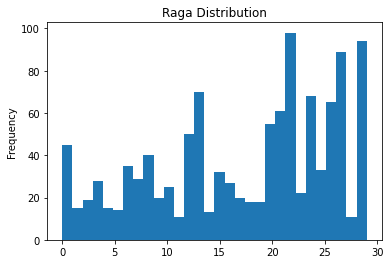

In [13]:
for c in le.classes_: print(f'{c} : {le.transform([c])}')
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [14]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [15]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(labels),
                                         y = labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [16]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [17]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions, s='micro'):
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [18]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      model.train()
  else:
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [19]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [20]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [21]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
  target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data[target]
  ovl_best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[feature], data[target])):
    print(f'FOLD {fold + 1} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        ovl_best_scores = update_best_result(ovl_best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Epoch {epoch+1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time Taken : {(e_end - e_start).total_seconds()} seconds]')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(best_scores['train_labels'],best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(best_scores['test_labels'],best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Fold {fold+1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(ovl_best_scores['train_labels'],ovl_best_scores['train_predictions']))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(ovl_best_scores['test_labels'],ovl_best_scores['test_predictions']))
  if plot: plot_results(results, title)
  return results

In [22]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# OVR Experiment 1 - Chroma Feed Forward

In [23]:
DURATION = 120
FREQ = 16000
def get_chroma(offset, aud_path, a_path):
  aud_path = os.path.join(aud_path, a_path)
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, num_frames=int(DURATION*i.sample_rate), 
                                          frame_offset=int(offset*i.sample_rate))
  waveform = librosa.to_mono(waveform)
  if len(waveform) > 0 :
    resampler = transforms.Resample(sample_rate, FREQ)
    waveform = resampler(torch.tensor(waveform))
    chroma = librosa.feature.chroma_stft(waveform.numpy(), FREQ, n_fft=4096, hop_length=1024)
  else:
    chroma = []
  return torch.tensor(chroma)
data['chroma'] = data.apply(lambda x:get_chroma(x.Offset, AUD_PATH, x['MP3 File']),axis=1)
data = data[data.apply(lambda x:len(x['chroma'].shape)==2,axis=1)]

In [24]:
class ChromaDataset(AbsDataset):
    def __init__(self, labels, chroma):
        super().__init__()
        self.labels = labels
        self.chroma = chroma

    def __get__(self,index):
      if self.chroma[index].shape[1] < 1876:
        self.chroma[index] = torch.hstack((self.chroma[index],torch.zeros(12,1876-self.chroma[index].shape[1])))
      return self.chroma[index].reshape((1,)+self.chroma[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['chroma'].iloc[x] for x in train_ids]
      test_vals = [data['chroma'].iloc[x] for x in test_ids]
      train_data = ChromaDataset(train_lbls, train_vals)
      test_data = ChromaDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [25]:
class ChromaRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 12
        self.width = 1876
        # Fully connected audio layer with Chromagram 12x1876 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(22512,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

In [26]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/15 : Training Loss: 0.808 / Validation Loss : 0.665 [Time Taken : 0.234695 seconds]
Epoch 2/15 : Training Loss: 0.635 / Validation Loss : 0.661 [Time Taken : 0.230473 seconds]
Epoch 3/15 : Training Loss: 0.588 / Validation Loss : 0.652 [Time Taken : 0.22737 seconds]
Epoch 4/15 : Training Loss: 0.509 / Validation Loss : 0.675 [Time Taken : 0.233377 seconds]
Epoch 5/15 : Training Loss: 0.423 / Validation Loss : 0.738 [Time Taken : 0.218161 seconds]
Epoch 6/15 : Training Loss: 0.328 / Validation Loss : 0.850 [Time Taken : 0.216556 seconds]
Epoch 7/15 : Training Loss: 0.236 / Validation Loss : 0.930 [Time Taken : 0.220365 seconds]
Epoch 8/15 : Training Loss: 0.146 / Validation Loss : 1.119 [Time Taken : 0.217722 seconds]
Epoch 9/15 : Training Loss: 0.083 / Validation Loss : 1.320 [Time Taken : 0.215206 seconds]
Epoch 10/15 : Training Loss: 0.048 / Val

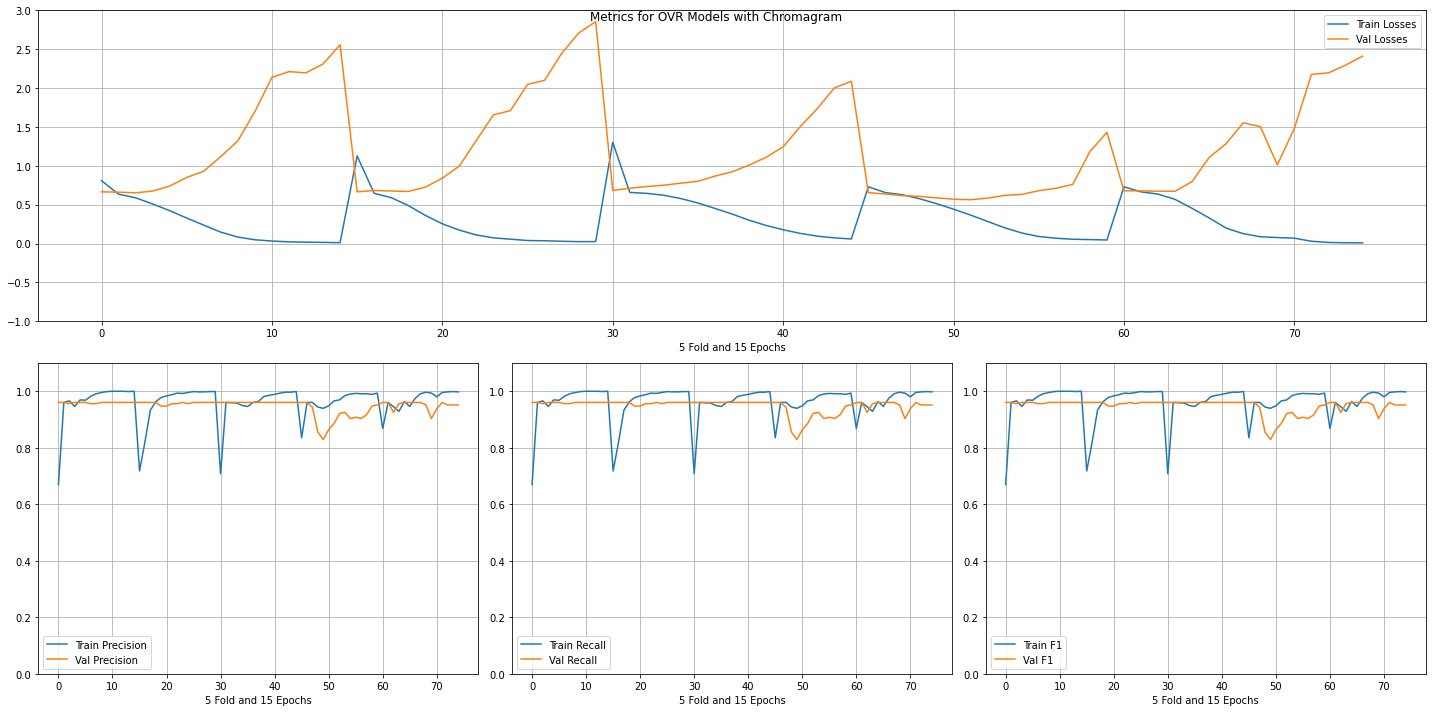

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.669594       0.960526  ...      0.808368           0.664853
6   0.960483       0.960526  ...      0.451188           0.867116
12  0.997805       0.960526  ...      0.028800           2.445186
13  0.998902       0.960526  ...      0.023986           2.708217
14  0.998902       0.960526  ...      0.024495           2.855278
..       ...            ...  ...           ...                ...
9   0.993421       0.903084  ...      0.076636           1.011975
6   0.965971       0.885965  ...      0.365555           0.563687
5   0.948408       0.864035  ...      0.441775           0.569961
3   0.944018       0.855263  ...      0.576539           0.606397
4   0.939627       0.828947  ...      0.512733           0.587003

[75 rows x 8 columns]
Training for ['కన్నడగౌళ'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 0.964 / Validation Lo

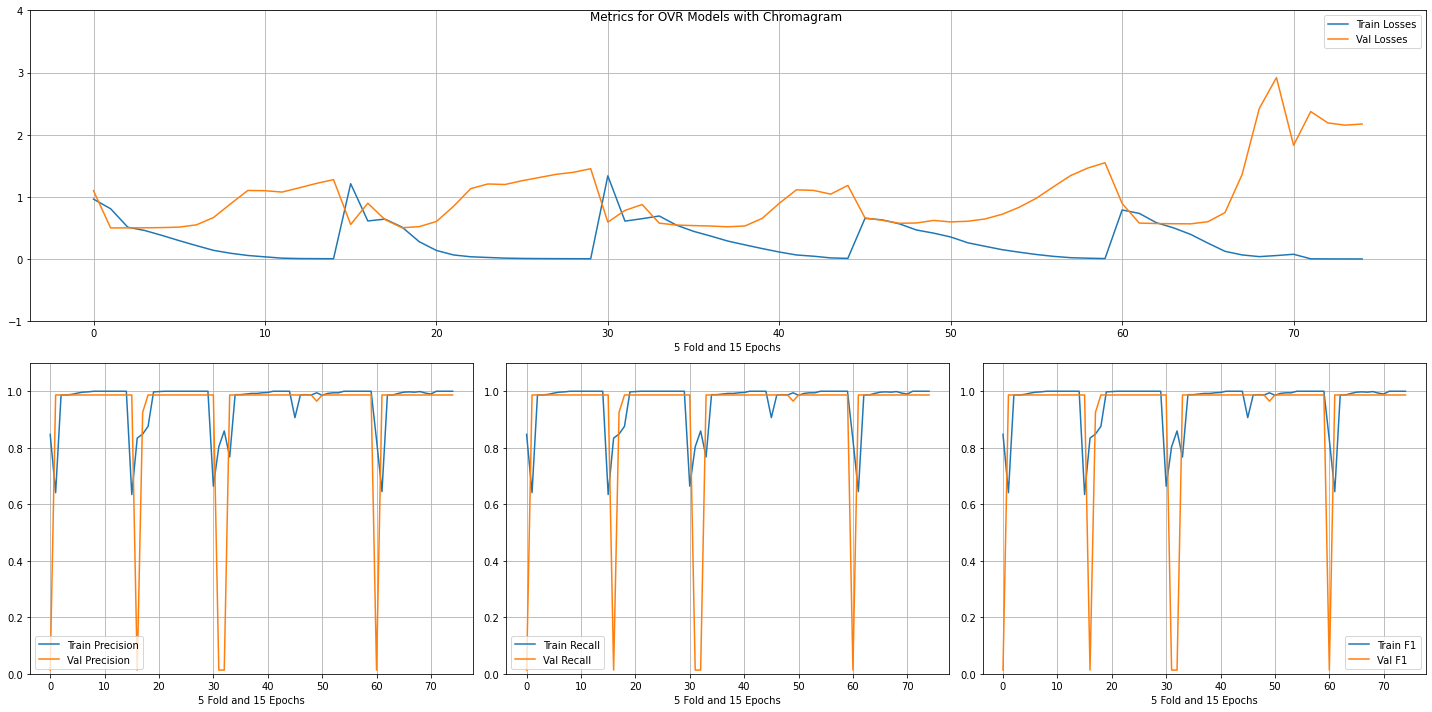

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.992316       0.986842  ...      0.288993           0.518871
12  1.000000       0.986842  ...      0.021548           1.343679
0   0.664105       0.986842  ...      1.338848           0.593826
14  1.000000       0.986842  ...      0.007672           1.549228
3   0.767289       0.986842  ...      0.692339           0.577195
..       ...            ...  ...           ...                ...
0   0.827851       0.013216  ...      0.789696           0.893503
2   0.859495       0.013158  ...      0.649320           0.877060
1   0.803513       0.013158  ...      0.610070           0.782053
1   0.834248       0.013158  ...      0.612635           0.897803
0   0.847420       0.013158  ...      0.963999           1.099372

[75 rows x 8 columns]
Training for ['కాంబోది'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50848214 29.97368421]
Epoch 1/15 : Training Loss: 0.732 / Validation Los

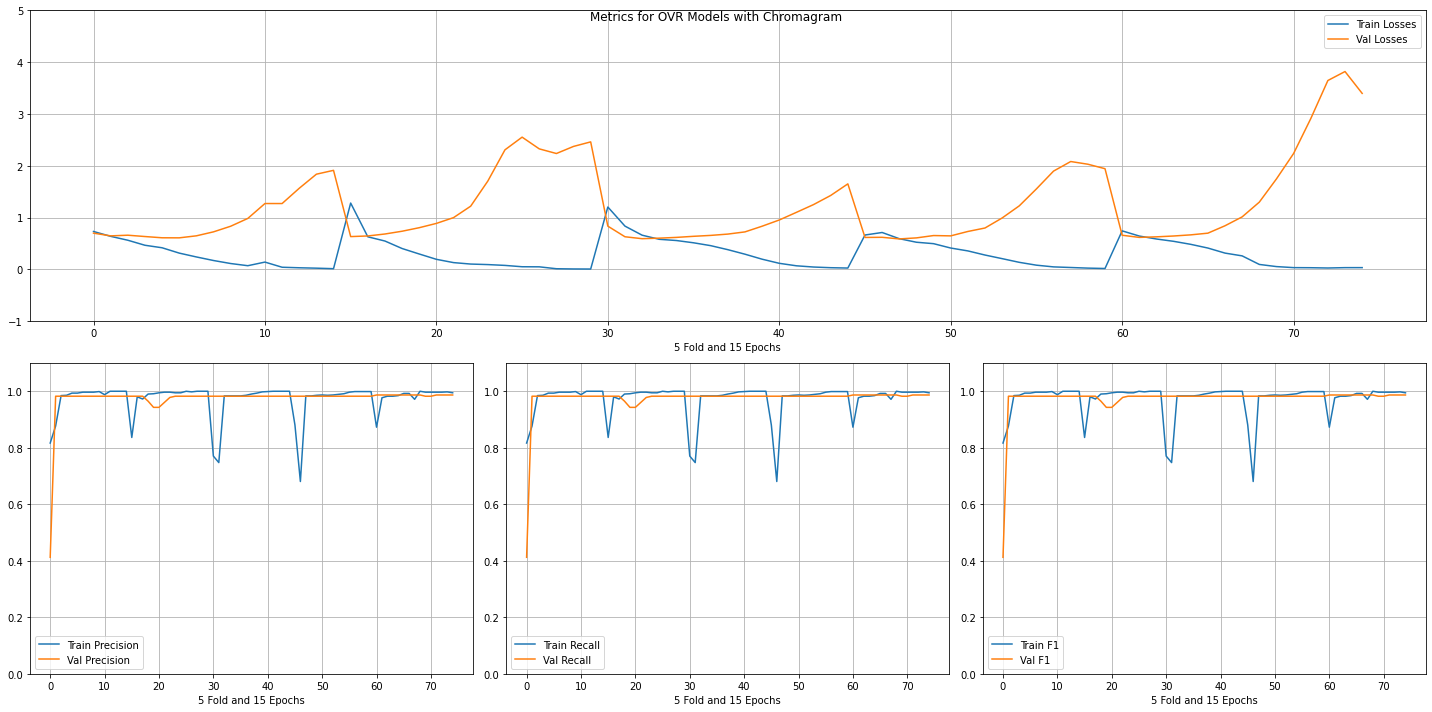

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.994518       0.986784  ...      0.034294           3.397963
6   0.992325       0.986784  ...      0.314782           0.842382
0   0.872807       0.986784  ...      0.744022           0.659367
2   0.982456       0.986784  ...      0.586827           0.628562
3   0.982456       0.986784  ...      0.542076           0.644785
..       ...            ...  ...           ...                ...
3   0.990121       0.964912  ...      0.403055           0.736905
6   0.996707       0.960526  ...      0.131142           0.999432
4   0.991218       0.942982  ...      0.297312           0.805122
5   0.994512       0.942982  ...      0.194546           0.887850
0   0.816685       0.412281  ...      0.732071           0.699959

[75 rows x 8 columns]
Training for ['గుండుక్రియ'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51260126 20.33928571]
Epoch 1/15 : Training Loss: 0.748 / Validation 

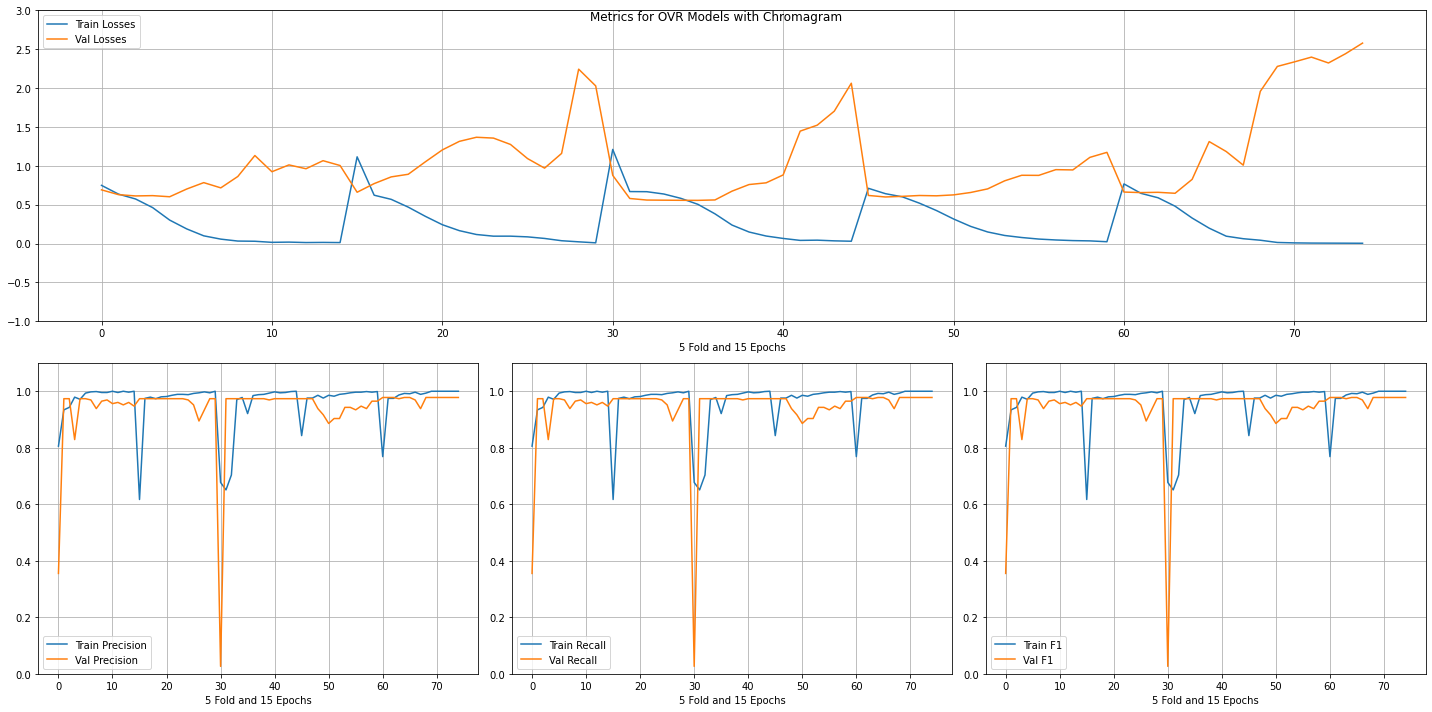

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977974  ...      0.003090           2.579157
8   0.993421       0.977974  ...      0.042220           1.958171
0   0.768640       0.977974  ...      0.766892           0.662087
1   0.974781       0.977974  ...      0.645259           0.655250
4   0.992325       0.977974  ...      0.327532           0.825519
..       ...            ...  ...           ...                ...
11  0.994512       0.894737  ...      0.065080           0.970025
5   0.985730       0.885965  ...      0.315652           0.625633
3   0.979144       0.828947  ...      0.462115           0.616061
0   0.805708       0.355263  ...      0.748252           0.690433
0   0.677278       0.026316  ...      1.210818           0.876823

[75 rows x 8 columns]
Training for ['గుజ్జరి'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 0.794 / Validation Los

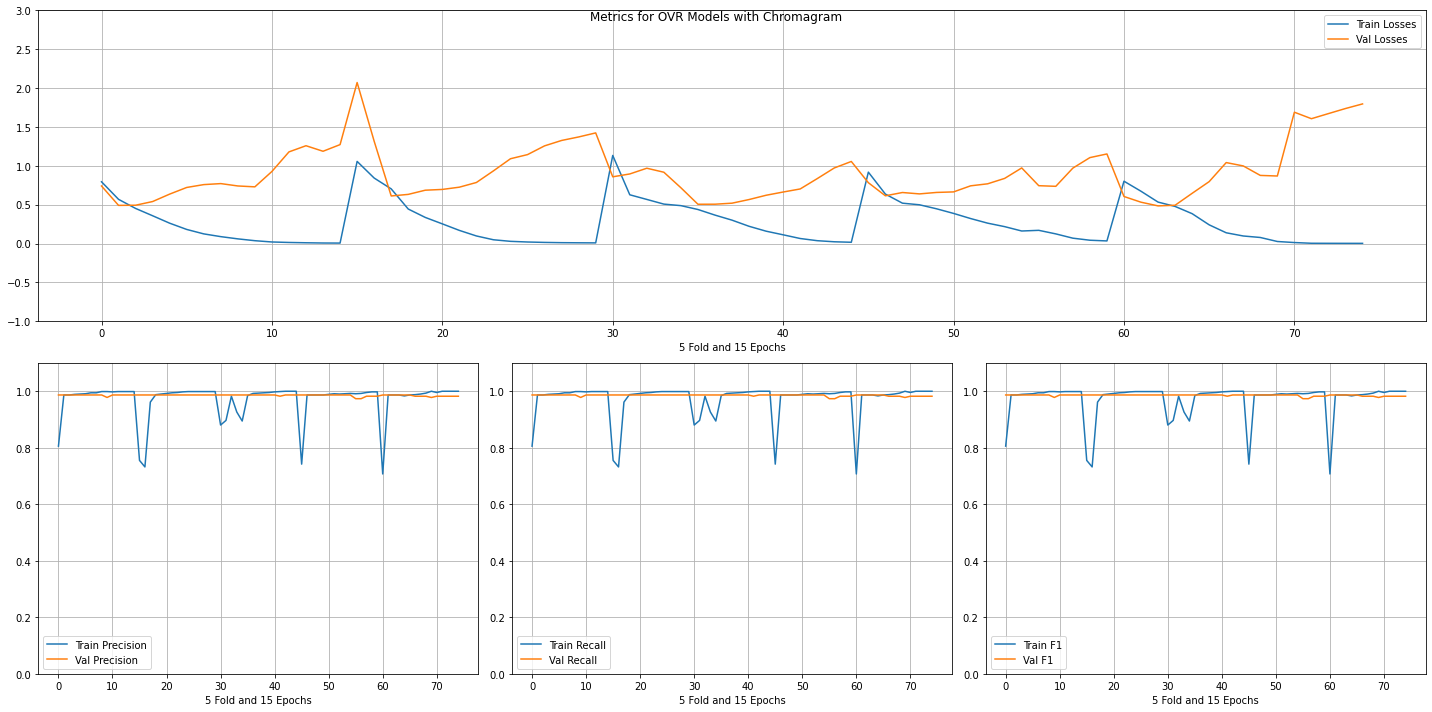

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.805708       0.986842  ...      0.794378           0.740343
12  1.000000       0.986842  ...      0.036193           0.835083
0   0.880351       0.986842  ...      1.133254           0.858306
1   0.896817       0.986842  ...      0.626915           0.895036
2   0.982437       0.986842  ...      0.567145           0.968808
..       ...            ...  ...           ...                ...
14  1.000000       0.982379  ...      0.001853           1.796456
9   0.998902       0.978070  ...      0.036061           0.729126
9   1.000000       0.977974  ...      0.025776           0.868639
11  0.992316       0.973684  ...      0.123612           0.735963
10  0.991218       0.973684  ...      0.169551           0.743951

[75 rows x 8 columns]
Training for ['గౌళ'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50622222 40.67857143]
Epoch 1/15 : Training Loss: 0.662 / Validation Loss : 

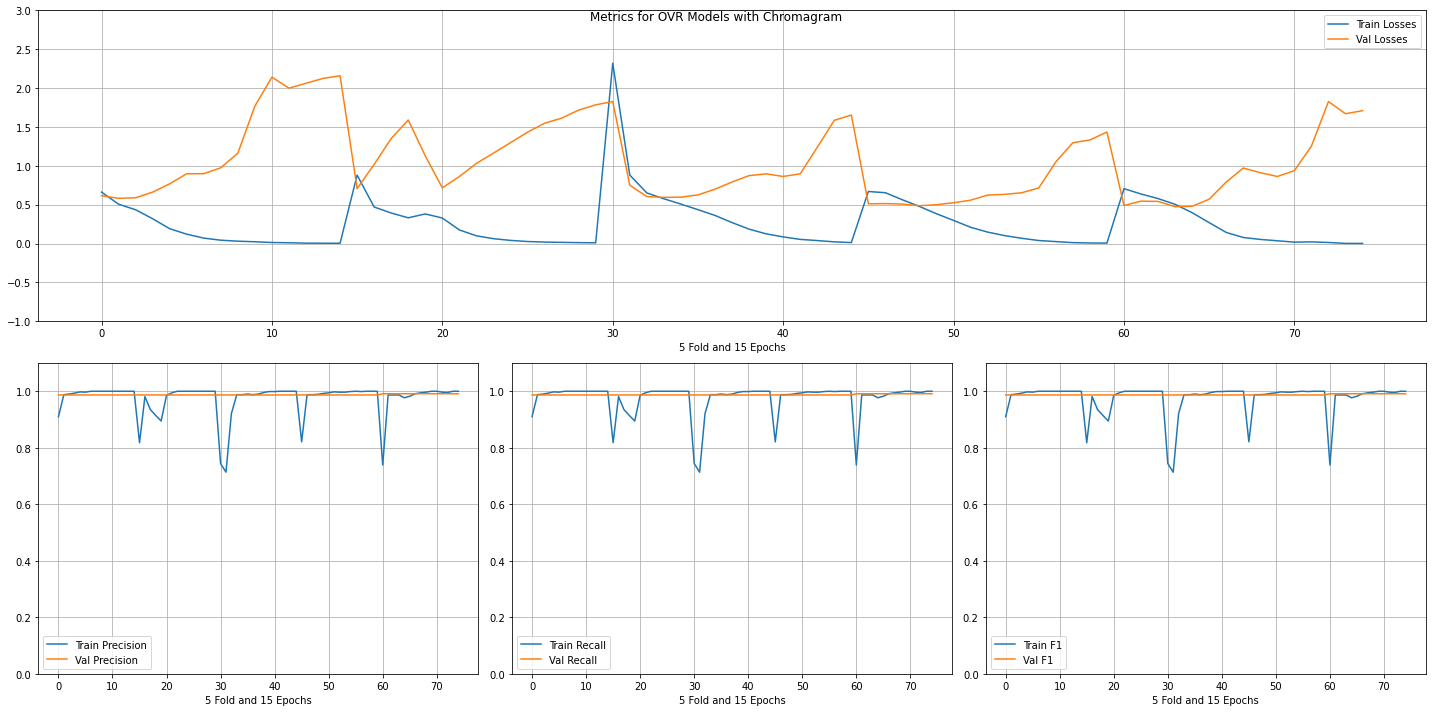

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991189  ...      0.001018           1.709595
7   0.994518       0.991189  ...      0.077318           0.971619
0   0.739035       0.991189  ...      0.705806           0.488686
1   0.986842       0.991189  ...      0.637023           0.545227
2   0.986842       0.991189  ...      0.577973           0.541677
..       ...            ...  ...           ...                ...
9   1.000000       0.986842  ...      0.040007           1.297470
8   1.000000       0.986842  ...      0.061988           1.163171
7   1.000000       0.986842  ...      0.098890           1.030677
6   0.994512       0.986842  ...      0.174563           0.862005
7   0.990121       0.986842  ...      0.269338           0.791062

[75 rows x 8 columns]
Training for ['దేవగాంధారి'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51585145 16.27142857]
Epoch 1/15 : Training Loss: 0.737 / Validation 

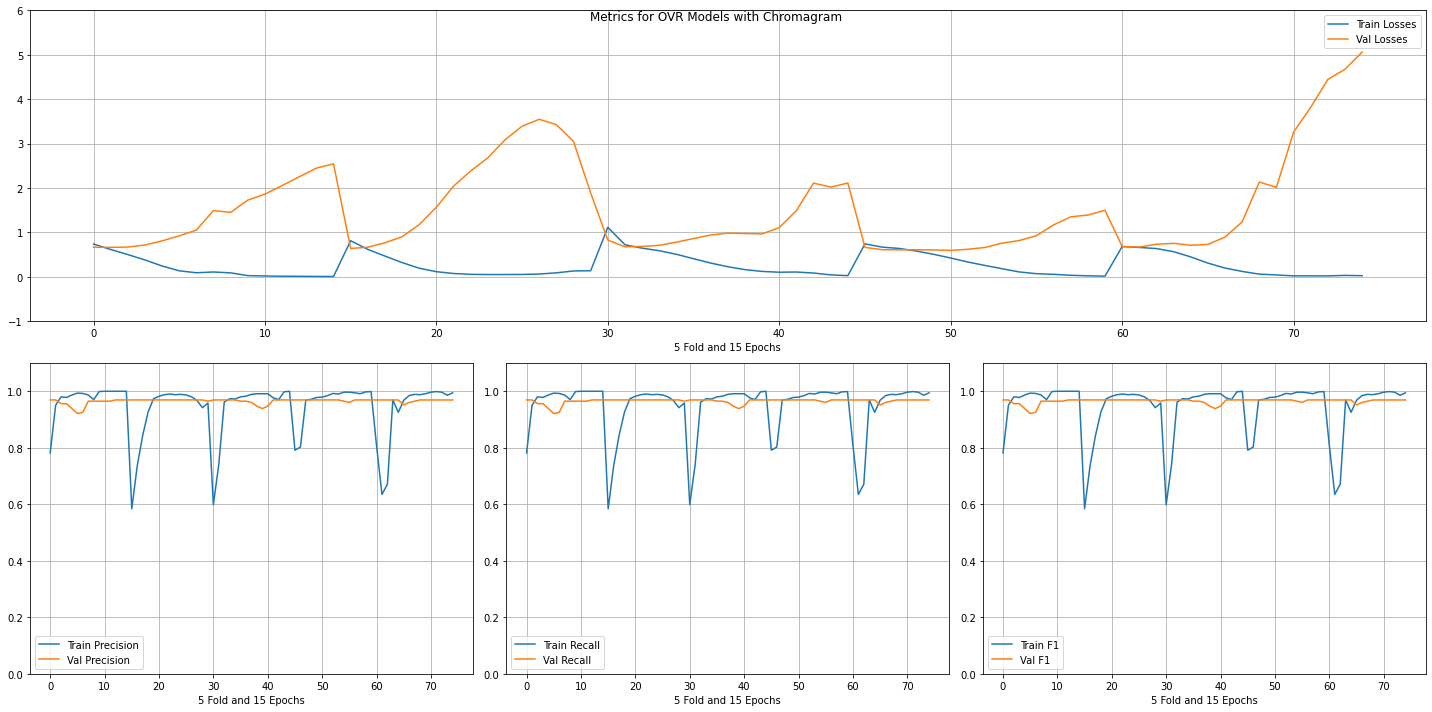

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.781559       0.969298  ...      0.737407           0.665587
11  0.994512       0.969298  ...      0.055627           1.168918
13  0.941822       0.969298  ...      0.131434           3.047262
0   0.598244       0.969298  ...      1.113966           0.825788
1   0.742042       0.969298  ...      0.721691           0.676437
..       ...            ...  ...           ...                ...
10  0.991218       0.947368  ...      0.103223           1.107342
9   0.991218       0.938596  ...      0.121064           0.967033
4   0.986828       0.938596  ...      0.243331           0.809174
6   0.992316       0.925439  ...      0.091204           1.052053
5   0.993414       0.921053  ...      0.135009           0.922879

[75 rows x 8 columns]
Training for ['దేసాక్షి'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51306306 19.63793103]
Epoch 1/15 : Training Loss: 1.338 / Validation Lo

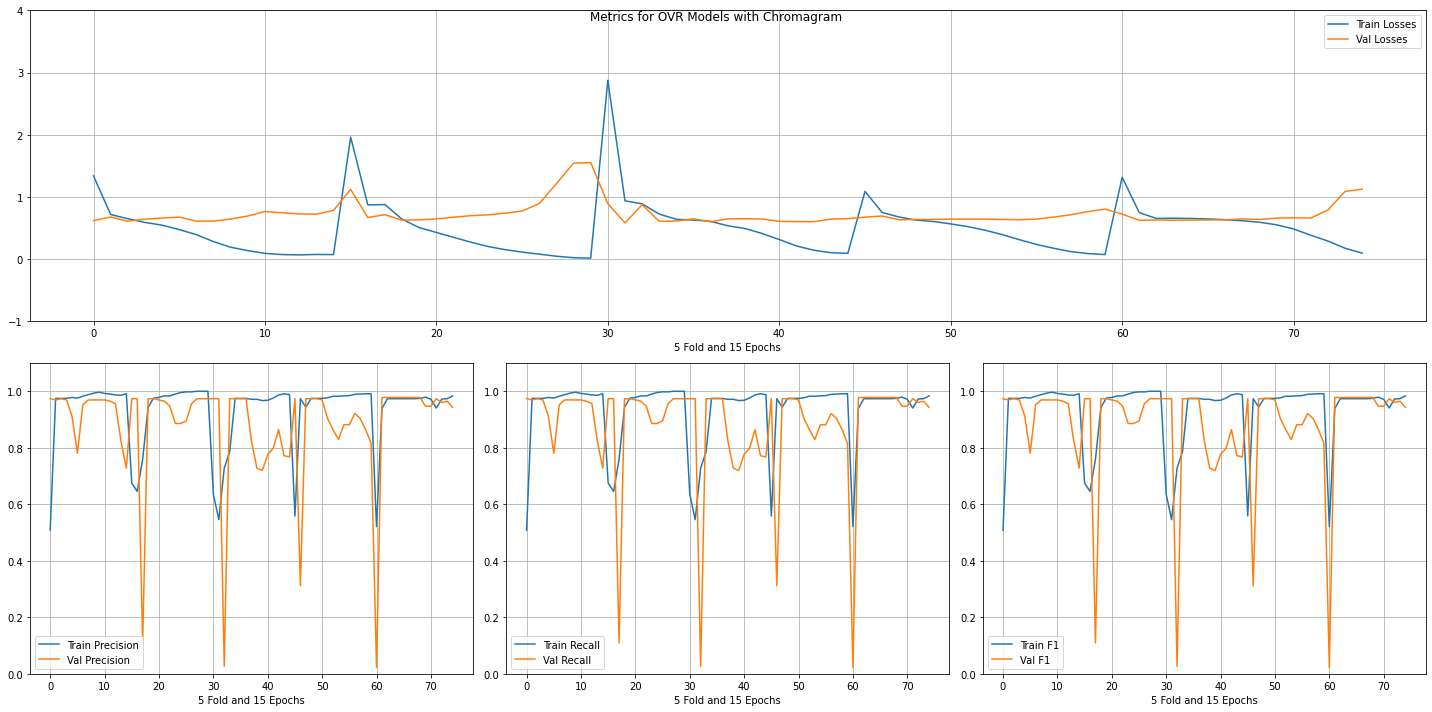

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.974781       0.977974  ...      0.592284           0.636877
3   0.973684       0.977974  ...      0.657103           0.624936
6   0.973684       0.977974  ...      0.633018           0.630544
5   0.973684       0.977974  ...      0.645829           0.628462
4   0.973684       0.977974  ...      0.652724           0.626628
..       ...            ...  ...           ...                ...
9   0.967069       0.719298  ...      0.411234           0.644975
1   0.973655       0.311404  ...      0.748735           0.692492
2   0.759605       0.109649  ...      0.876580           0.712774
2   0.727772       0.026316  ...      0.887733           0.873789
0   0.520833       0.022026  ...      1.315616           0.722550

[75 rows x 8 columns]
Training for ['దేసాళం'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51819836 14.2375    ]
Epoch 1/15 : Training Loss: 0.732 / Validation Loss

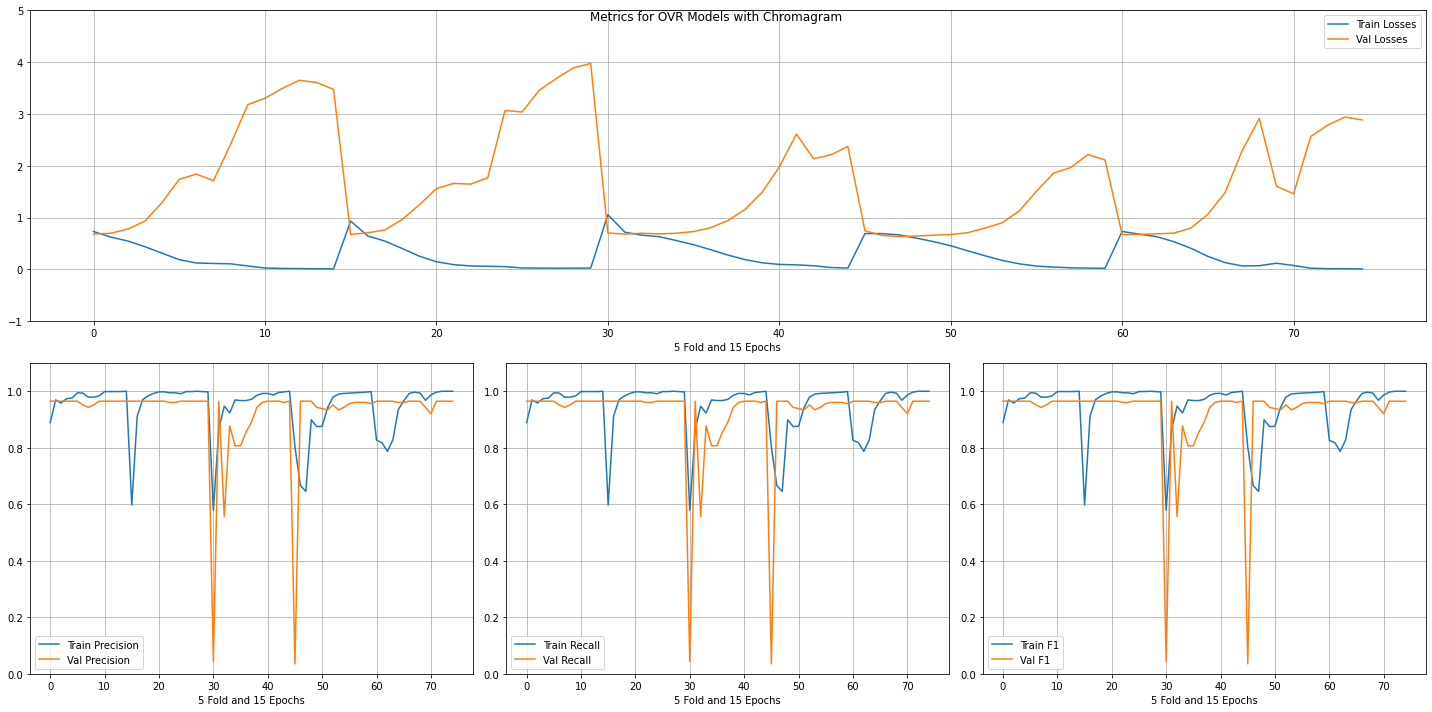

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.889133       0.964912  ...      0.731760           0.683375
3   0.983535       0.964912  ...      0.404151           0.962925
5   0.997805       0.964912  ...      0.148408           1.558640
14  1.000000       0.964912  ...      0.026297           2.373608
9   0.991218       0.964912  ...      0.053650           3.066732
..       ...            ...  ...           ...                ...
4   0.969265       0.807018  ...      0.556578           0.698687
5   0.967069       0.807018  ...      0.477182           0.730612
2   0.947311       0.557018  ...      0.660252           0.698378
0   0.579583       0.043860  ...      1.055528           0.703793
0   0.803513       0.035088  ...      0.691596           0.744080

[75 rows x 8 columns]
Training for ['ధన్నాసి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 0.918 / Validation Los

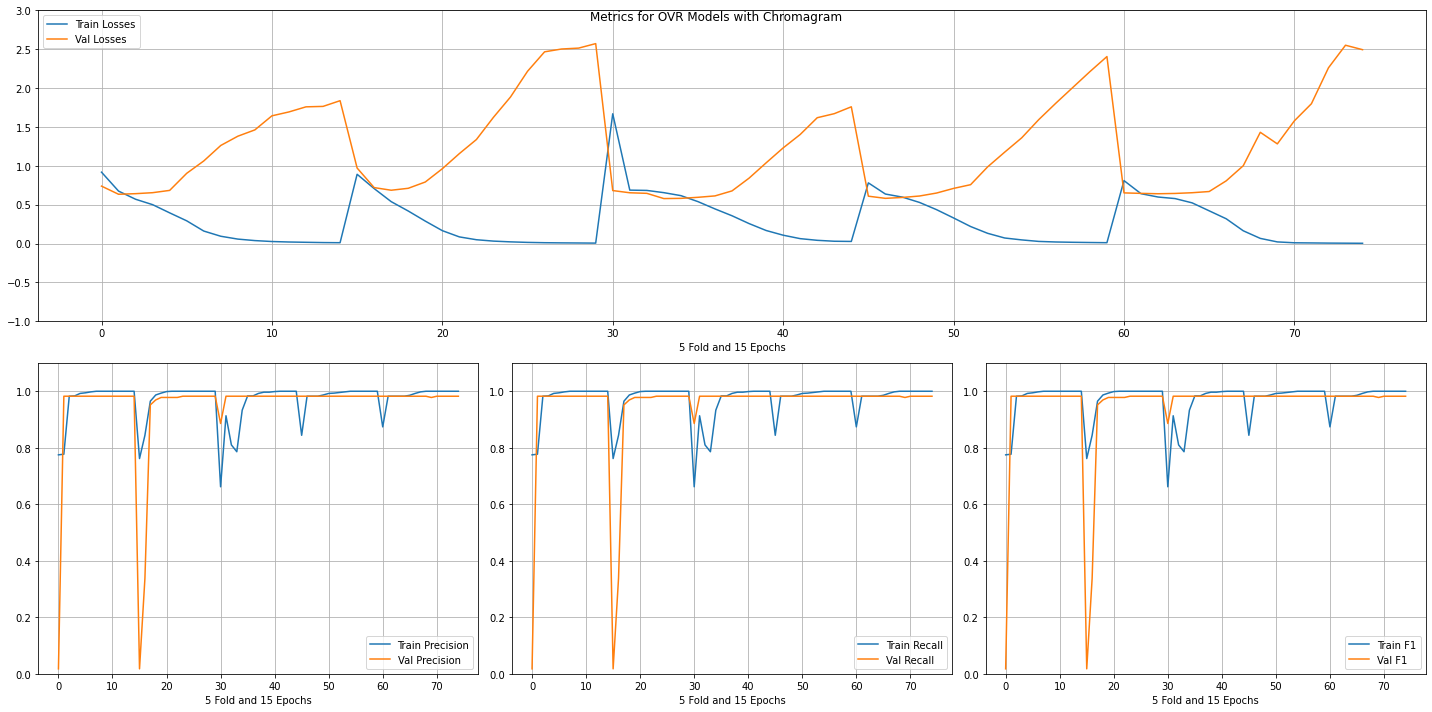

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.992316       0.982456  ...      0.356936           0.677040
1   0.777168       0.982456  ...      0.674541           0.633712
12  1.000000       0.982456  ...      0.008023           2.503178
13  1.000000       0.982456  ...      0.006563           2.514725
14  1.000000       0.982456  ...      0.004955           2.572529
..       ...            ...  ...           ...                ...
2   0.964874       0.951754  ...      0.538546           0.685550
0   0.661910       0.885965  ...      1.669498           0.681231
1   0.844127       0.337719  ...      0.706861           0.719432
0   0.761800       0.017544  ...      0.890874           0.971308
0   0.774973       0.017544  ...      0.918115           0.738426

[75 rows x 8 columns]
Training for ['నాట'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 0.896 / Validation Loss : 

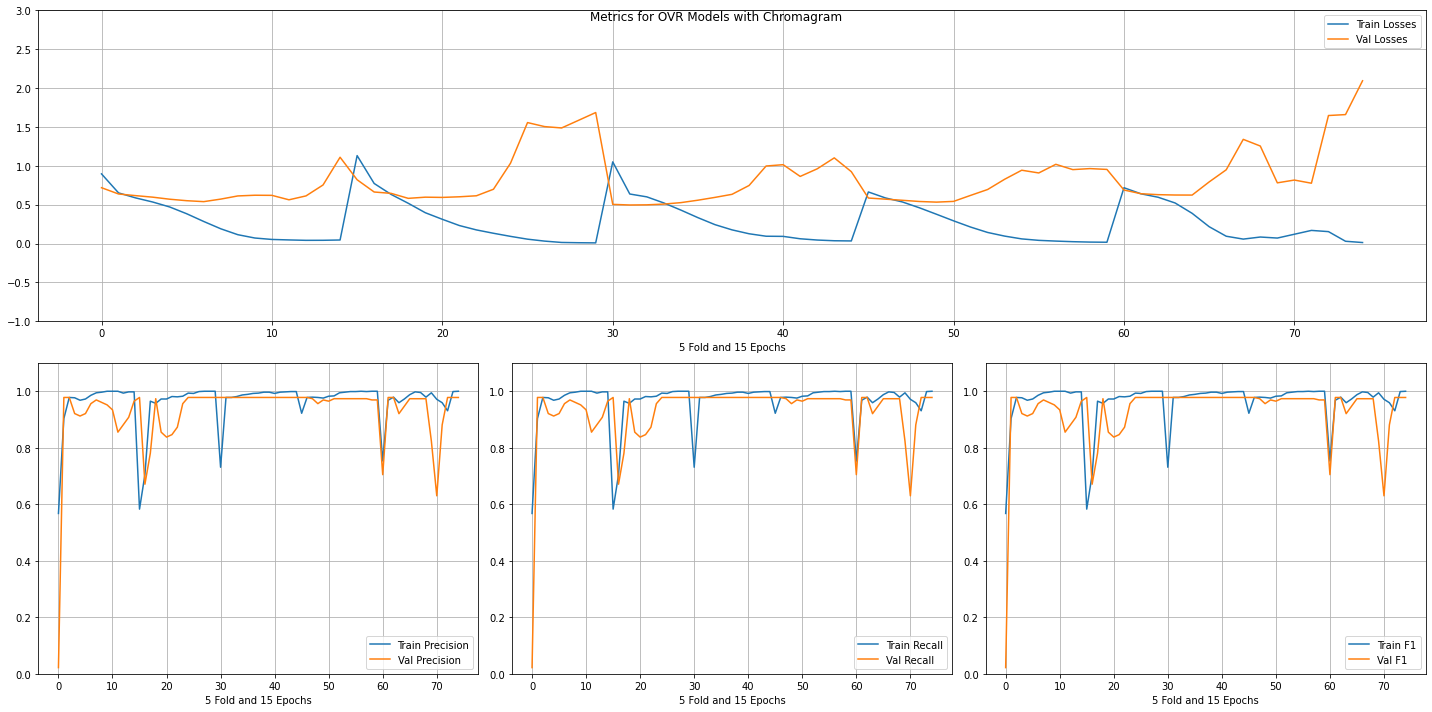

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.993414       0.978070  ...      0.175467           0.632912
0   0.731065       0.978070  ...      1.050563           0.503513
13  1.000000       0.978070  ...      0.009898           1.585929
12  1.000000       0.978070  ...      0.013427           1.487057
11  0.998902       0.978070  ...      0.030819           1.504576
..       ...            ...  ...           ...                ...
2   0.964874       0.780702  ...      0.630987           0.645104
0   0.753289       0.704846  ...      0.717862           0.688402
1   0.704720       0.671053  ...      0.772552           0.662786
10  0.971491       0.629956  ...      0.119243           0.816468
0   0.567508       0.021930  ...      0.895959           0.718064

[75 rows x 8 columns]
Training for ['నాదరామక్రియ'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 0.672 / Validation

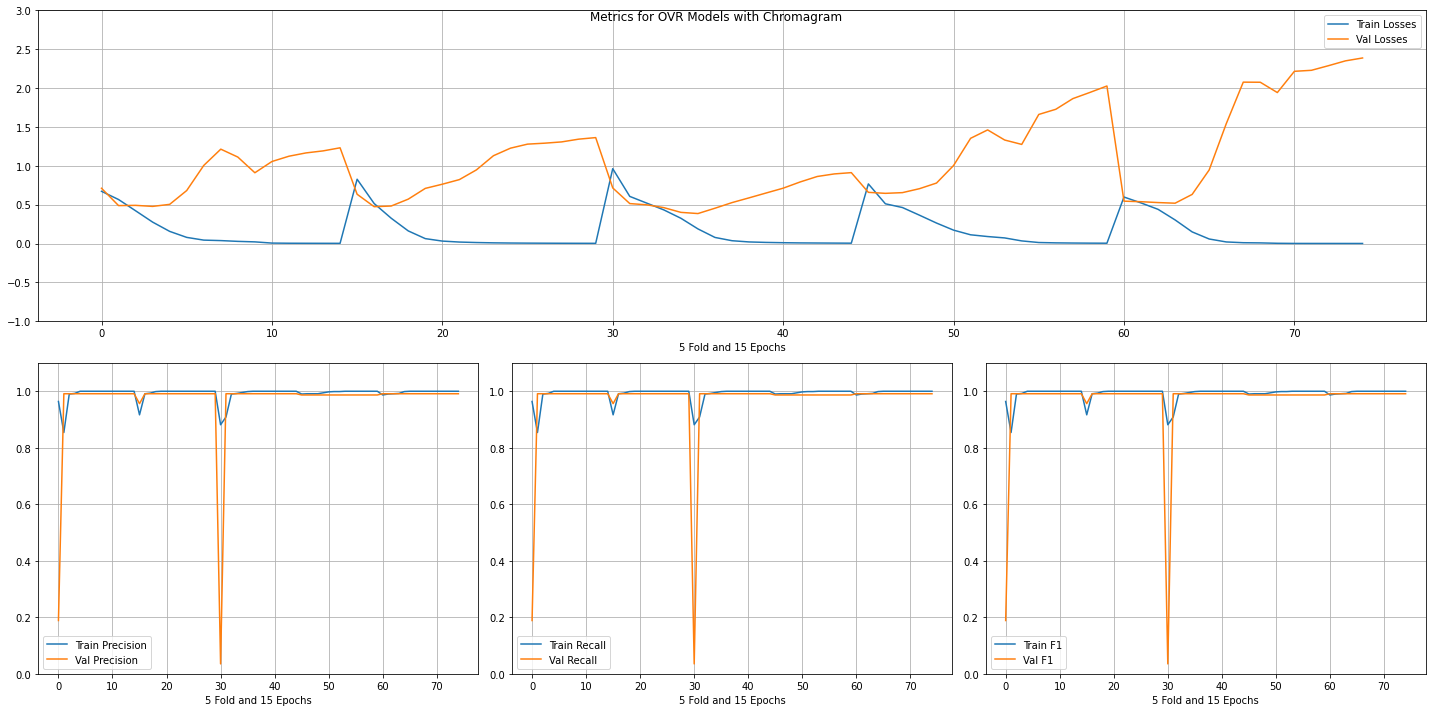

    train_f1  validation_f1  ...  train_losses  validation_losses
7   1.000000       0.991228  ...      0.035789           0.526376
7   1.000000       0.991228  ...      0.012407           0.947300
9   1.000000       0.991228  ...      0.006020           1.226960
10  1.000000       0.991228  ...      0.004659           1.278830
11  1.000000       0.991228  ...      0.003825           1.291041
..       ...            ...  ...           ...                ...
11  1.000000       0.986842  ...      0.008140           1.727440
14  1.000000       0.986842  ...      0.003686           2.027024
0   0.916575       0.956140  ...      0.827105           0.633752
0   0.963776       0.188596  ...      0.671622           0.711049
0   0.881449       0.035088  ...      0.962985           0.715187

[75 rows x 8 columns]
Training for ['పాడి'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52247706 11.62244898]
Epoch 1/15 : Training Loss: 0.770 / Validation Loss :

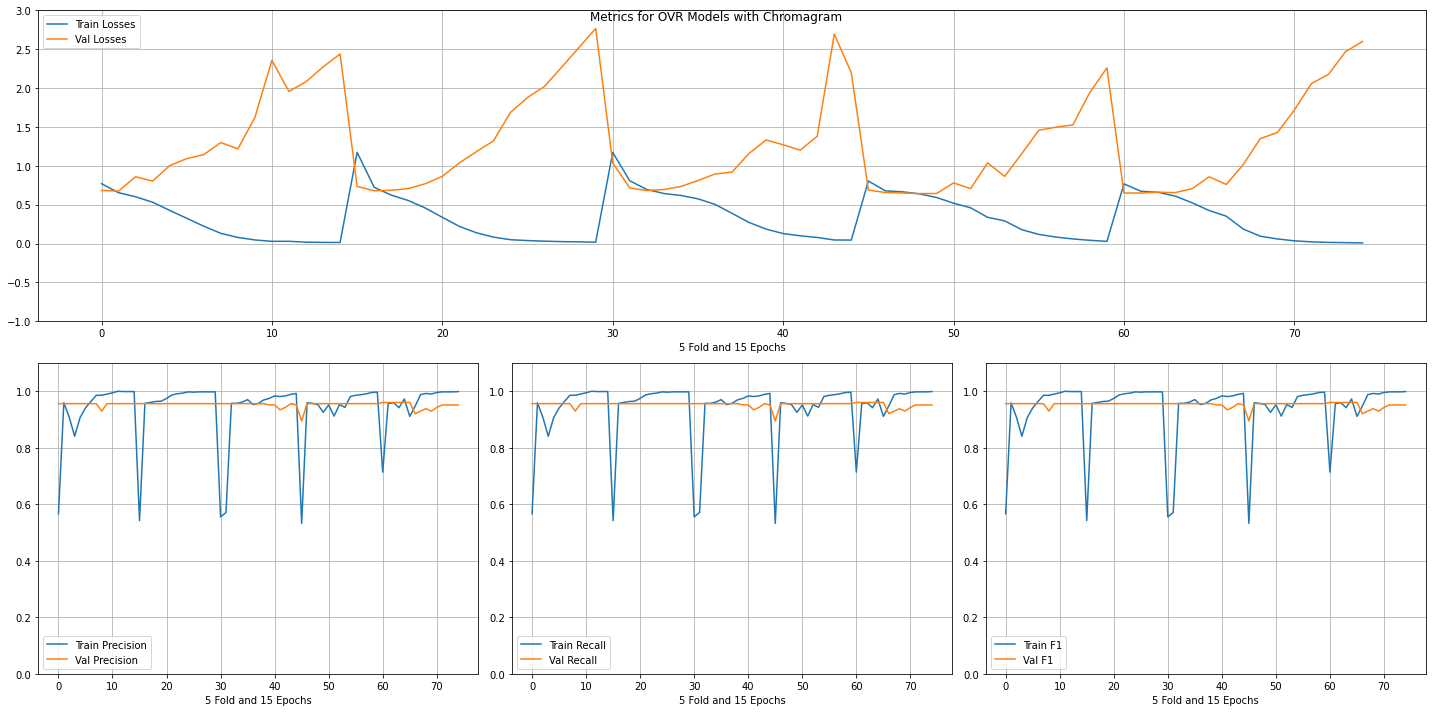

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.911184       0.960352  ...      0.424253           0.858436
4   0.972588       0.960352  ...      0.523782           0.706317
3   0.941886       0.960352  ...      0.610507           0.654178
2   0.959430       0.960352  ...      0.659206           0.660865
1   0.956140       0.960352  ...      0.672062           0.650010
..       ...            ...  ...           ...                ...
8   0.985730       0.929825  ...      0.078047           1.217426
7   0.987939       0.929515  ...      0.185823           1.016740
9   0.990132       0.929515  ...      0.058582           1.428149
6   0.947368       0.920705  ...      0.351603           0.759274
0   0.532382       0.894737  ...      0.804023           0.687898

[75 rows x 8 columns]
Training for ['బౌళి'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53274088 8.13571429]
Epoch 1/15 : Training Loss: 0.774 / Validation Loss : 0

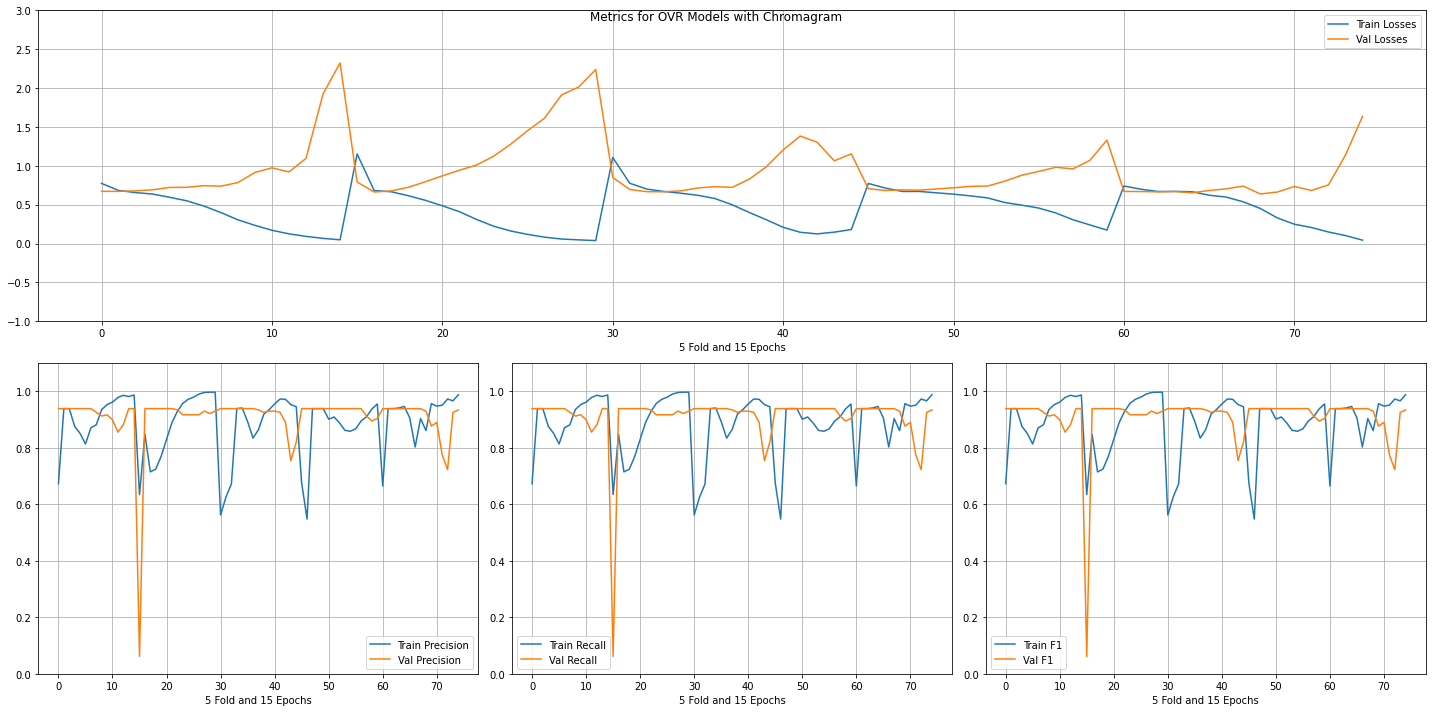

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.672887       0.938596  ...      0.773688           0.671537
0   0.675082       0.938596  ...      0.772463           0.706169
10  0.867179       0.938596  ...      0.455934           0.927956
9   0.858397       0.938596  ...      0.493828           0.878684
8   0.861690       0.938596  ...      0.527868           0.801385
..       ...            ...  ...           ...                ...
14  0.945115       0.820175  ...      0.179558           1.153344
11  0.950658       0.775330  ...      0.205867           0.682568
13  0.952799       0.754386  ...      0.146264           1.064285
12  0.972588       0.722467  ...      0.148142           0.754300
0   0.634468       0.061404  ...      1.153287           0.791096

[75 rows x 8 columns]
Training for ['బౌళిరామక్రియ'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50577265 43.80769231]
Epoch 1/15 : Training Loss: 0.774 / Validatio

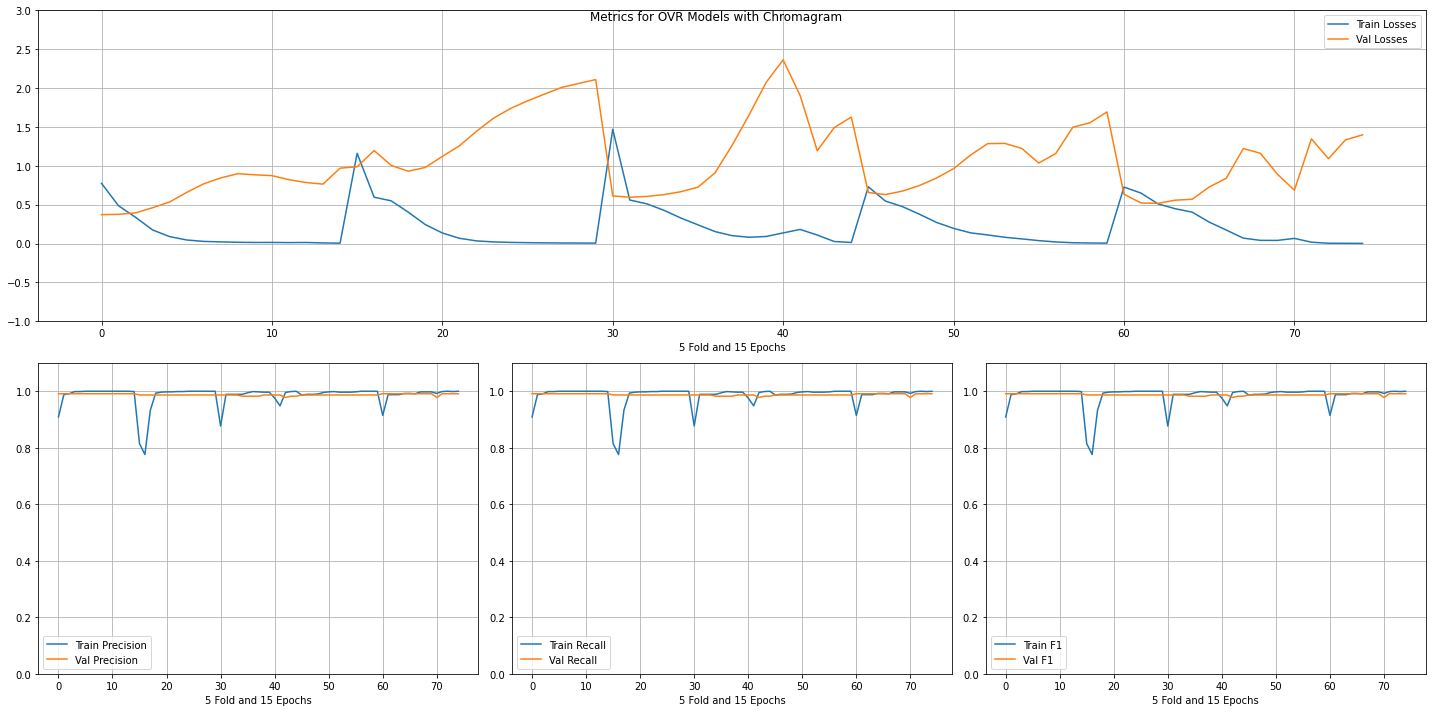

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.908891       0.991228  ...      0.774185           0.371272
8   1.000000       0.991228  ...      0.015577           0.898832
1   0.987925       0.991228  ...      0.485568           0.375363
13  1.000000       0.991228  ...      0.007104           0.764570
12  1.000000       0.991228  ...      0.013188           0.784921
..       ...            ...  ...           ...                ...
5   0.994512       0.982456  ...      0.240113           0.724845
4   0.989023       0.982456  ...      0.327506           0.666732
7   0.997805       0.982456  ...      0.101492           1.261321
12  0.995609       0.978070  ...      0.108778           1.193877
10  0.992325       0.977974  ...      0.065730           0.685215

[75 rows x 8 columns]
Training for ['భూపాలం'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51445348 17.796875  ]
Epoch 1/15 : Training Loss: 0.852 / Validation Loss

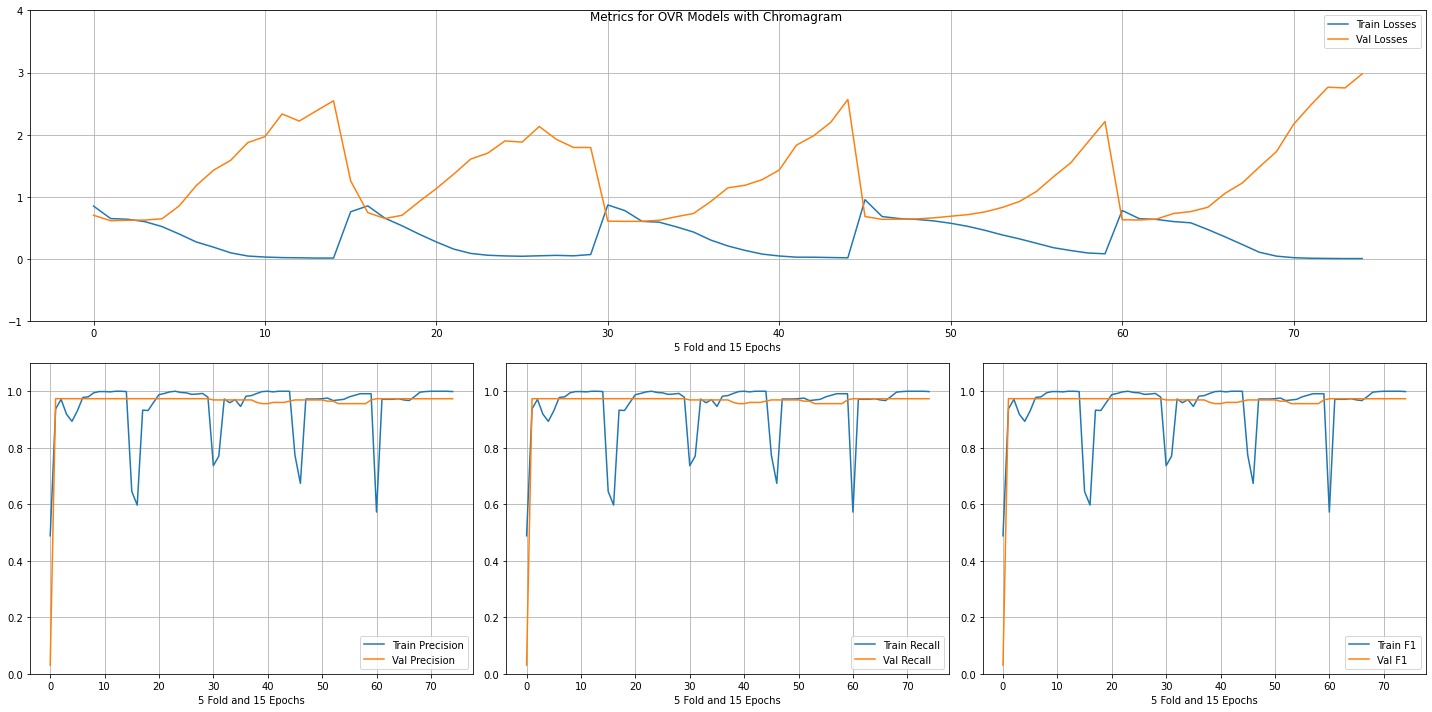

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.995609       0.973684  ...      0.050229           1.900074
0   0.645445       0.973684  ...      0.760975           1.256276
14  0.979144       0.973684  ...      0.072579           1.793954
13  0.992316       0.973684  ...      0.051821           1.794845
12  0.990121       0.973684  ...      0.059196           1.924846
..       ...            ...  ...           ...                ...
11  0.985730       0.956140  ...      0.182063           1.325253
10  0.980241       0.956140  ...      0.253852           1.086842
9   0.971460       0.956140  ...      0.324914           0.924299
8   0.969265       0.956140  ...      0.388441           0.829584
0   0.488474       0.030702  ...      0.852087           0.704272

[75 rows x 8 columns]
Training for ['భైరవి'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51214029 21.09259259]
Epoch 1/15 : Training Loss: 0.873 / Validation Loss 

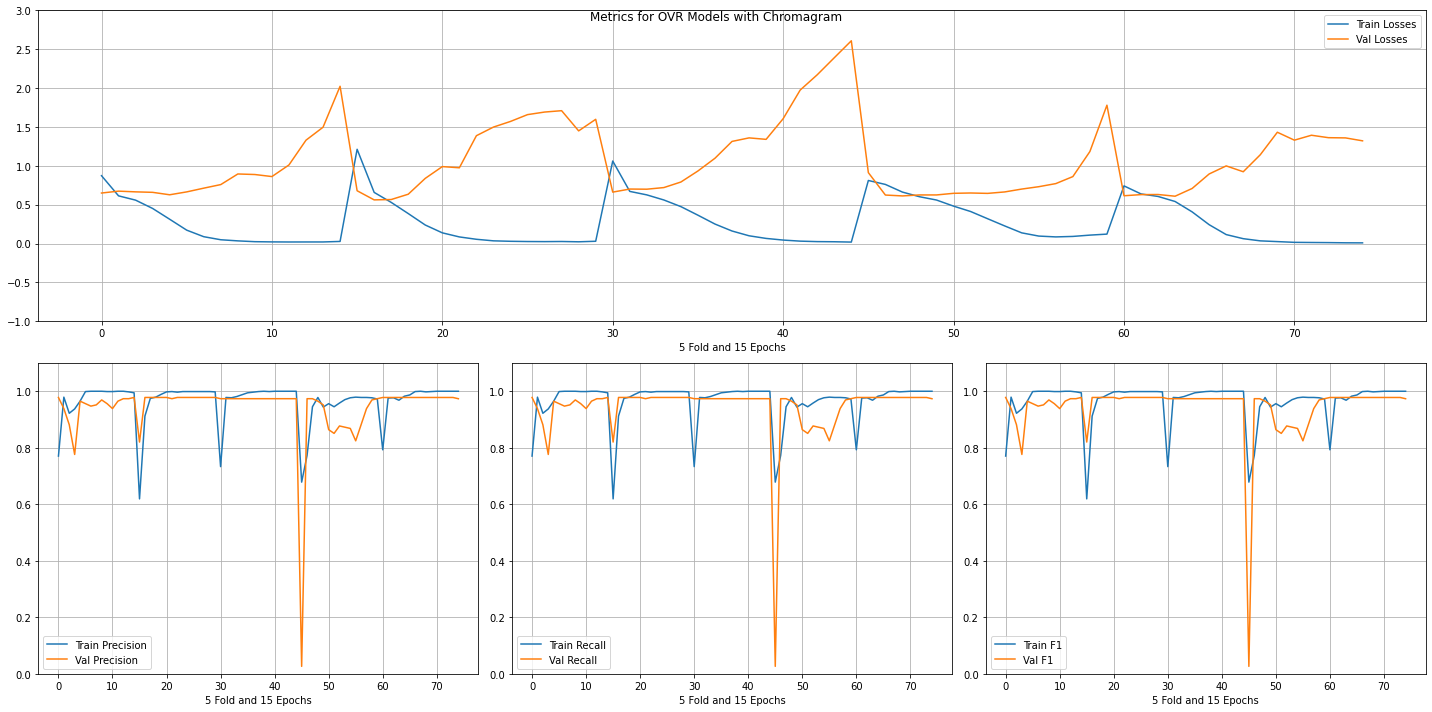

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.770582       0.978070  ...      0.872772           0.649571
14  0.994512       0.978070  ...      0.026539           2.023372
14  0.997805       0.978070  ...      0.028891           1.598231
13  0.998902       0.978070  ...      0.021902           1.449378
12  0.998902       0.978070  ...      0.025829           1.709316
..       ...            ...  ...           ...                ...
6   0.945115       0.850877  ...      0.411824           0.649965
10  0.979144       0.824561  ...      0.095559           0.731067
0   0.619100       0.820175  ...      1.212429           0.678980
3   0.937431       0.776316  ...      0.450945           0.658445
0   0.678375       0.026316  ...      0.811018           0.911889

[75 rows x 8 columns]
Training for ['మలహరి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 0.791 / Validation Loss 

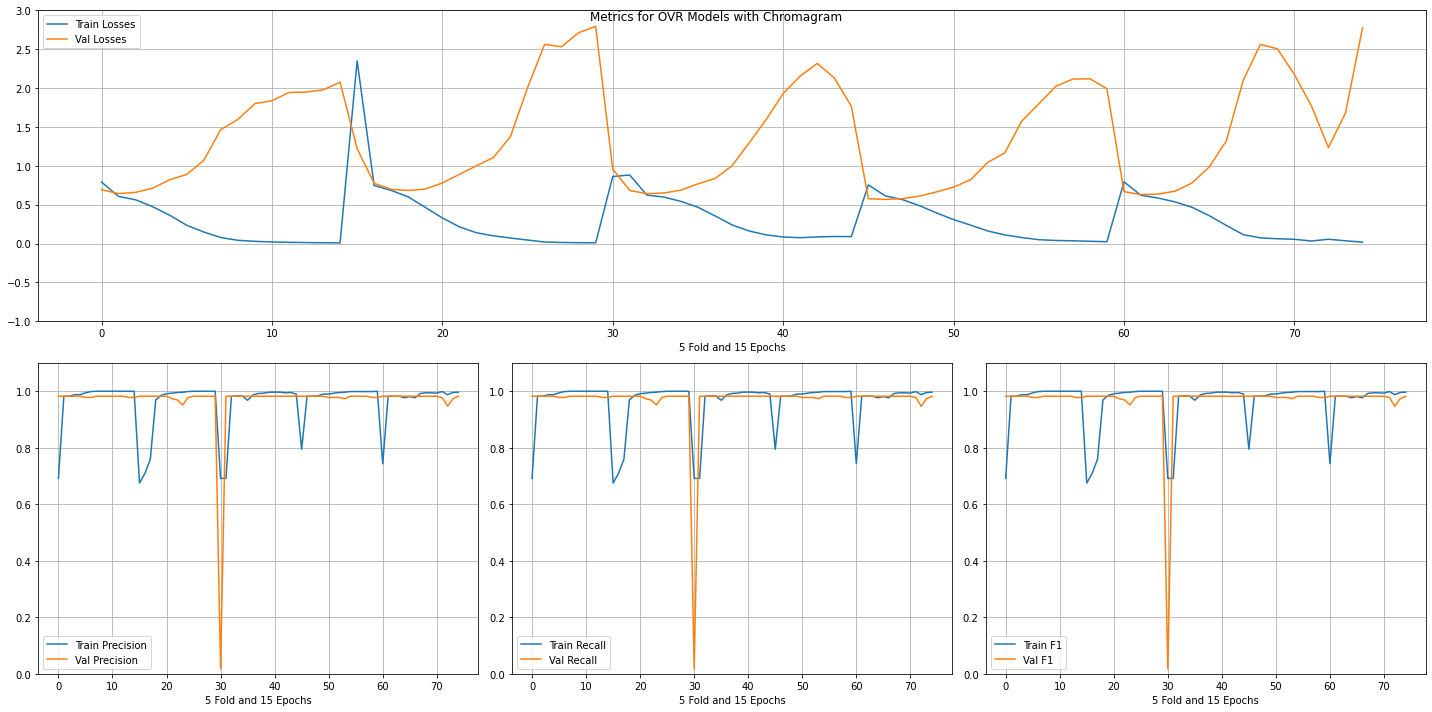

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.691548       0.982456  ...      0.790605           0.692121
11  0.996707       0.982456  ...      0.074571           2.155337
14  1.000000       0.982456  ...      0.008886           2.793886
1   0.691548       0.982456  ...      0.881591           0.681695
2   0.982437       0.982456  ...      0.622942           0.641859
..       ...            ...  ...           ...                ...
13  0.995614       0.973568  ...      0.034977           1.680011
7   0.995609       0.969298  ...      0.138474           0.999725
8   0.996707       0.951754  ...      0.098930           1.107243
12  0.987939       0.947137  ...      0.054629           1.235141
0   0.691548       0.017544  ...      0.861722           0.957883

[75 rows x 8 columns]
Training for ['మాళవి'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 0.776 / Validation Loss 

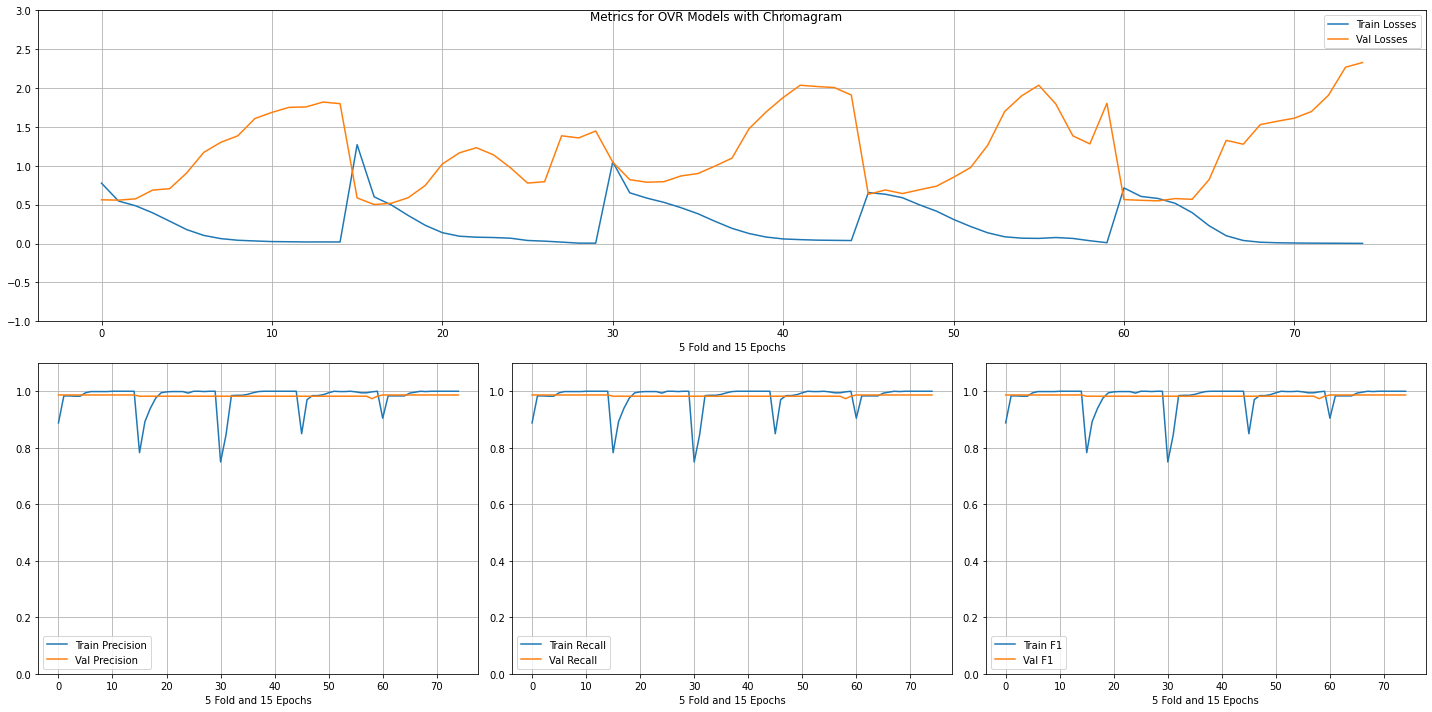

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.888035       0.986842  ...      0.776277           0.562337
8   0.998902       0.986842  ...      0.041670           1.386179
1   0.983535       0.986842  ...      0.546545           0.558088
13  1.000000       0.986842  ...      0.020182           1.820174
12  1.000000       0.986842  ...      0.019907           1.757540
..       ...            ...  ...           ...                ...
2   0.984632       0.982456  ...      0.589138           0.642618
3   0.984632       0.982456  ...      0.497608           0.691197
4   0.987925       0.982456  ...      0.416073           0.738051
7   0.998902       0.982456  ...      0.194960           1.099085
13  0.997805       0.973684  ...      0.035585           1.282021

[75 rows x 8 columns]
Training for ['మాళవిగౌళ'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 0.937 / Validation Lo

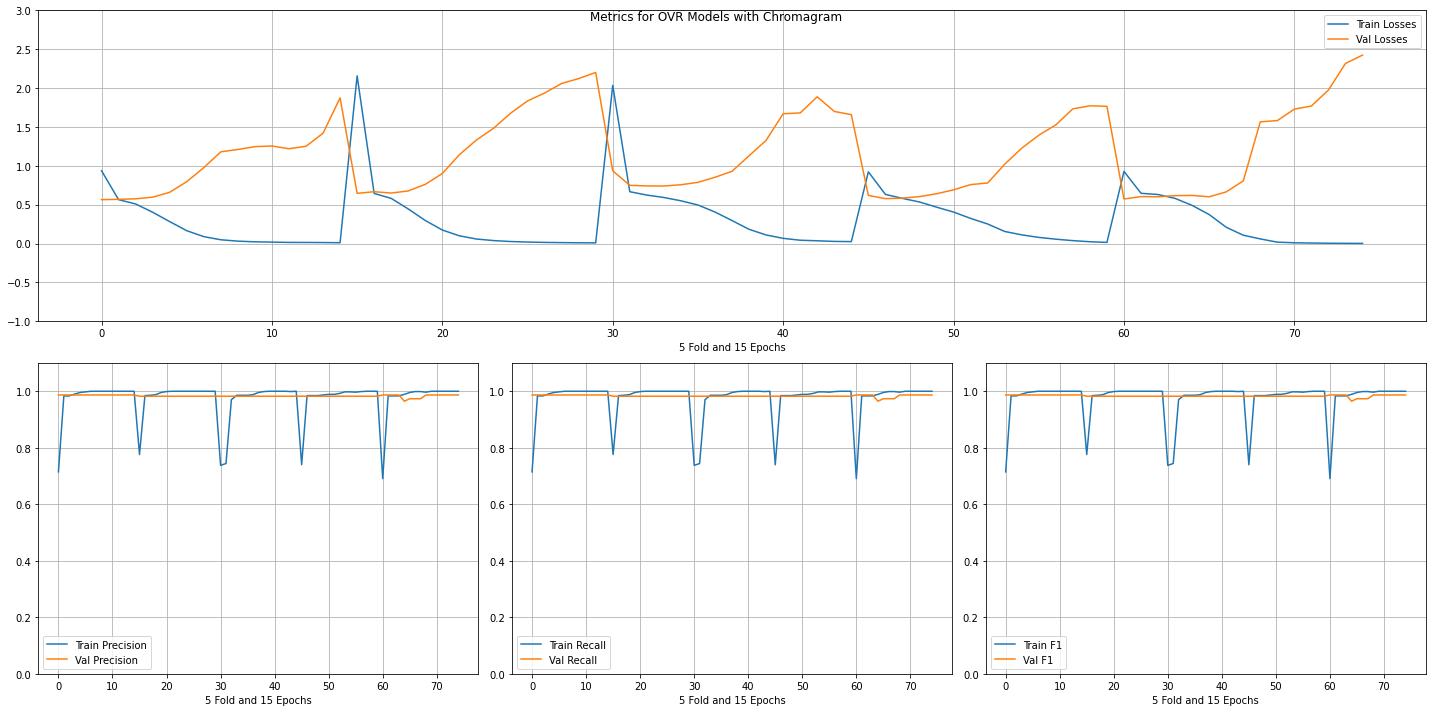

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.714599       0.986842  ...      0.937228           0.564449
8   1.000000       0.986842  ...      0.030350           1.210122
14  1.000000       0.986842  ...      0.010054           1.873919
13  1.000000       0.986842  ...      0.012230           1.418878
1   0.983535       0.986842  ...      0.564664           0.567982
..       ...            ...  ...           ...                ...
7   0.995609       0.982456  ...      0.295324           0.929153
5   0.995614       0.973568  ...      0.372540           0.601220
6   0.998904       0.973568  ...      0.209203           0.664457
7   0.998904       0.973568  ...      0.106651           0.804995
4   0.989035       0.964758  ...      0.490245           0.618939

[75 rows x 8 columns]
Training for ['ముఖారి'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.525369   10.35454545]
Epoch 1/15 : Training Loss: 0.811 / Validation Loss

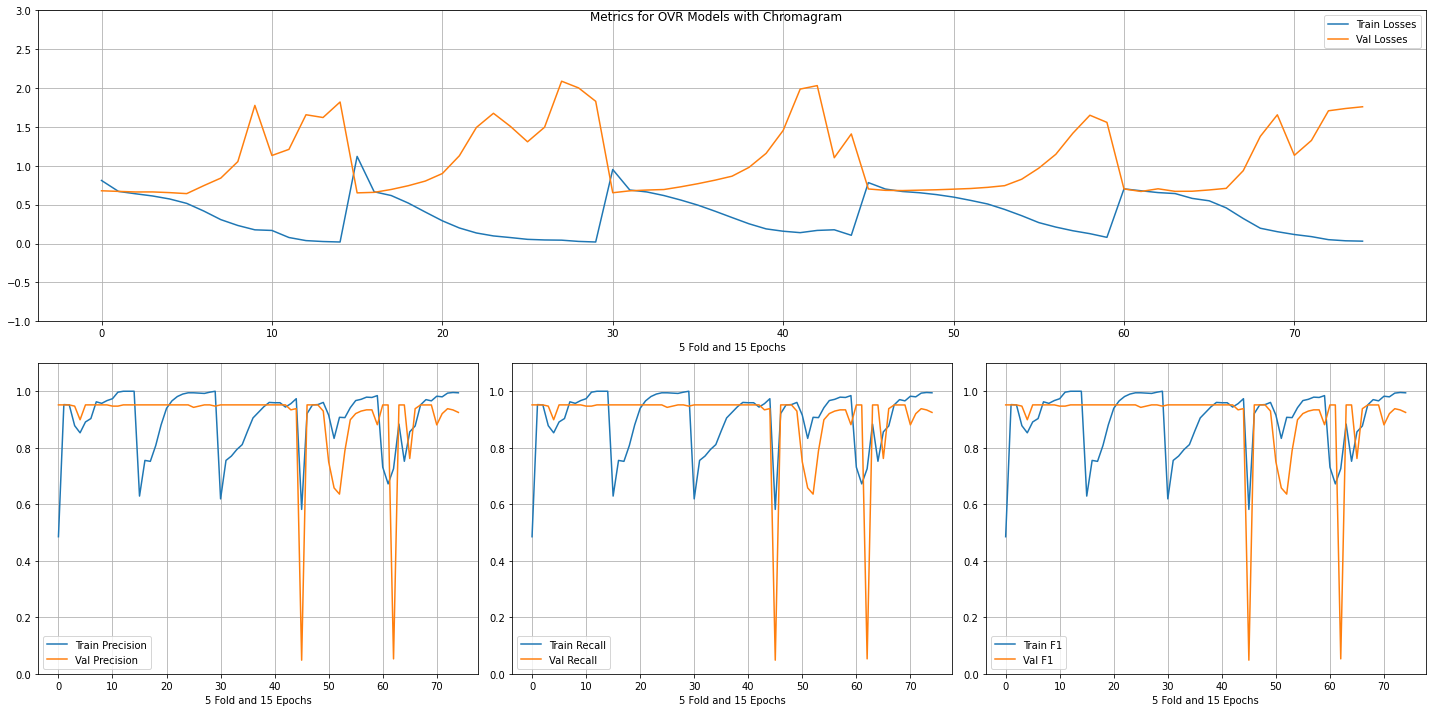

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.485181       0.951754  ...      0.811233           0.678540
7   0.981339       0.951754  ...      0.135466           1.493655
9   0.994512       0.951754  ...      0.076259           1.506632
12  0.992316       0.951754  ...      0.042906           2.088685
13  0.996707       0.951754  ...      0.026828           2.001965
..       ...            ...  ...           ...                ...
5   0.915477       0.750000  ...      0.597168           0.699303
6   0.833150       0.657895  ...      0.554753           0.707696
7   0.907794       0.635965  ...      0.508364           0.722705
2   0.725877       0.052863  ...      0.655345           0.704134
0   0.581778       0.048246  ...      0.783674           0.701924

[75 rows x 8 columns]
Training for ['రామక్రియ'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.52829314 9.33606557]
Epoch 1/15 : Training Loss: 0.808 / Validation Loss

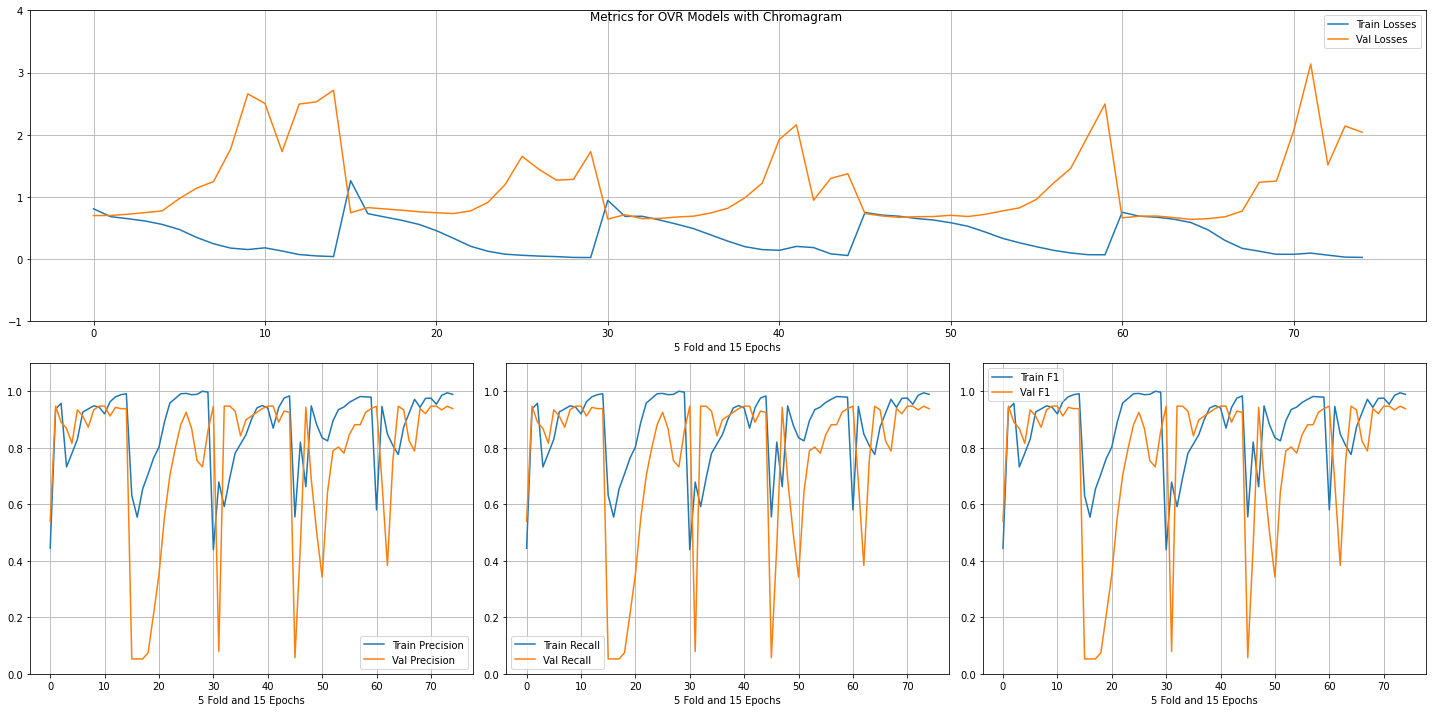

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.691548       0.947368  ...      0.629382           0.653655
9   0.944018       0.947368  ...      0.153062           2.656937
0   0.439078       0.947368  ...      0.943567           0.642524
1   0.937431       0.947368  ...      0.681853           0.700947
10  0.940724       0.947368  ...      0.140094           1.921939
..       ...            ...  ...           ...                ...
3   0.706915       0.074561  ...      0.621947           0.785011
0   0.555434       0.057018  ...      0.748644           0.732295
1   0.554336       0.052632  ...      0.730337           0.827599
0   0.631175       0.052632  ...      1.260262           0.743485
2   0.654226       0.052632  ...      0.675206           0.805970

[75 rows x 8 columns]
Training for ['లలిత'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54707012 5.81122449]
Epoch 1/15 : Training Loss: 0.759 / Validation Loss : 0

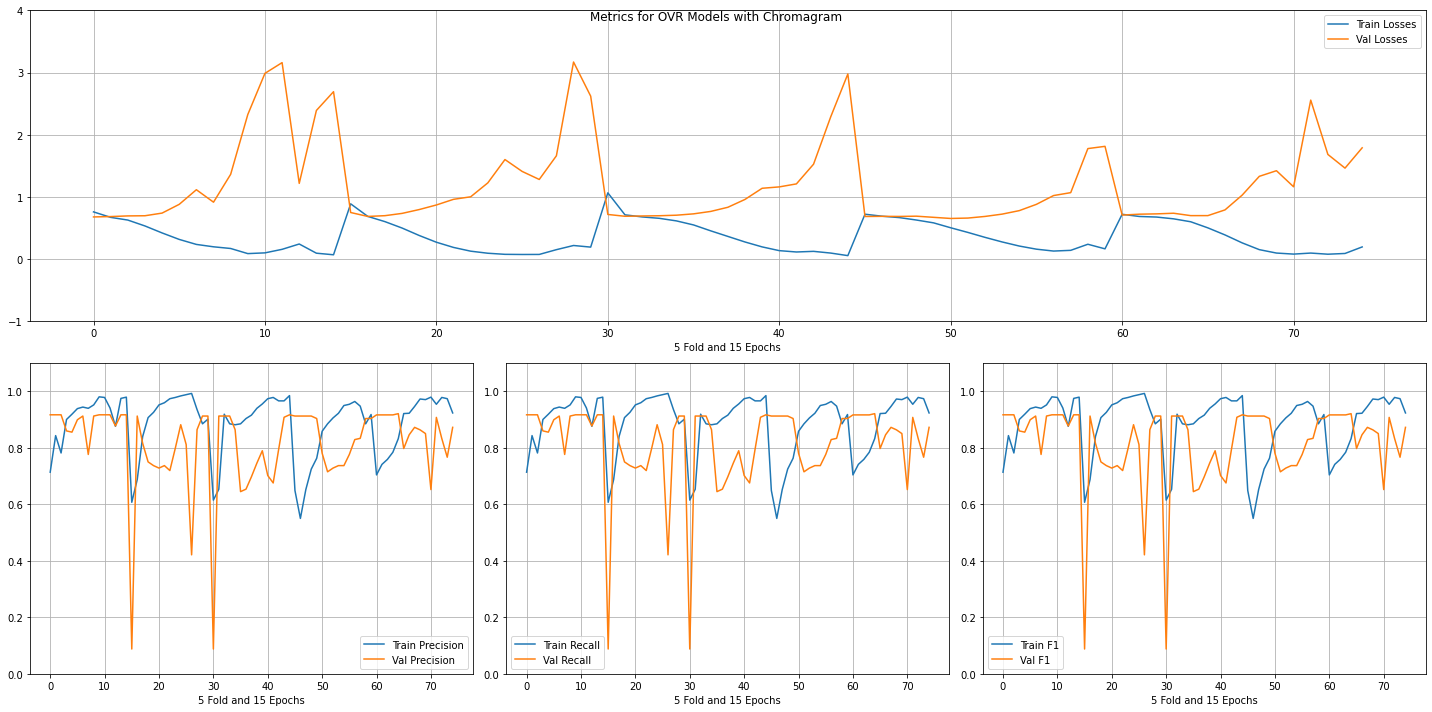

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.832237       0.920705  ...      0.599641           0.698372
0   0.713502       0.916667  ...      0.758598           0.677254
13  0.974753       0.916667  ...      0.094116           2.390078
2   0.781559       0.916667  ...      0.627120           0.693884
14  0.984632       0.916667  ...      0.054940           2.976967
..       ...            ...  ...           ...                ...
10  0.979167       0.651982  ...      0.079492           1.162415
5   0.884742       0.644737  ...      0.548626           0.726948
11  0.992316       0.421053  ...      0.074062           1.280232
0   0.607025       0.087719  ...      0.888102           0.748355
0   0.614709       0.087719  ...      1.064913           0.717211

[75 rows x 8 columns]
Training for ['వరాళి'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50984781 25.88636364]
Epoch 1/15 : Training Loss: 0.719 / Validation Loss 

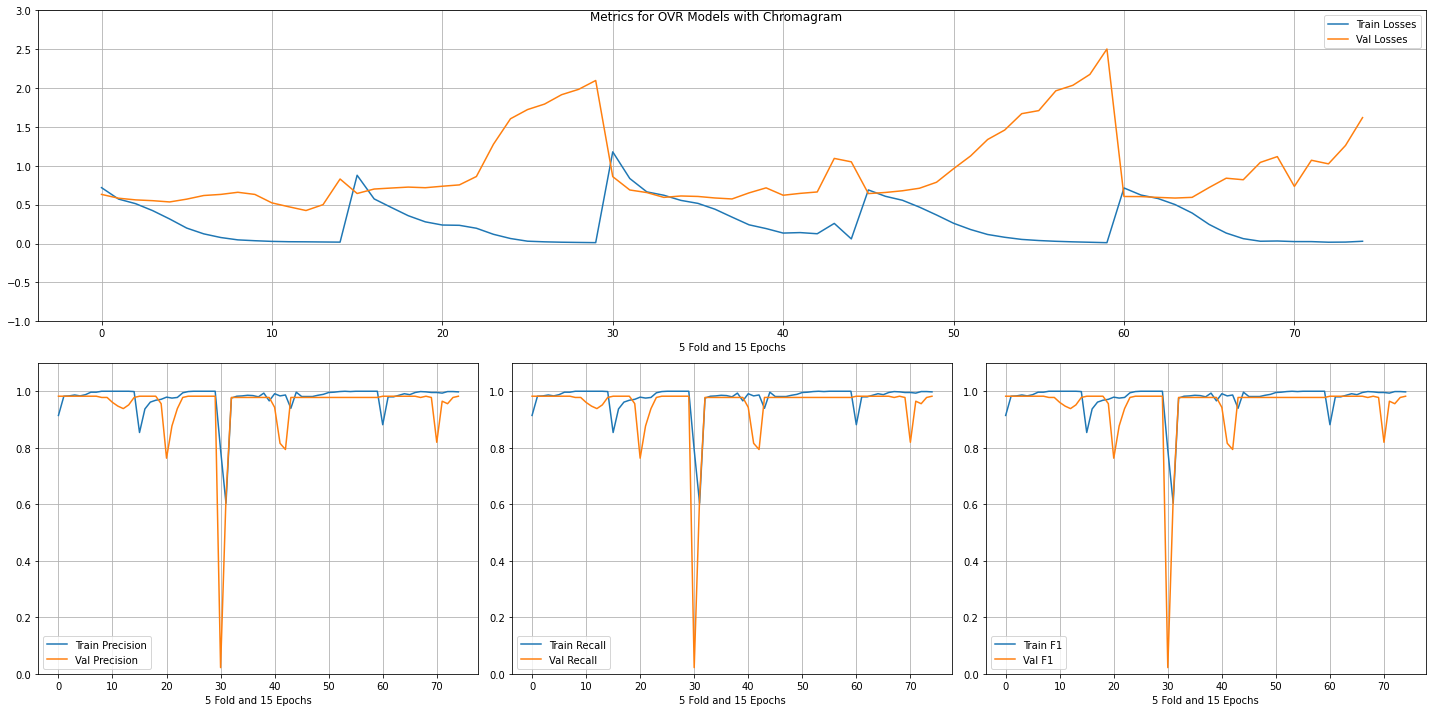

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.914380       0.982456  ...      0.718916           0.631826
11  1.000000       0.982456  ...      0.021510           1.794449
9   0.998902       0.982456  ...      0.064094           1.605496
12  1.000000       0.982456  ...      0.016546           1.915148
13  1.000000       0.982456  ...      0.013558           1.984016
..       ...            ...  ...           ...                ...
11  0.983535       0.815789  ...      0.140441           0.645188
12  0.986828       0.793860  ...      0.125514           0.663268
5   0.979144       0.763158  ...      0.237688           0.737053
1   0.603732       0.622807  ...      0.836468           0.688830
0   0.792536       0.021930  ...      1.179597           0.860520

[75 rows x 8 columns]
Training for ['శంకరాభరణం'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53174603 8.375     ]
Epoch 1/15 : Training Loss: 0.801 / Validation Los

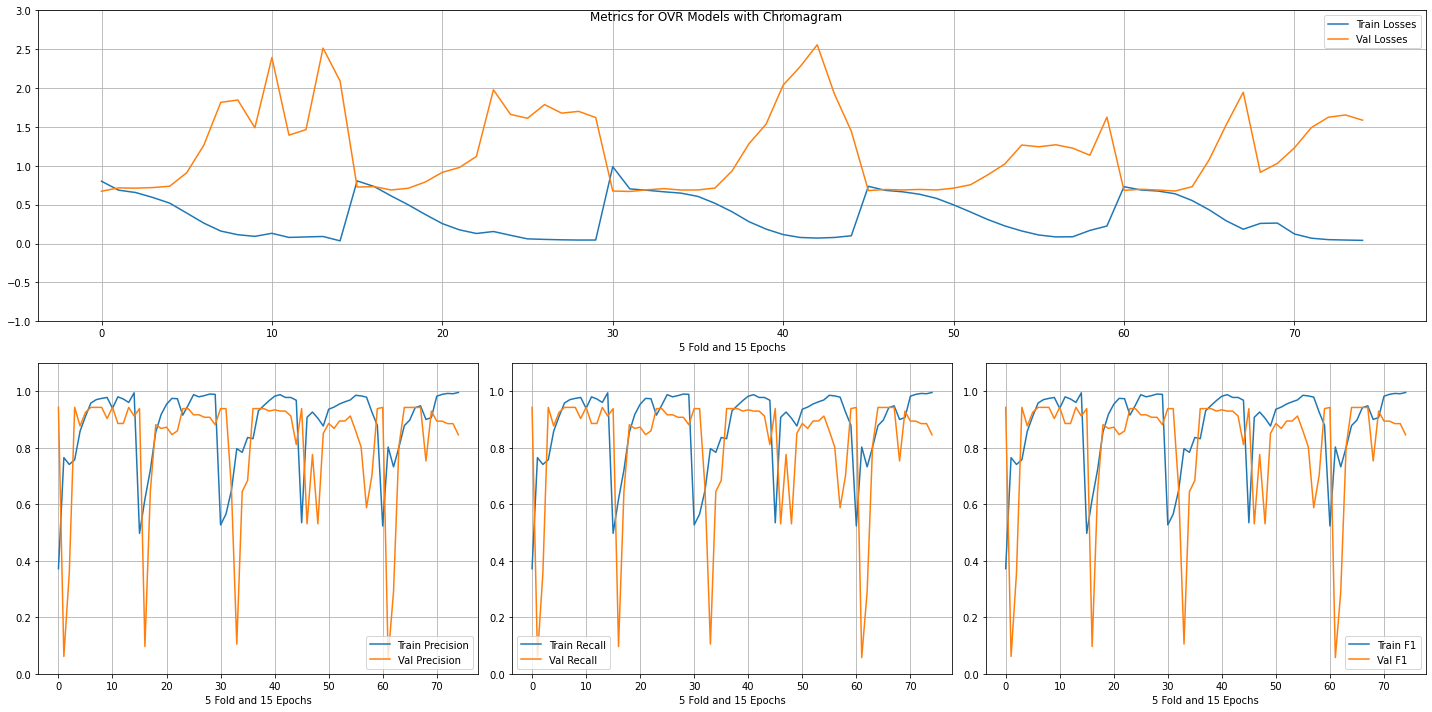

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.372119       0.942982  ...      0.801452           0.672685
6   0.958288       0.942982  ...      0.262836           1.263417
13  0.960483       0.942982  ...      0.090549           2.514904
8   0.974753       0.942982  ...      0.112966           1.846218
7   0.970362       0.942982  ...      0.160115           1.817090
..       ...            ...  ...           ...                ...
2   0.732456       0.290749  ...      0.675026           0.688098
3   0.796926       0.105263  ...      0.665523           0.706189
1   0.618002       0.096491  ...      0.733193           0.732022
1   0.765093       0.061404  ...      0.686477           0.715553
1   0.802632       0.057269  ...      0.688741           0.697893

[75 rows x 8 columns]
Training for ['శుద్ధవసంతం'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51491863 17.25757576]
Epoch 1/15 : Training Loss: 0.723 / Validation 

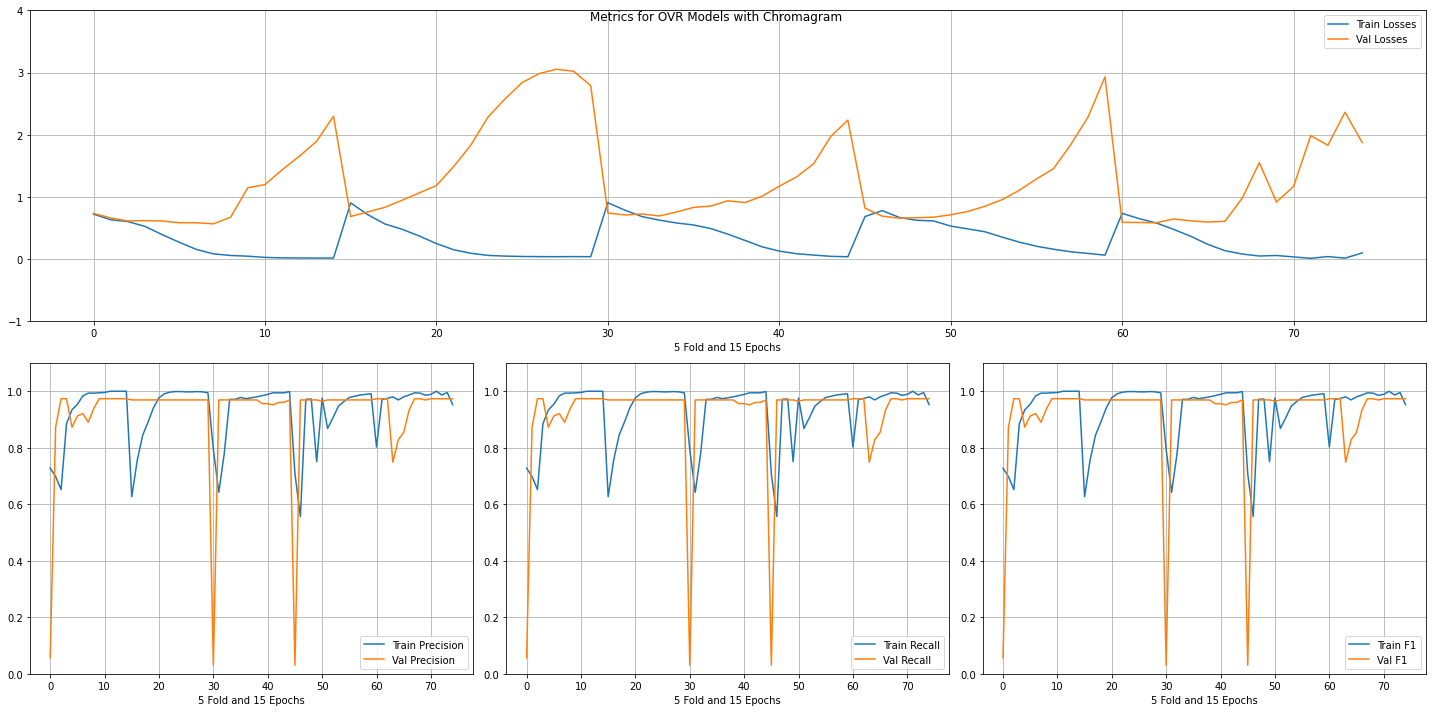

    train_f1  validation_f1  ...  train_losses  validation_losses
12  1.000000       0.973684  ...      0.016739           1.652988
2   0.652031       0.973684  ...      0.603281           0.613289
3   0.884742       0.973684  ...      0.525112           0.617501
14  1.000000       0.973684  ...      0.015625           2.298166
13  1.000000       0.973684  ...      0.016156           1.889565
..       ...            ...  ...           ...                ...
4   0.969298       0.828194  ...      0.366701           0.614900
3   0.980263       0.748899  ...      0.477075           0.644409
0   0.727772       0.057018  ...      0.722795           0.734211
0   0.708013       0.030702  ...      0.683453           0.819309
0   0.793633       0.030702  ...      0.906853           0.739739

[75 rows x 8 columns]
Training for ['శ్రీరాగం'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53026071 8.76153846]
Epoch 1/15 : Training Loss: 0.764 / Validation Loss

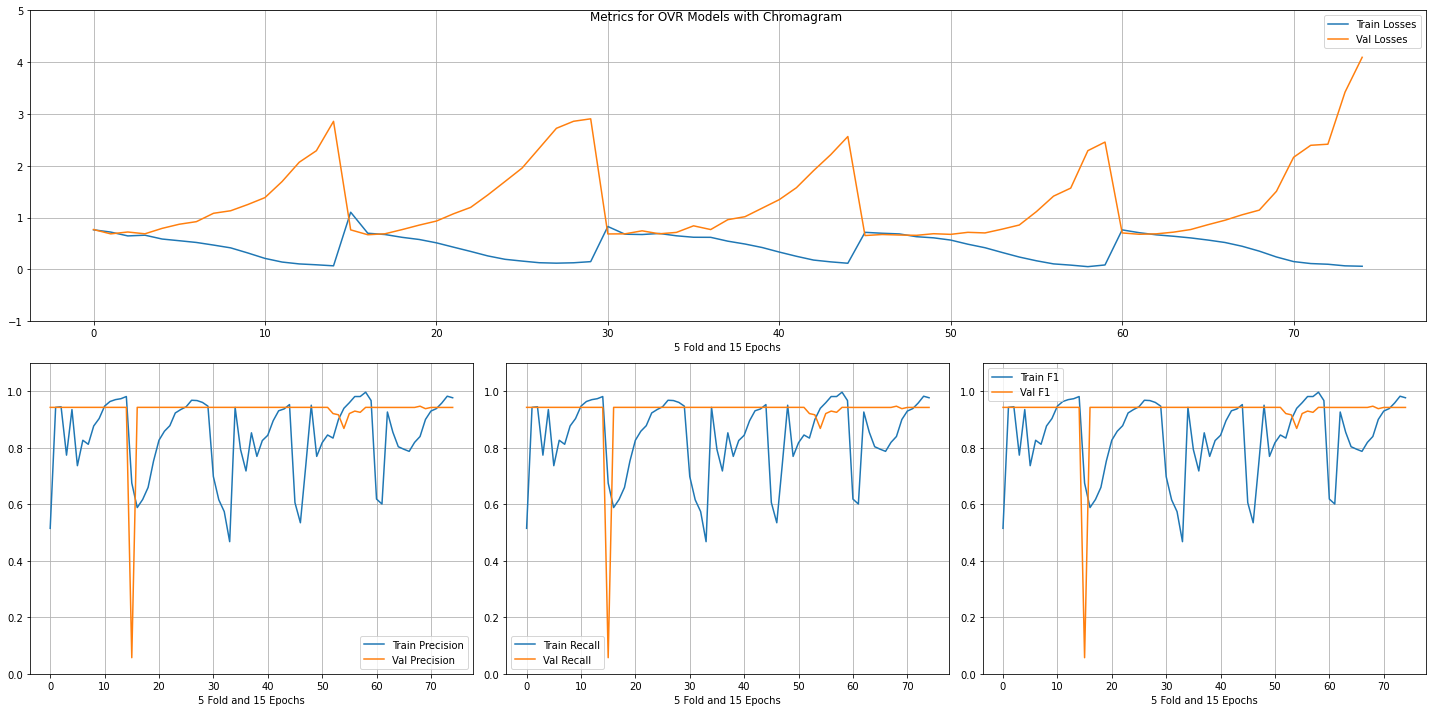

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.839912       0.947137  ...      0.352359           1.144420
0   0.514819       0.942982  ...      0.764099           0.769547
11  0.895719       0.942982  ...      0.253254           1.576846
0   0.698134       0.942982  ...      0.828252           0.684274
1   0.615807       0.942982  ...      0.679483           0.686525
..       ...            ...  ...           ...                ...
10  0.959385       0.921053  ...      0.166343           1.115657
7   0.834248       0.921053  ...      0.418425           0.704076
8   0.900110       0.916667  ...      0.326758           0.776920
9   0.939627       0.868421  ...      0.238518           0.856961
0   0.675082       0.057018  ...      1.104169           0.763295

[75 rows x 8 columns]
Training for ['సామంతం'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54238095 6.3988764 ]
Epoch 1/15 : Training Loss: 0.752 / Validation Loss :

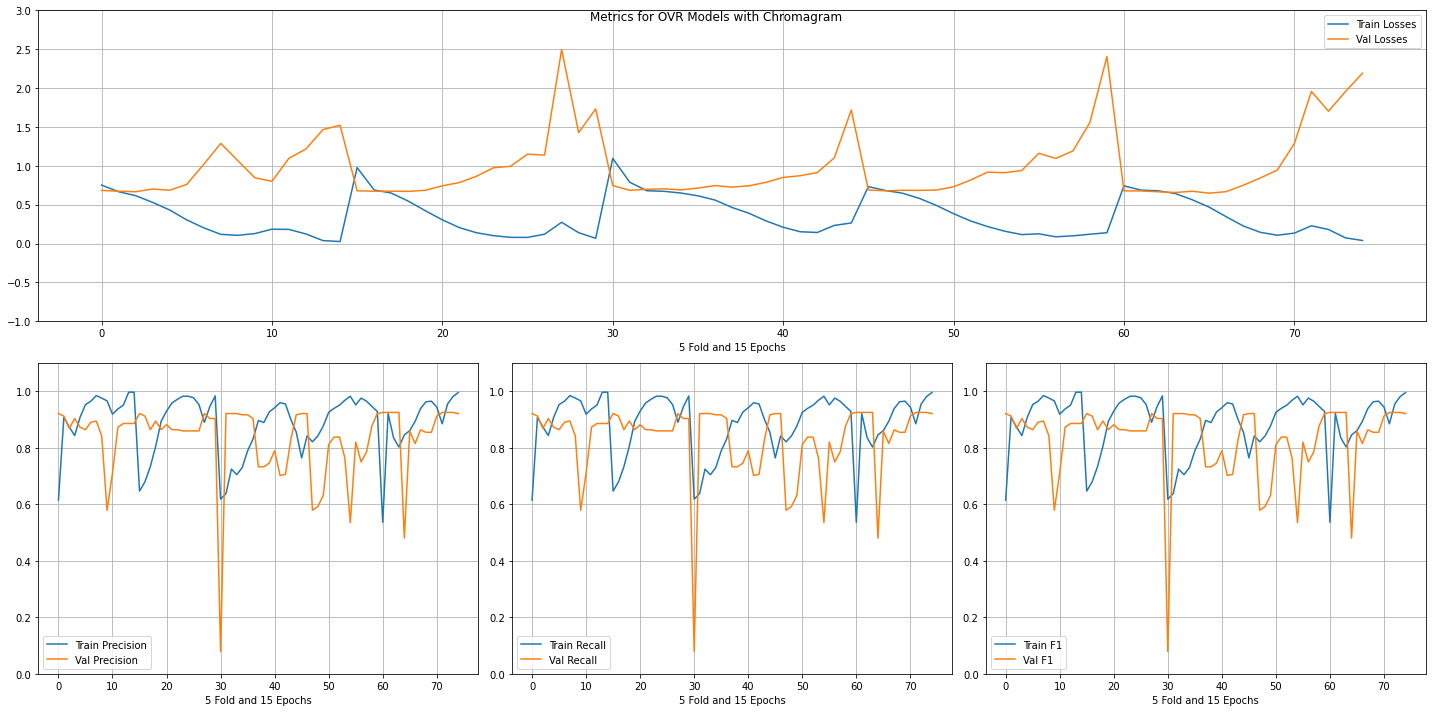

    train_f1  validation_f1  ...  train_losses  validation_losses
13  0.981360       0.925110  ...      0.072514           1.956250
12  0.955044       0.925110  ...      0.180204           1.702630
11  0.884868       0.925110  ...      0.228201           1.957543
3   0.802632       0.925110  ...      0.643867           0.656094
2   0.835526       0.925110  ...      0.677987           0.665639
..       ...            ...  ...           ...                ...
9   0.965971       0.578947  ...      0.127485           0.846166
2   0.821076       0.578947  ...      0.647665           0.684792
9   0.982437       0.535088  ...      0.114517           0.939412
4   0.845395       0.480176  ...      0.563580           0.672620
0   0.618002       0.078947  ...      1.095444           0.745692

[75 rows x 8 columns]
Training for ['సాళంగం'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 0.738 / Validation Loss

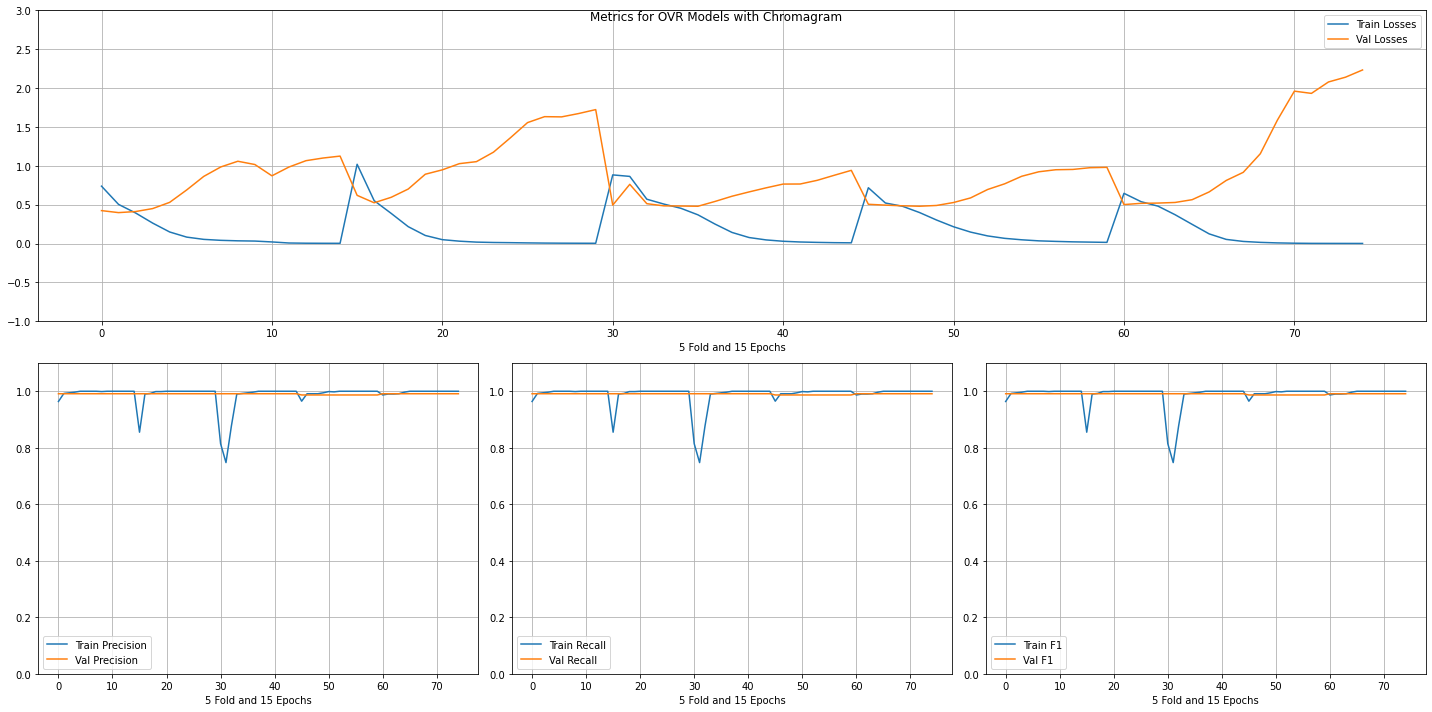

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.963776       0.991228  ...      0.738104           0.423256
4   0.992316       0.991228  ...      0.453109           0.482446
10  1.000000       0.991228  ...      0.007713           1.555895
11  1.000000       0.991228  ...      0.005397           1.632390
12  1.000000       0.991228  ...      0.004087           1.629607
..       ...            ...  ...           ...                ...
3   0.991218       0.986842  ...      0.398717           0.479582
2   0.991218       0.986842  ...      0.479444           0.485182
1   0.991218       0.986842  ...      0.521125           0.493721
0   0.964874       0.986842  ...      0.717535           0.504671
4   0.994512       0.986842  ...      0.302313           0.489497

[75 rows x 8 columns]
Training for ['సాళంగనాట'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54497608 6.05851064]
Epoch 1/15 : Training Loss: 0.732 / Validation Loss

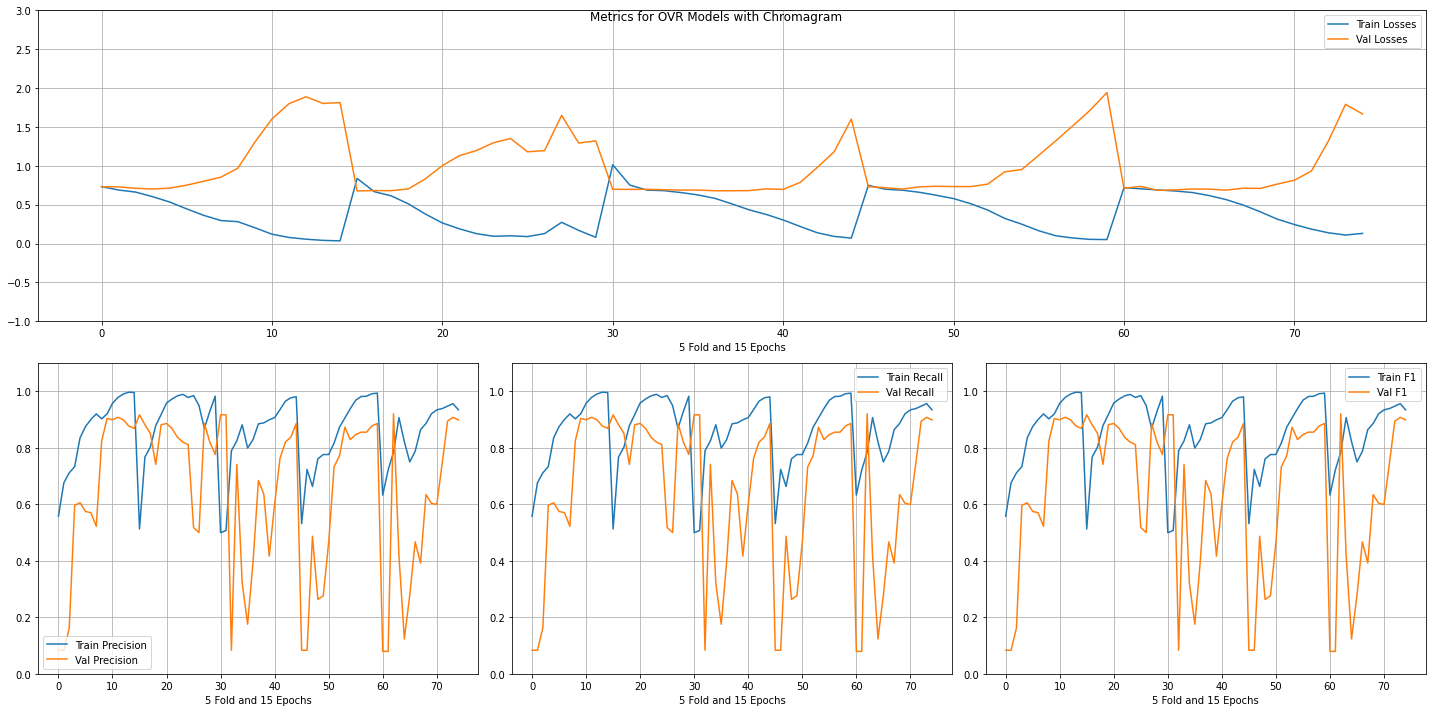

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.783991       0.920705  ...      0.689027           0.684049
0   0.512623       0.916667  ...      0.837365           0.676070
1   0.507135       0.916667  ...      0.752410           0.696040
0   0.499451       0.916667  ...      1.013470           0.697795
11  0.978046       0.907895  ...      0.077715           1.799112
..       ...            ...  ...           ...                ...
1   0.723381       0.083333  ...      0.698235           0.718083
0   0.531284       0.083333  ...      0.747903           0.730998
0   0.557629       0.083333  ...      0.732418           0.730283
0   0.632675       0.079295  ...      0.718552           0.711330
1   0.721491       0.079295  ...      0.703859           0.735028

[75 rows x 8 columns]


In [29]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, ChromaDataset, ChromaRaga, "OVR Models with Chromagram", labels, le.classes_, lbl_encoder=le, lr=1e-3, epochs=15, n_folds=5, feature='chroma')

In [30]:
for k in ovr_res:
  print(le.inverse_transform([k]))
  print(results_to_df(ovr_res[k]).head())

['ఆహిరి']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.669594       0.960526  ...      0.808368           0.664853
6   0.960483       0.960526  ...      0.451188           0.867116
12  0.997805       0.960526  ...      0.028800           2.445186
13  0.998902       0.960526  ...      0.023986           2.708217
14  0.998902       0.960526  ...      0.024495           2.855278

[5 rows x 8 columns]
['కన్నడగౌళ']
    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.992316       0.986842  ...      0.288993           0.518871
12  1.000000       0.986842  ...      0.021548           1.343679
0   0.664105       0.986842  ...      1.338848           0.593826
14  1.000000       0.986842  ...      0.007672           1.549228
3   0.767289       0.986842  ...      0.692339           0.577195

[5 rows x 8 columns]
['కాంబోది']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.994518       0.986784  ...      0.034294           3.3979

# Mapping each Raga with Janaka Ragam

In [31]:
janaka_raga_map ={'లలిత':'Mayamalavagowla',
'సాళంగనాట':'Mayamalavagowla',
'సామంతం':'Naganandini',
'బౌళి':'Mayamalavagowla',
'శంకరాభరణం':'Shankarabharanam',
'శ్రీరాగం':'Kharaharapriya',
'రామక్రియ':'Mayamalavagowla',
'ముఖారి':'Kharaharapriya',
'పాడి':'Mayamalavagowla',
'ఆహిరి':'Vakulabharanam',
'దేసాళం':'Unknown',
'దేవగాంధారి':'Shankarabharanam',
'శుద్ధవసంతం':'Shankarabharanam',
'భూపాలం':'Shubhapantuvarali',
'దేసాక్షి':'Harikambhoji',
'గుండుక్రియ':'Mayamalavagowla',
'భైరవి':'Natabhairavi',
'నాట':'Chalanata',
'వరాళి':'Jhalavarali',
'ధన్నాసి':'Hanumatodi',
'మలహరి':'Mayamalavagowla',
'కాంబోది':'Harikambhoji',
'మాళవిగౌళ':'Mayamalavagowla',
'మాళవి':'Harikambhoji',
'గుజ్జరి':'Unknown',
'కన్నడగౌళ':'Kharaharapriya',
'గౌళ':'Mayamalavagowla',
'బౌళిరామక్రియ':'Mayamalavagowla',
'నాదరామక్రియ':'Unknown',
'సాళంగం':'Kalyani'}

In [32]:
data['janaka_ragam'] = data.apply(lambda x:janaka_raga_map[x['Ragam']],axis=1)

In [33]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

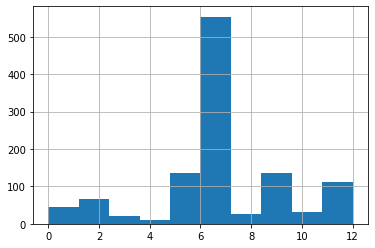

In [34]:
data['JanakaRagamCode'].hist()

In [40]:
class ChromaJanakaRagaDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 1876:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(12,1876-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['chroma'].iloc[x] for x in train_ids]
      test_vals = [data['chroma'].iloc[x] for x in test_ids]
      train_data = ChromaJanakaRagaDataset(train_lbls, train_vals)
      test_data = ChromaJanakaRagaDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 1.091 / Validation Loss : 0.684 [Time Taken : 0.205117 seconds]
Epoch 2/15 : Training Loss: 0.621 / Validation Loss : 0.656 [Time Taken : 0.182981 seconds]
Epoch 3/15 : Training Loss: 0.567 / Validation Loss : 0.673 [Time Taken : 0.175436 seconds]
Epoch 4/15 : Training Loss: 0.501 / Validation Loss : 0.678 [Time Taken : 0.17858 seconds]
Epoch 5/15 : Training Loss: 0.430 / Validation Loss : 0.696 [Time Taken : 0.185128 seconds]
Epoch 6/15 : Training Loss: 0.347 / Validation Loss : 0.735 [Time Taken : 0.181925 seconds]
Epoch 7/15 : Training Loss: 0.258 / Validation Loss : 0.794 [Time Taken : 0.182525 seconds]
Epoch 8/15 : Training Loss: 0.185 / Validation Loss : 0.923 [Time Taken : 0.174691 seconds]
Epoch 9/15 : Training Loss: 0.128 / Validation Loss : 1.195 [Time Taken : 0.176074 seconds]
Epoch 10/15 : Training Loss: 0.081 /

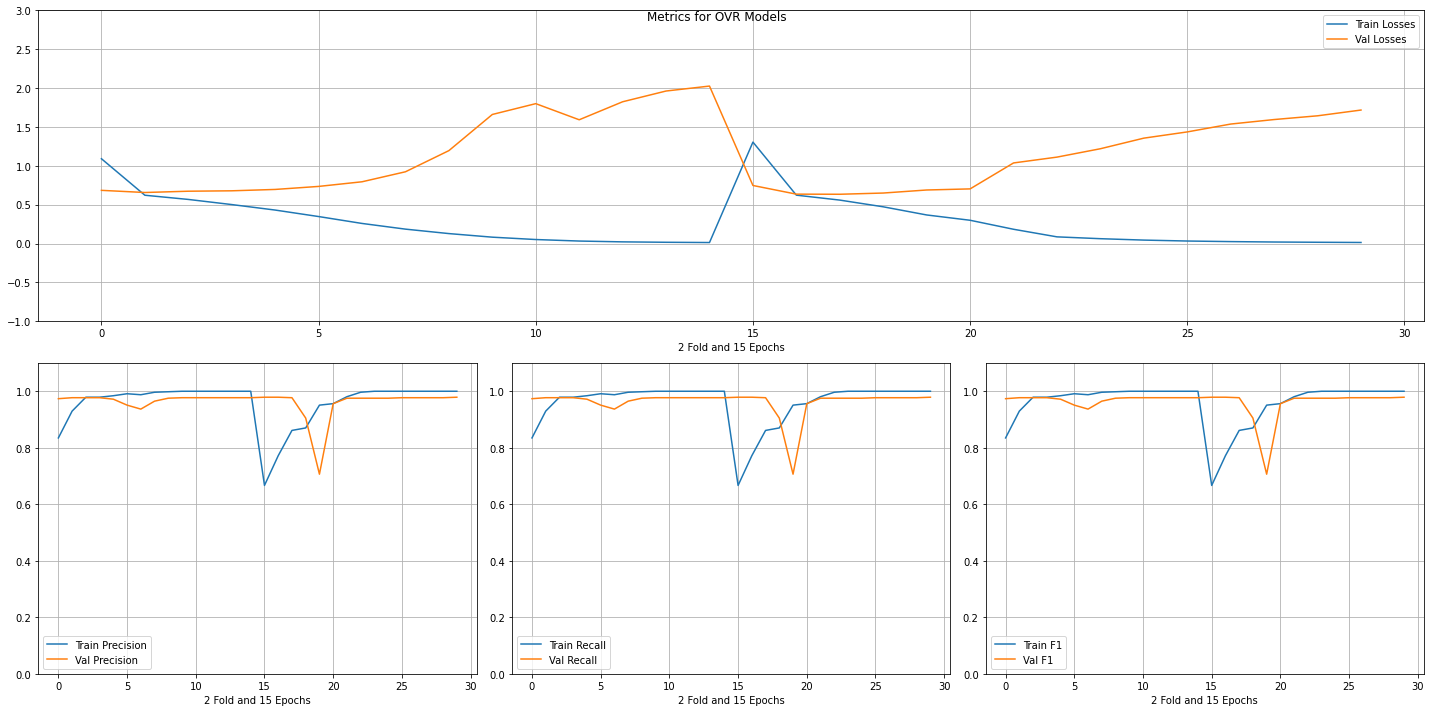

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.666667       0.978910  ...      1.305013           0.746656
1   0.771930       0.978910  ...      0.622104           0.635137
14  1.000000       0.978910  ...      0.013232           1.717571
3   0.978910       0.977193  ...      0.501093           0.678193
10  1.000000       0.977193  ...      0.051088           1.799904
1   0.929701       0.977193  ...      0.621166           0.656342
14  1.000000       0.977193  ...      0.012468           2.026068
13  1.000000       0.977193  ...      0.015725           1.962382
12  1.000000       0.977193  ...      0.021051           1.824072
11  1.000000       0.977193  ...      0.031569           1.592393
2   0.978910       0.977193  ...      0.567119           0.672898
9   1.000000       0.977193  ...      0.081426           1.660607
13  1.000000       0.977153  ...      0.015883           1.643434
12  1.000000       0.977153  ...      0.019109           1.595308
11  1.0000

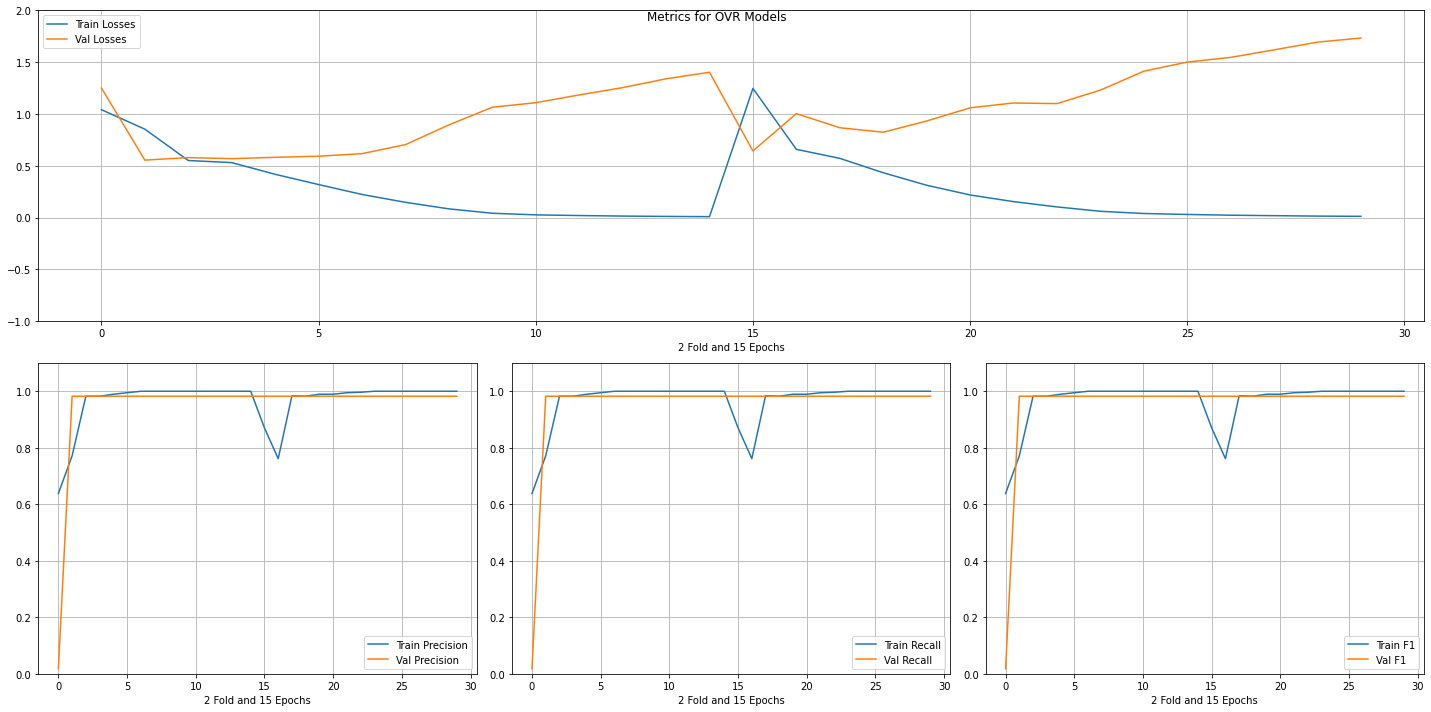

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.982456  ...      0.019940           1.184219
9   1.000000       0.982456  ...      0.042019           1.065373
1   0.771529       0.982456  ...      0.853619           0.554910
14  1.000000       0.982456  ...      0.009067           1.403053
13  1.000000       0.982456  ...      0.011438           1.339765
12  1.000000       0.982456  ...      0.014667           1.254377
10  1.000000       0.982456  ...      0.026351           1.108853
8   1.000000       0.982456  ...      0.084359           0.894535
7   1.000000       0.982456  ...      0.147590           0.704402
6   1.000000       0.982456  ...      0.223341           0.617337
5   0.994728       0.982456  ...      0.318990           0.592651
4   0.989455       0.982456  ...      0.417919           0.581913
3   0.982425       0.982456  ...      0.530841           0.569108
2   0.982425       0.982456  ...      0.551111           0.579182
11  1.0000

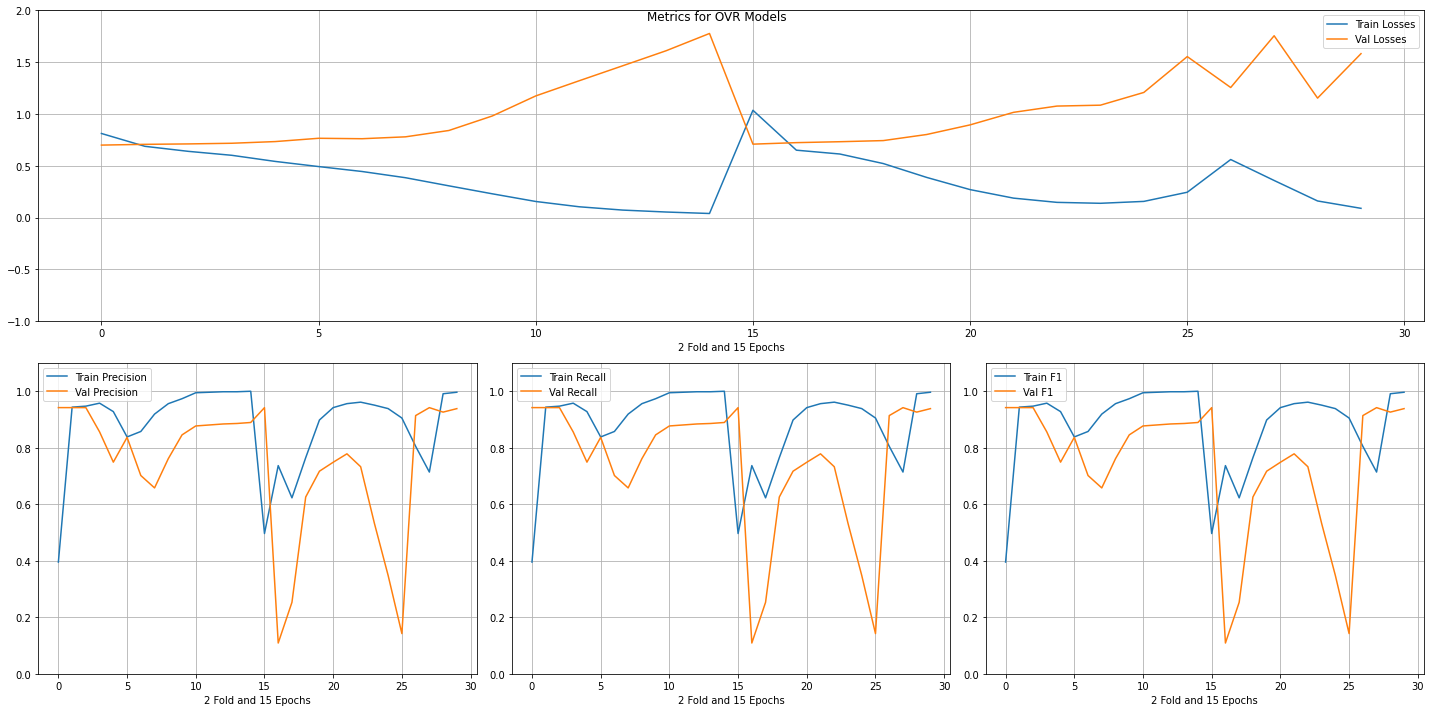

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.395431       0.942105  ...      0.812007           0.699840
1   0.943761       0.942105  ...      0.688095           0.707124
2   0.947276       0.942105  ...      0.639534           0.711218
12  0.714035       0.942004  ...      0.358309           1.755227
0   0.496491       0.942004  ...      1.035997           0.708971
14  0.996491       0.938489  ...      0.089509           1.582500
13  0.991228       0.926186  ...      0.160581           1.153318
11  0.805263       0.913884  ...      0.560489           1.255680
14  1.000000       0.889474  ...      0.039647           1.777225
13  0.998243       0.885965  ...      0.053876           1.610427
12  0.998243       0.884211  ...      0.072565           1.465282
11  0.996485       0.880702  ...      0.104484           1.320916
10  0.994728       0.877193  ...      0.155602           1.174543
3   0.957821       0.856140  ...      0.601373           0.717610
9   0.9736

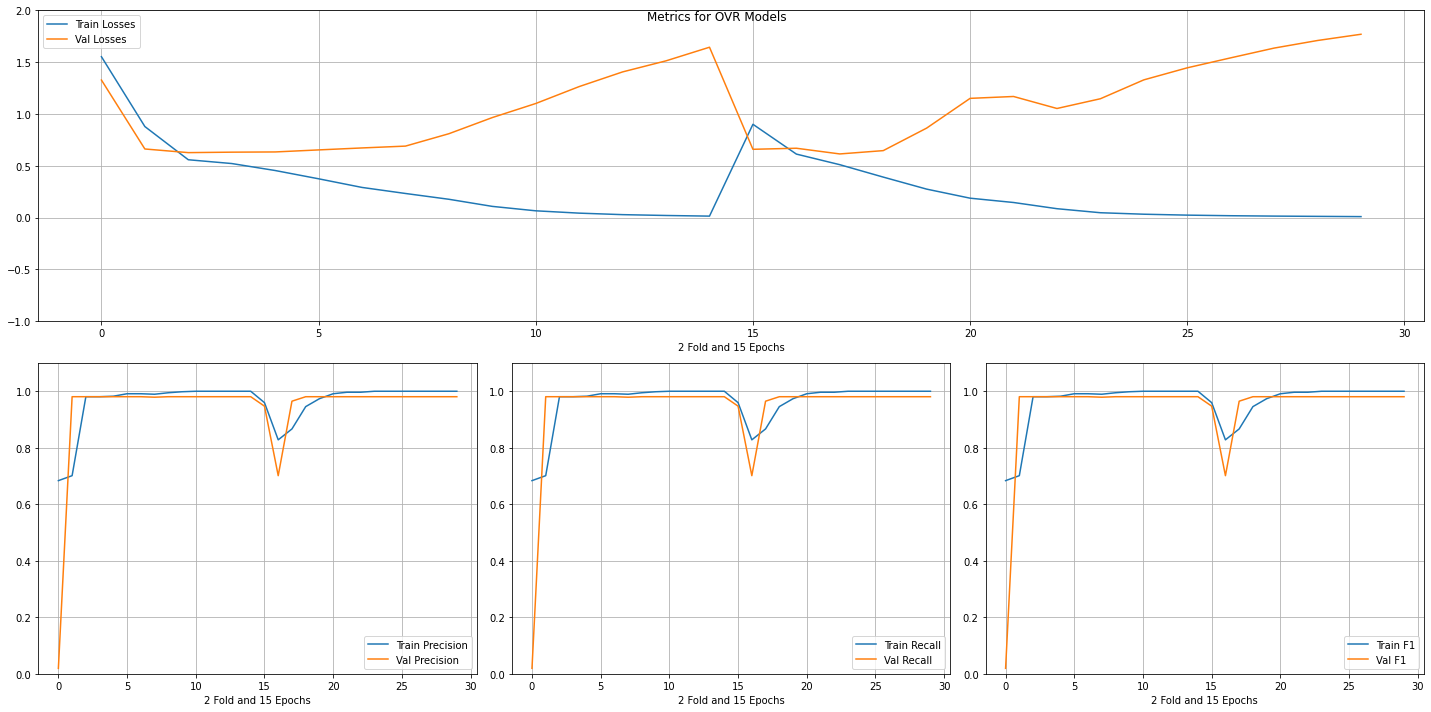

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.980702  ...      0.020408           1.513248
8   0.994728       0.980702  ...      0.176870           0.809725
1   0.701230       0.980702  ...      0.878920           0.662358
14  1.000000       0.980702  ...      0.014228           1.644575
12  1.000000       0.980702  ...      0.028534           1.406369
11  1.000000       0.980702  ...      0.043005           1.264773
10  1.000000       0.980702  ...      0.065543           1.101366
9   0.998243       0.980702  ...      0.108233           0.965625
6   0.991213       0.980702  ...      0.291182           0.672376
5   0.991213       0.980702  ...      0.374602           0.653339
4   0.982425       0.980702  ...      0.454486           0.633723
3   0.980668       0.980702  ...      0.521845           0.631571
2   0.980668       0.980702  ...      0.558396           0.627198
10  1.000000       0.980668  ...      0.023823           1.445837
5   0.9912

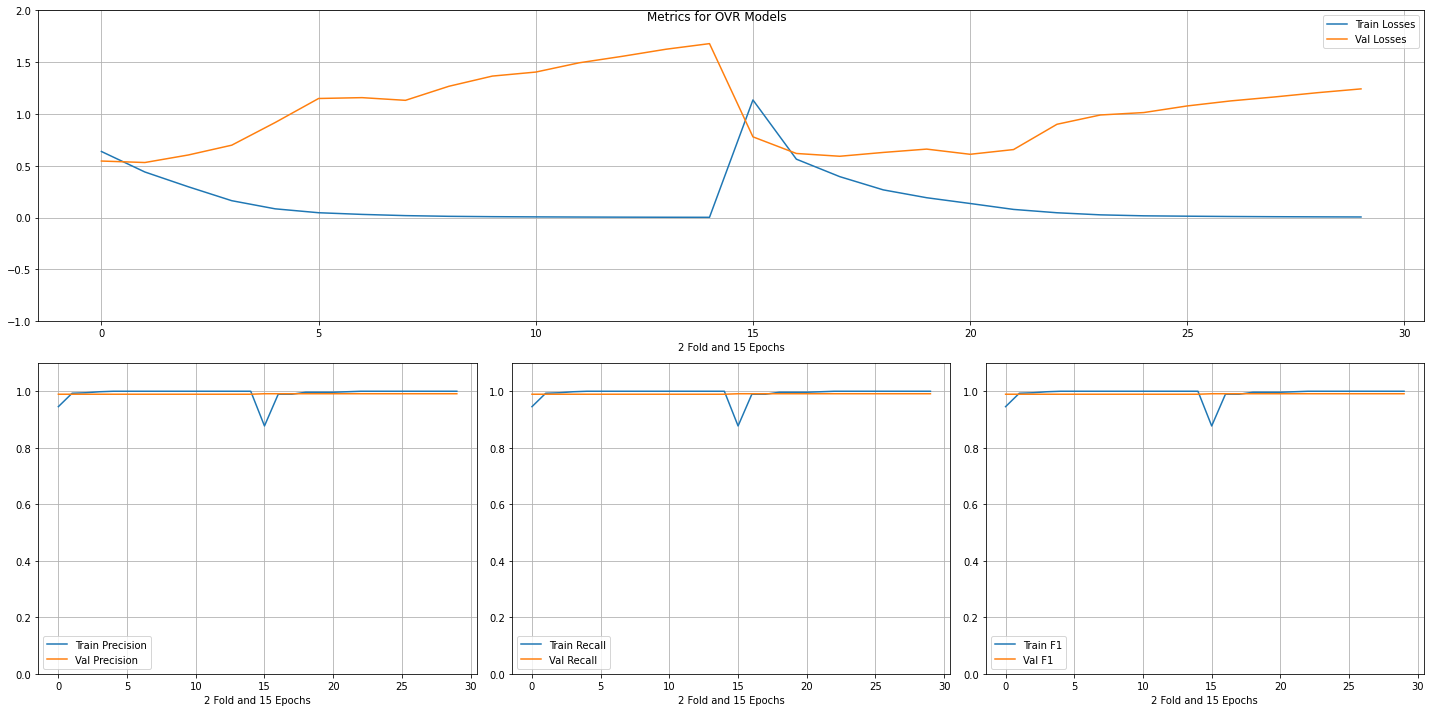

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.877193       0.991213  ...      1.135744           0.779564
1   0.989474       0.991213  ...      0.564010           0.619020
13  1.000000       0.991213  ...      0.007242           1.205748
12  1.000000       0.991213  ...      0.008569           1.164170
11  1.000000       0.991213  ...      0.010575           1.126308
10  1.000000       0.991213  ...      0.013569           1.077889
9   1.000000       0.991213  ...      0.017152           1.014005
8   1.000000       0.991213  ...      0.026528           0.990529
7   1.000000       0.991213  ...      0.046743           0.900770
6   0.998246       0.991213  ...      0.078980           0.656728
5   0.996491       0.991213  ...      0.136183           0.611112
4   0.996491       0.991213  ...      0.191845           0.661166
3   0.996491       0.991213  ...      0.267756           0.628986
2   0.989474       0.991213  ...      0.395145           0.592107
14  1.0000

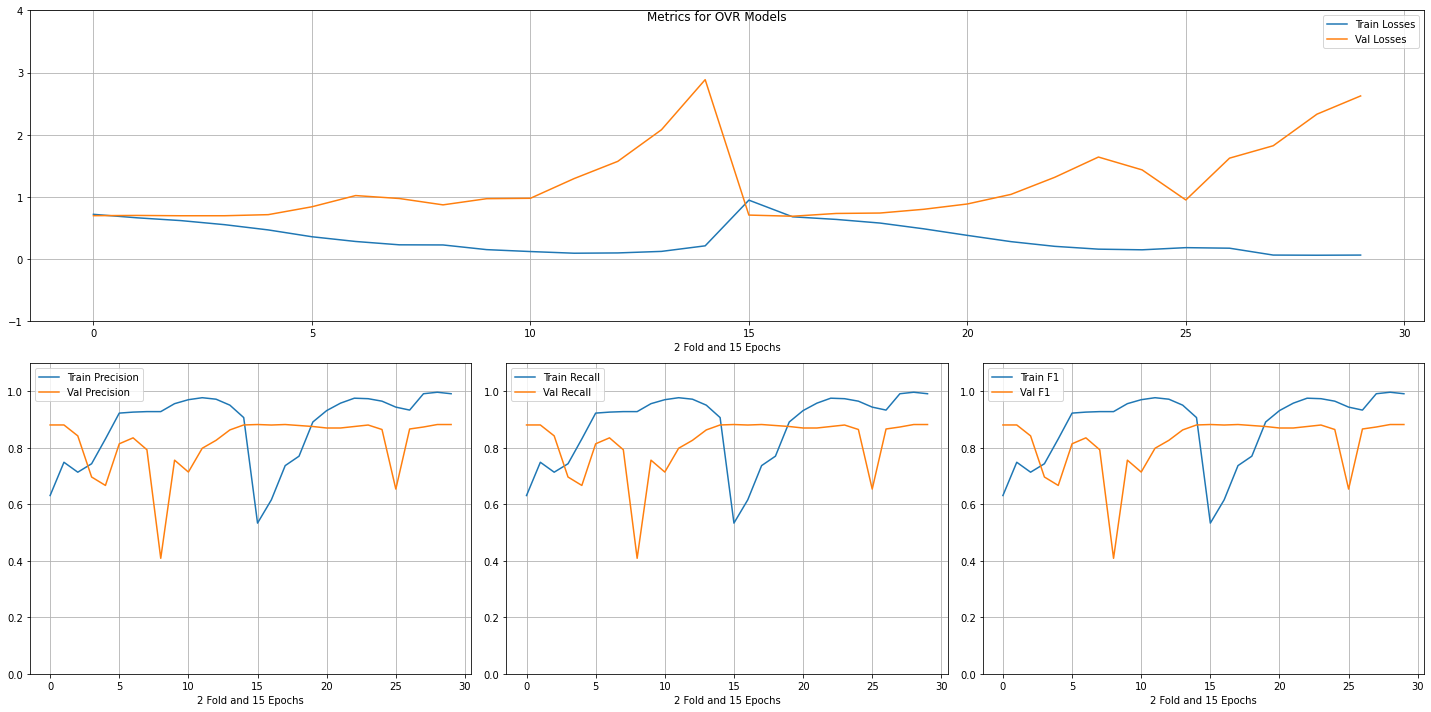

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.533333       0.882250  ...      0.947452           0.707182
2   0.736842       0.882250  ...      0.637343           0.733441
13  0.996491       0.882250  ...      0.061282           2.330385
14  0.991228       0.882250  ...      0.063678           2.624066
0   0.630931       0.880702  ...      0.719290           0.697599
14  0.906854       0.880702  ...      0.212453           2.885876
1   0.748682       0.880702  ...      0.663241           0.701453
1   0.615789       0.880492  ...      0.679459           0.688522
8   0.973684       0.880492  ...      0.159006           1.640906
3   0.770175       0.878735  ...      0.579008           0.740128
7   0.975439       0.875220  ...      0.204319           1.315058
4   0.891228       0.875220  ...      0.486269           0.800368
12  0.991228       0.873462  ...      0.063852           1.822782
5   0.931579       0.869947  ...      0.380643           0.885896
6   0.9578

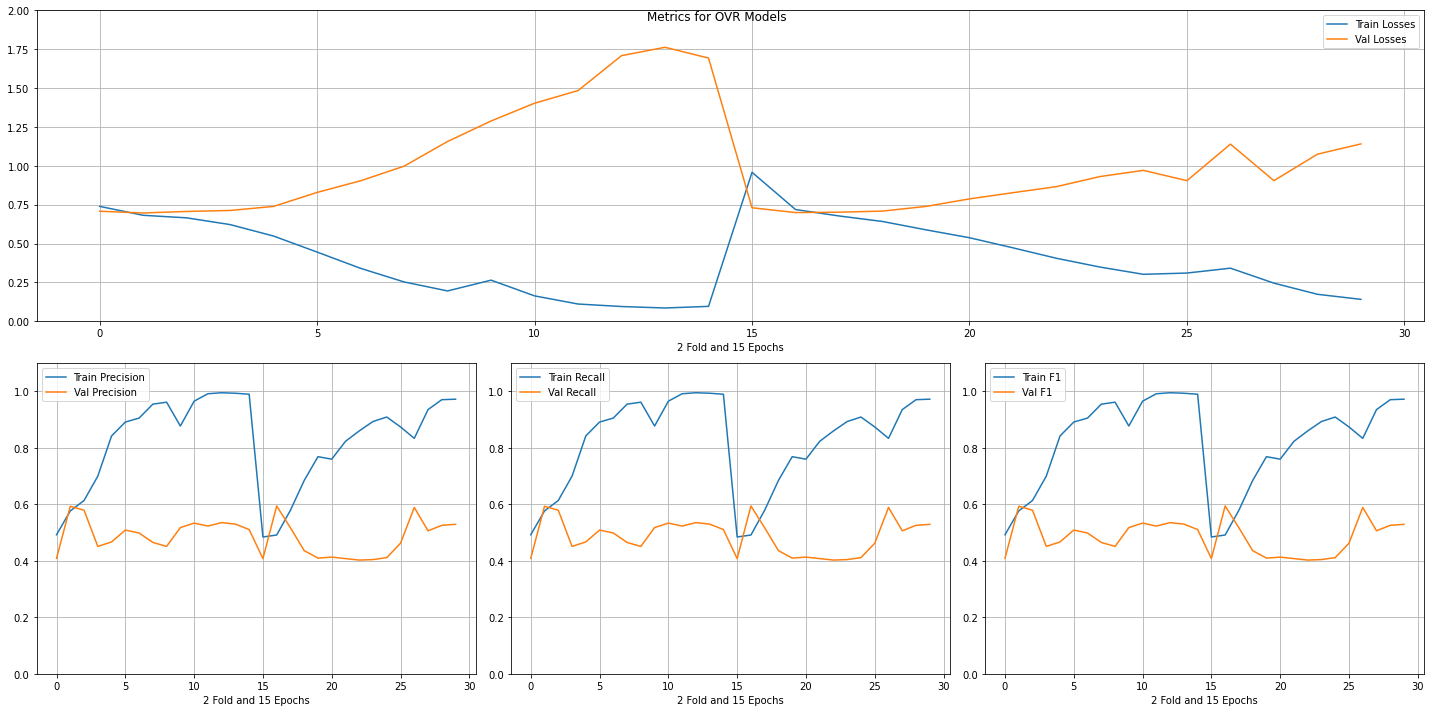

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.491228       0.594025  ...      0.718527           0.699057
1   0.576450       0.592982  ...      0.681538           0.696436
11  0.833333       0.588752  ...      0.341231           1.139366
2   0.613357       0.578947  ...      0.665107           0.706298
12  0.994728       0.535088  ...      0.094474           1.708910
10  0.964851       0.533333  ...      0.162934           1.402678
13  0.992970       0.529825  ...      0.085010           1.762625
14  0.971930       0.528998  ...      0.140549           1.140894
13  0.970175       0.525483  ...      0.173166           1.074780
11  0.991213       0.522807  ...      0.110528           1.484035
9   0.876977       0.517544  ...      0.264145           1.288230
2   0.578947       0.516696  ...      0.677240           0.701475
14  0.989455       0.510526  ...      0.095444           1.693297
5   0.891037       0.508772  ...      0.444860           0.828624
12  0.9350

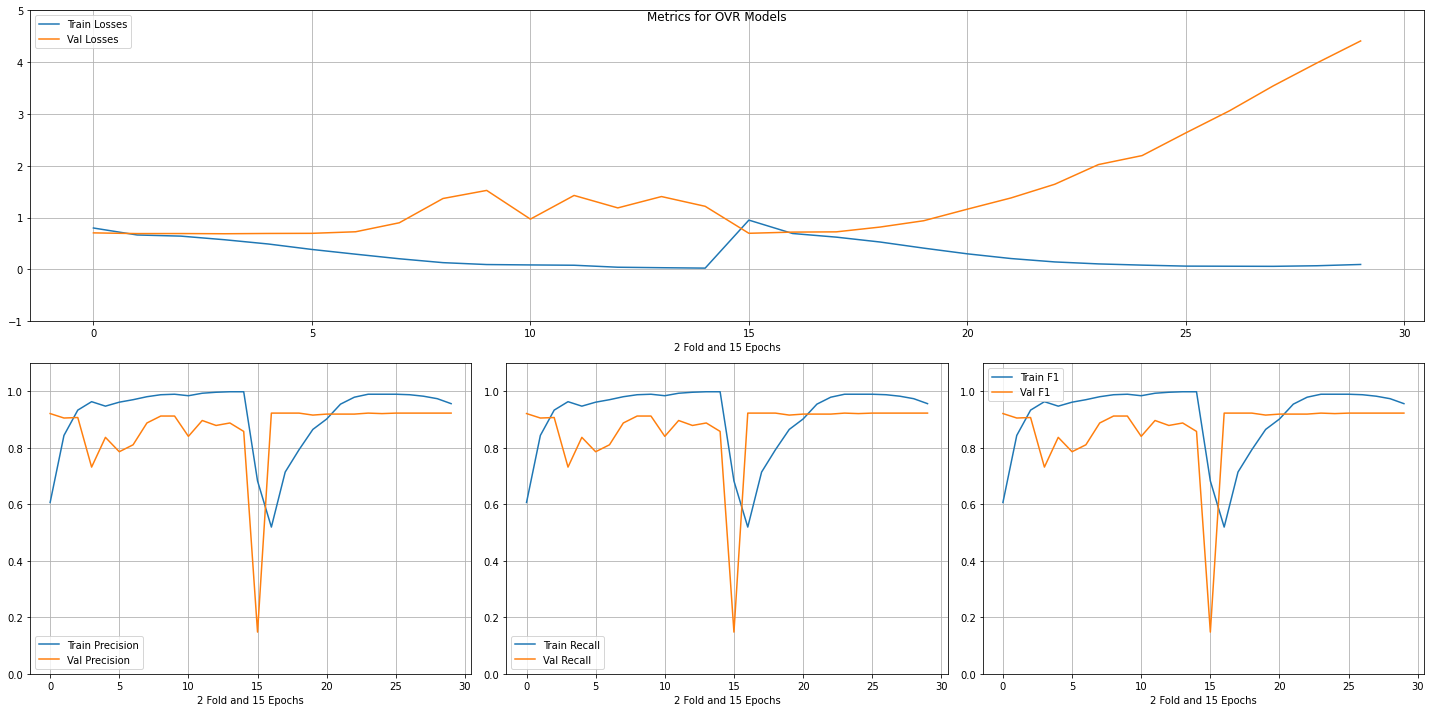

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.956140       0.922671  ...      0.095264           4.410165
1   0.519298       0.922671  ...      0.693008           0.719956
13  0.973684       0.922671  ...      0.070469           3.985404
12  0.982456       0.922671  ...      0.059331           3.542801
11  0.987719       0.922671  ...      0.061251           3.062067
10  0.989474       0.922671  ...      0.063347           2.635716
8   0.989474       0.922671  ...      0.106093           2.023643
3   0.792982       0.922671  ...      0.528926           0.817121
2   0.714035       0.922671  ...      0.622810           0.724825
0   0.606327       0.921053  ...      0.799148           0.705074
9   0.989474       0.920914  ...      0.082506           2.197333
5   0.901754       0.919156  ...      0.300531           1.162785
6   0.954386       0.919156  ...      0.209516           1.379790
7   0.978947       0.919156  ...      0.144282           1.643683
4   0.8649

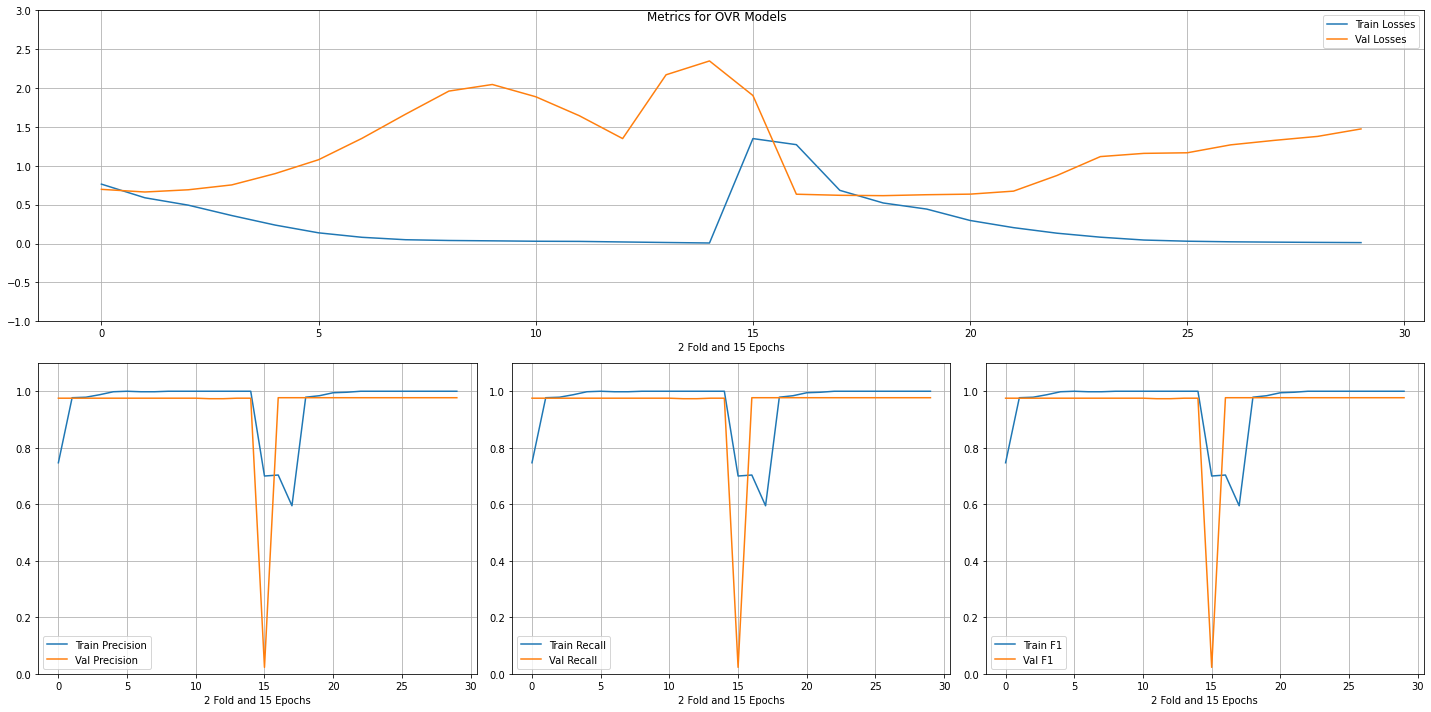

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977153  ...      0.011388           1.474481
13  1.000000       0.977153  ...      0.014209           1.378345
12  1.000000       0.977153  ...      0.017567           1.327087
11  1.000000       0.977153  ...      0.021794           1.269680
10  1.000000       0.977153  ...      0.029451           1.167630
9   1.000000       0.977153  ...      0.044562           1.159948
8   1.000000       0.977153  ...      0.081287           1.118562
7   1.000000       0.977153  ...      0.132604           0.875363
6   0.996491       0.977153  ...      0.204045           0.674001
5   0.994737       0.977153  ...      0.296314           0.635185
4   0.984211       0.977153  ...      0.442973           0.627787
3   0.978947       0.977153  ...      0.521487           0.615765
2   0.594737       0.977153  ...      0.684165           0.620314
1   0.703509       0.977153  ...      1.272090           0.634240
1   0.9771

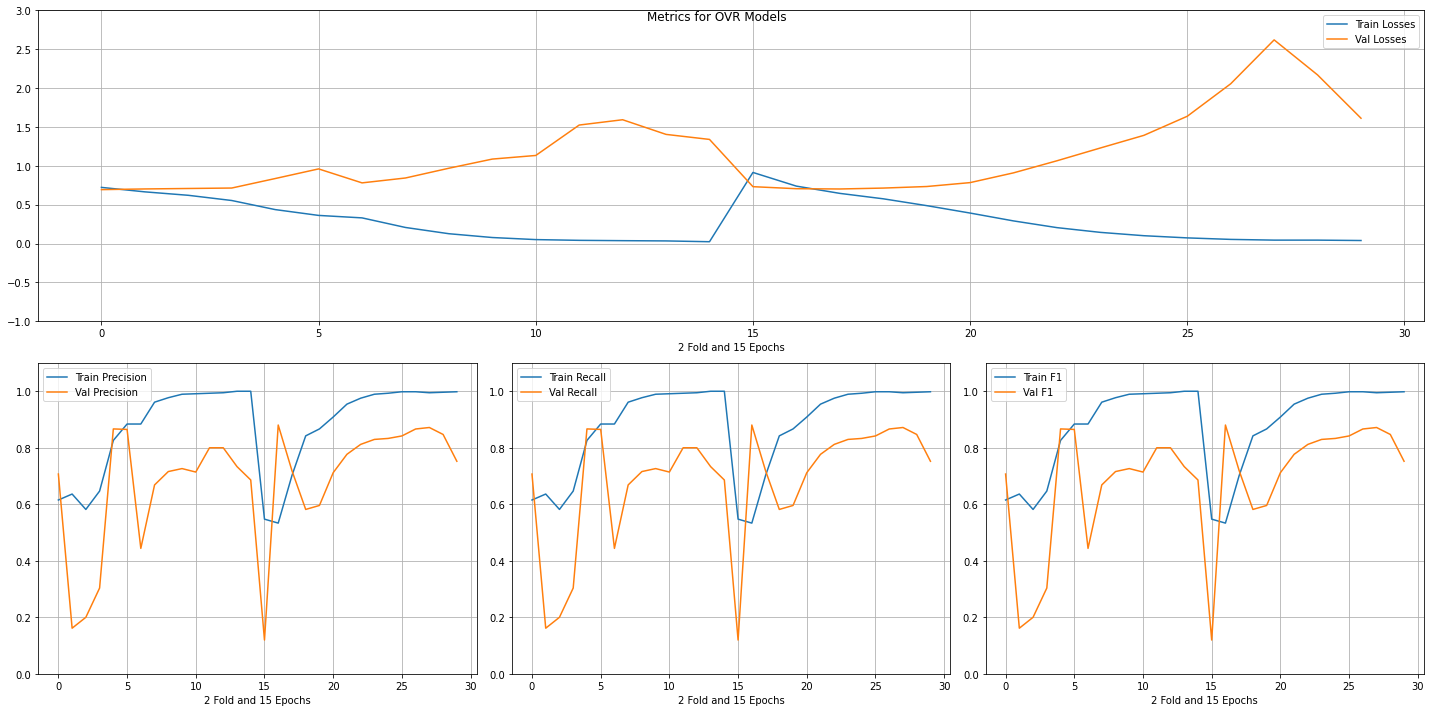

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.533333       0.880492  ...      0.738487           0.705186
12  0.994737       0.871705  ...      0.043451           2.620446
4   0.826011       0.866667  ...      0.436503           0.835964
11  0.998246       0.866432  ...      0.052737           2.055620
5   0.884007       0.864912  ...      0.361505           0.960043
13  0.996491       0.847100  ...      0.043410           2.169598
10  0.998246       0.841828  ...      0.072216           1.637554
9   0.992982       0.833040  ...      0.100309           1.391722
8   0.989474       0.829525  ...      0.143119           1.229418
7   0.975439       0.811951  ...      0.204264           1.064651
11  0.992970       0.800000  ...      0.040648           1.524538
12  0.994728       0.800000  ...      0.036507           1.592796
6   0.954386       0.776801  ...      0.290633           0.909204
14  0.998246       0.752197  ...      0.038449           1.612159
13  1.0000

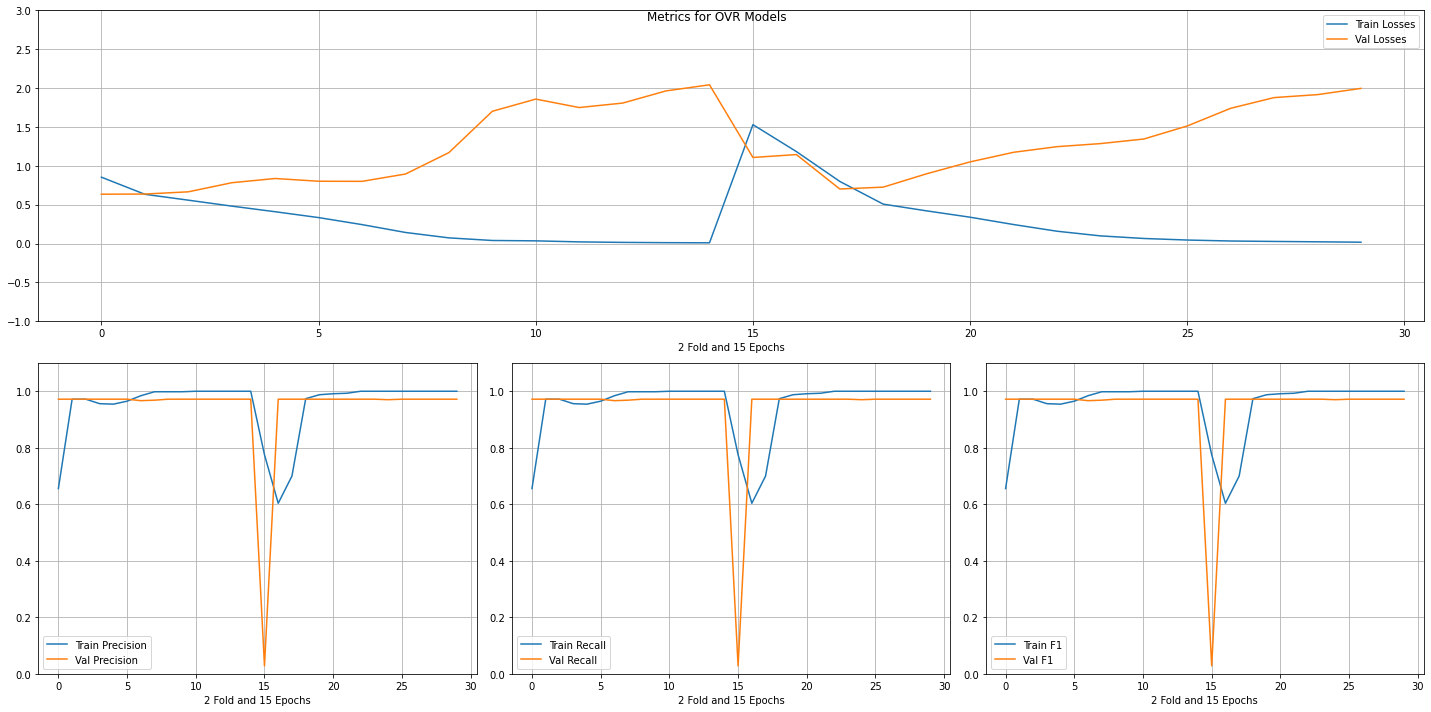

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.655536       0.971930  ...      0.853336           0.634316
8   0.998243       0.971930  ...      0.072410           1.169613
1   0.971880       0.971930  ...      0.633277           0.636521
14  1.000000       0.971930  ...      0.008848           2.042405
13  1.000000       0.971930  ...      0.010693           1.964101
12  1.000000       0.971930  ...      0.014288           1.807076
11  1.000000       0.971930  ...      0.020792           1.749907
9   0.998243       0.971930  ...      0.038797           1.701700
10  1.000000       0.971930  ...      0.034084           1.858466
5   0.964851       0.971930  ...      0.333535           0.801263
4   0.954306       0.971930  ...      0.408818           0.836603
3   0.956063       0.971930  ...      0.481178           0.782130
2   0.971880       0.971930  ...      0.557682           0.665059
12  1.000000       0.971880  ...      0.026476           1.877934
6   0.9929

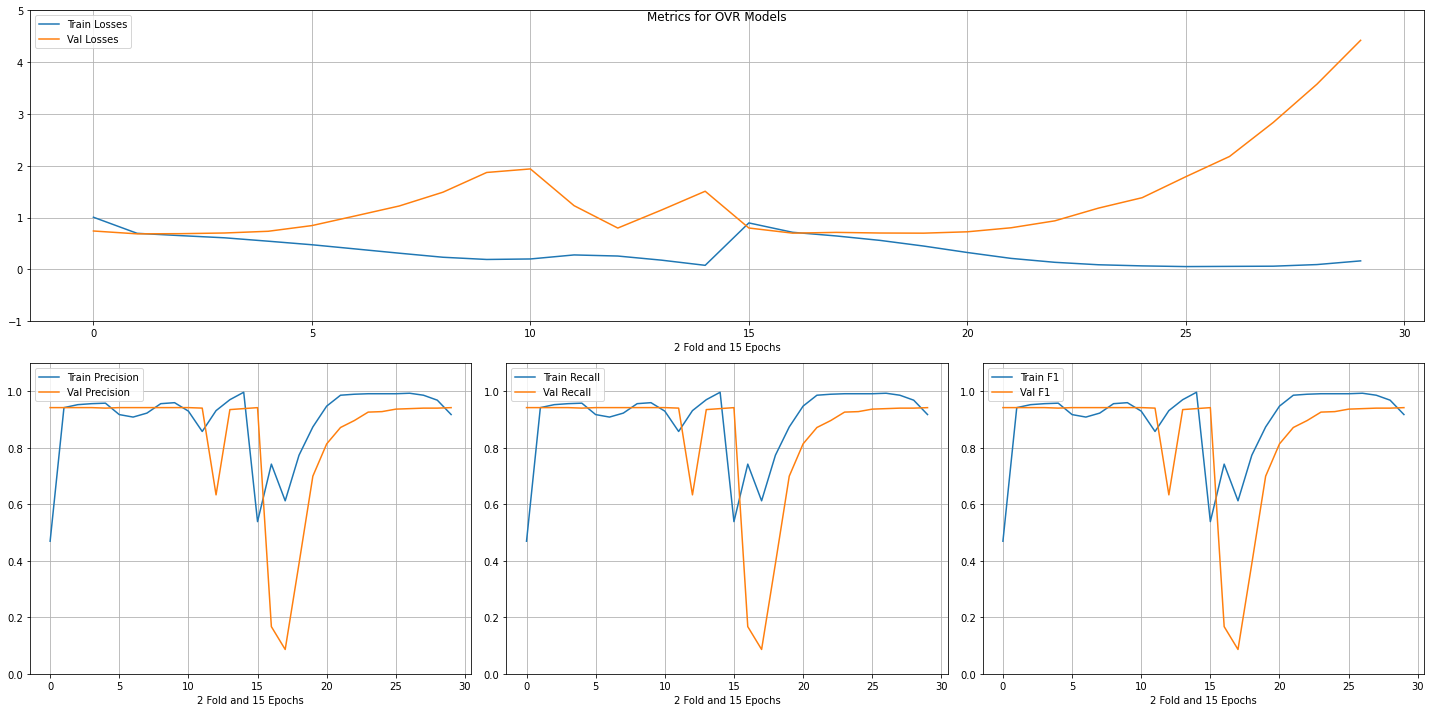

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.469244       0.942105  ...      1.007147           0.741338
10  0.929701       0.942105  ...      0.201422           1.939672
2   0.952548       0.942105  ...      0.651729           0.689830
3   0.956063       0.942105  ...      0.610051           0.702832
1   0.942004       0.942105  ...      0.696318           0.686244
5   0.917399       0.942105  ...      0.475877           0.845857
6   0.908612       0.942105  ...      0.394579           1.033954
7   0.922671       0.942105  ...      0.312810           1.224476
8   0.956063       0.942105  ...      0.234536           1.490850
9   0.959578       0.942105  ...      0.191747           1.871269
0   0.538596       0.942004  ...      0.897260           0.798835
14  0.917544       0.942004  ...      0.164440           4.422619
4   0.957821       0.940351  ...      0.544497           0.735965
11  0.857645       0.940351  ...      0.279328           1.230079
12  0.9859

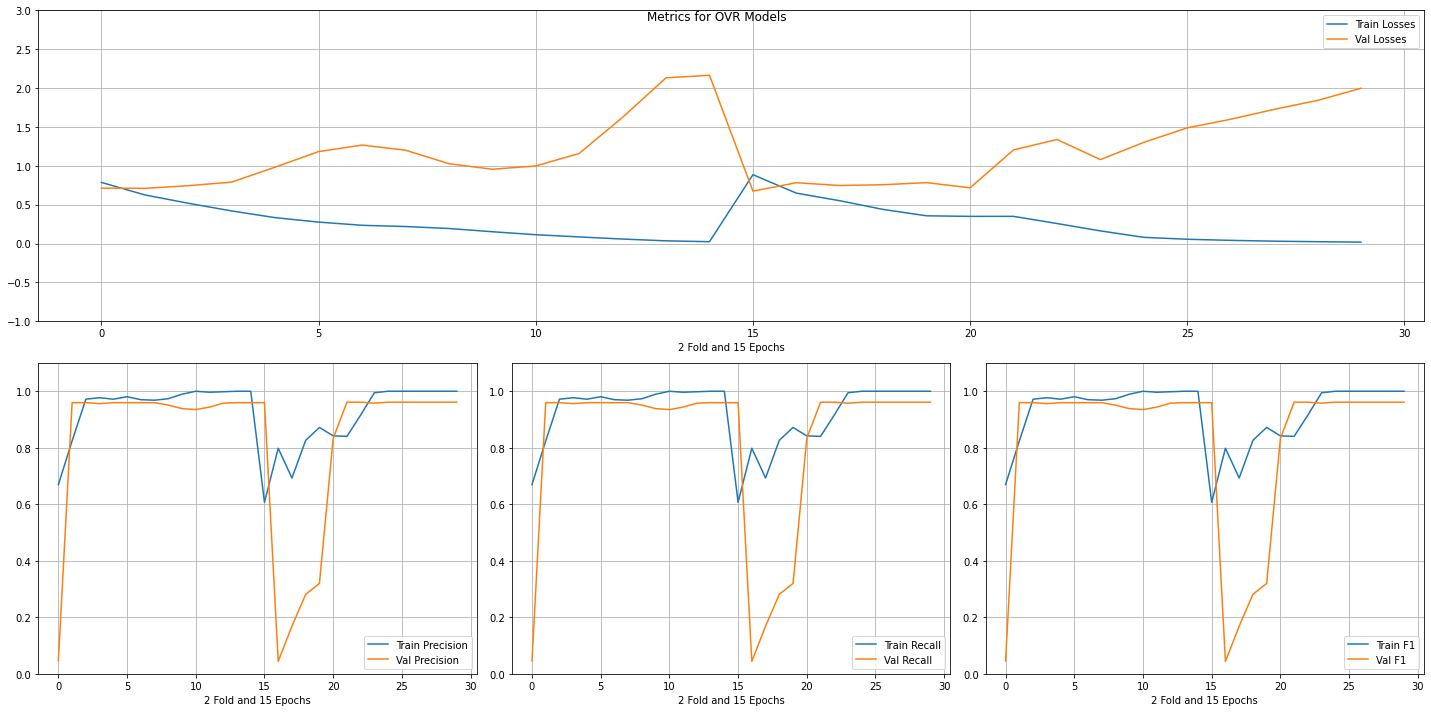

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.961336  ...      0.017483           1.997938
6   0.840351       0.961336  ...      0.349342           1.204358
13  1.000000       0.961336  ...      0.023248           1.841495
12  1.000000       0.961336  ...      0.029845           1.726507
11  1.000000       0.961336  ...      0.040426           1.599123
10  1.000000       0.961336  ...      0.054541           1.488389
9   1.000000       0.961336  ...      0.079213           1.301837
7   0.915789       0.961336  ...      0.257134           1.338505
2   0.971880       0.959649  ...      0.517936           0.744241
4   0.971880       0.959649  ...      0.332670           0.982739
5   0.980668       0.959649  ...      0.275550           1.182806
6   0.970123       0.959649  ...      0.234266           1.266817
7   0.968366       0.959649  ...      0.218404           1.201022
13  1.000000       0.959649  ...      0.034266           2.132486
14  1.0000

In [41]:
jlabels = jle.transform(jle.classes_)
jovr_res = ovr_train_model(data, ChromaJanakaRagaDataset, ChromaRaga, "OVR Models", jlabels, jle.classes_, lbl_encoder=jle, target='JanakaRagamCode', lr=1e-3, epochs=15, n_folds=2, feature='chroma')

In [42]:
for k in jovr_res:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.666667       0.978910  ...      1.305013           0.746656
1   0.771930       0.978910  ...      0.622104           0.635137
14  1.000000       0.978910  ...      0.013232           1.717571
3   0.978910       0.977193  ...      0.501093           0.678193
10  1.000000       0.977193  ...      0.051088           1.799904

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.982456  ...      0.019940           1.184219
9   1.000000       0.982456  ...      0.042019           1.065373
1   0.771529       0.982456  ...      0.853619           0.554910
14  1.000000       0.982456  ...      0.009067           1.403053
13  1.000000       0.982456  ...      0.011438           1.339765

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.395431       0.942105  ...      0.812007      

# OVR Experiment without Mayamalavagowla Raga

In [43]:
cl = jle.classes_
mc = jle.transform(['Mayamalavagowla','Unknown'])
rdata = data[data['JanakaRagamCode']!=mc[0]]
rdata = rdata[rdata['JanakaRagamCode']!=mc[1]]
cl = [x for x in cl if not x in ['Mayamalavagowla','Unknown'] ]
jlabels1 = jle.transform(cl)

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 1.091 / Validation Loss : 0.684 [Time Taken : 0.191545 seconds]
Epoch 2/15 : Training Loss: 0.621 / Validation Loss : 0.656 [Time Taken : 0.183013 seconds]
Epoch 3/15 : Training Loss: 0.567 / Validation Loss : 0.673 [Time Taken : 0.183776 seconds]
Epoch 4/15 : Training Loss: 0.501 / Validation Loss : 0.678 [Time Taken : 0.188233 seconds]
Epoch 5/15 : Training Loss: 0.430 / Validation Loss : 0.696 [Time Taken : 0.190472 seconds]
Epoch 6/15 : Training Loss: 0.347 / Validation Loss : 0.735 [Time Taken : 0.17919 seconds]
Epoch 7/15 : Training Loss: 0.258 / Validation Loss : 0.794 [Time Taken : 0.17503 seconds]
Epoch 8/15 : Training Loss: 0.185 / Validation Loss : 0.923 [Time Taken : 0.175442 seconds]
Epoch 9/15 : Training Loss: 0.128 / Validation Loss : 1.195 [Time Taken : 0.169798 seconds]
Epoch 10/15 : Training Loss: 0.081 / 

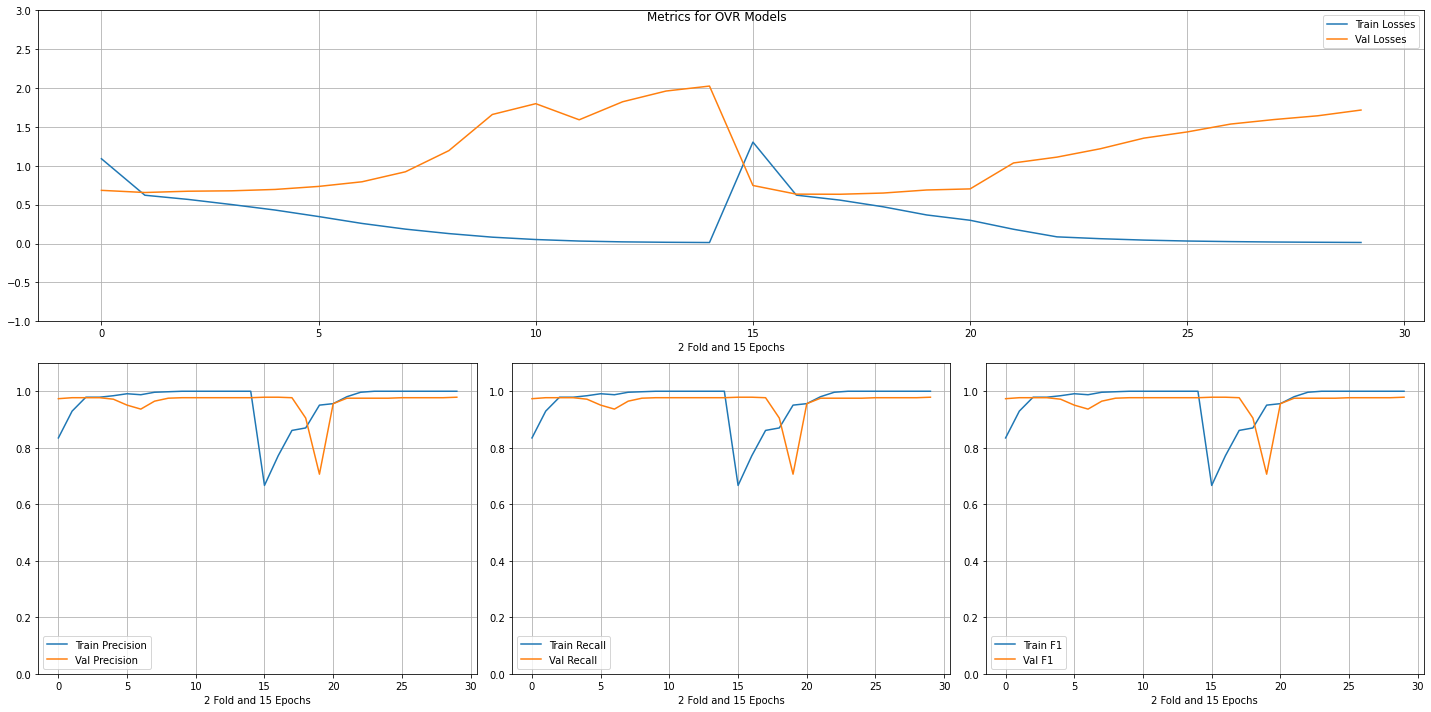

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.666667       0.978910  ...      1.305013           0.746656
1   0.771930       0.978910  ...      0.622104           0.635137
14  1.000000       0.978910  ...      0.013232           1.717547
3   0.978910       0.977193  ...      0.501093           0.678193
10  1.000000       0.977193  ...      0.051092           1.799489
1   0.929701       0.977193  ...      0.621166           0.656342
14  1.000000       0.977193  ...      0.012470           2.026055
13  1.000000       0.977193  ...      0.015730           1.962217
12  1.000000       0.977193  ...      0.021057           1.824150
11  1.000000       0.977193  ...      0.031574           1.592171
2   0.978910       0.977193  ...      0.567119           0.672898
9   1.000000       0.977193  ...      0.081423           1.660461
13  1.000000       0.977153  ...      0.015883           1.643431
12  1.000000       0.977153  ...      0.019109           1.595299
11  1.0000

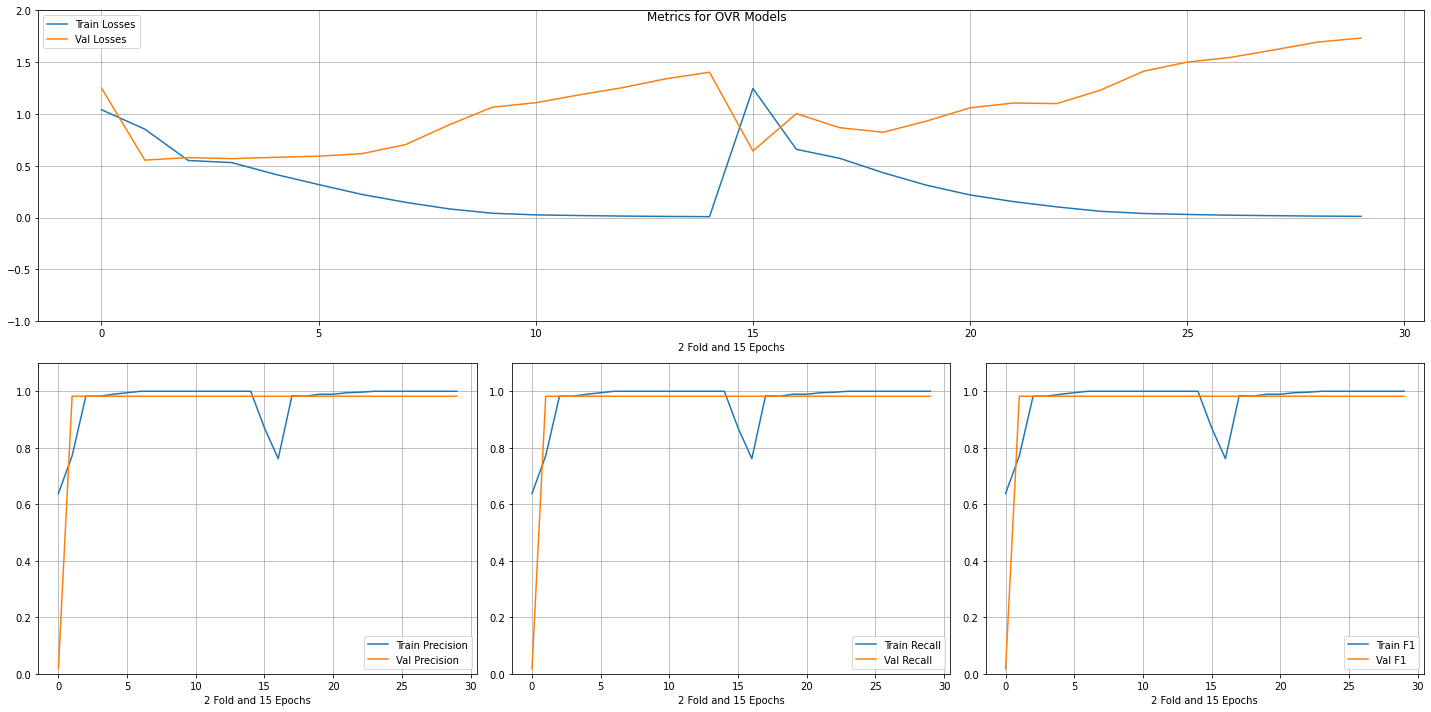

    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.982456  ...      0.019937           1.184325
9   1.000000       0.982456  ...      0.042017           1.065398
1   0.771529       0.982456  ...      0.853619           0.554910
14  1.000000       0.982456  ...      0.009063           1.403168
13  1.000000       0.982456  ...      0.011435           1.339907
12  1.000000       0.982456  ...      0.014664           1.254425
10  1.000000       0.982456  ...      0.026348           1.108890
8   1.000000       0.982456  ...      0.084359           0.894547
7   1.000000       0.982456  ...      0.147590           0.704402
6   1.000000       0.982456  ...      0.223341           0.617337
5   0.994728       0.982456  ...      0.318990           0.592651
4   0.989455       0.982456  ...      0.417919           0.581913
3   0.982425       0.982456  ...      0.530841           0.569108
2   0.982425       0.982456  ...      0.551111           0.579183
11  1.0000

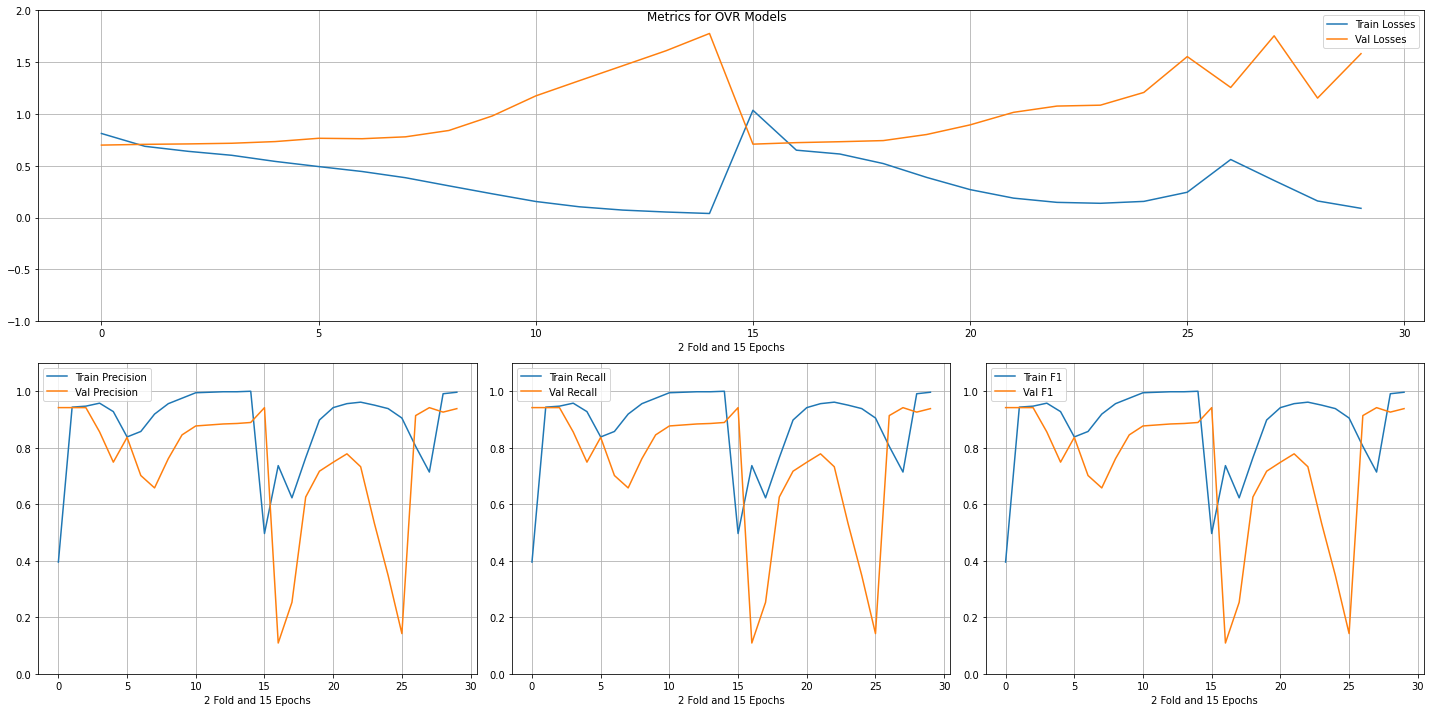

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.395431       0.942105  ...      0.812007           0.699840
1   0.943761       0.942105  ...      0.688095           0.707124
2   0.947276       0.942105  ...      0.639534           0.711218
12  0.714035       0.942004  ...      0.358221           1.754654
0   0.496491       0.942004  ...      1.035997           0.708971
14  0.996491       0.938489  ...      0.089512           1.582320
13  0.991228       0.926186  ...      0.160536           1.153467
11  0.805263       0.913884  ...      0.560616           1.256155
14  1.000000       0.889474  ...      0.039650           1.777281
13  0.998243       0.885965  ...      0.053876           1.610631
12  0.998243       0.884211  ...      0.072562           1.465531
11  0.996485       0.880702  ...      0.104471           1.321082
10  0.994728       0.877193  ...      0.155568           1.174762
3   0.957821       0.856140  ...      0.601374           0.717610
9   0.9753

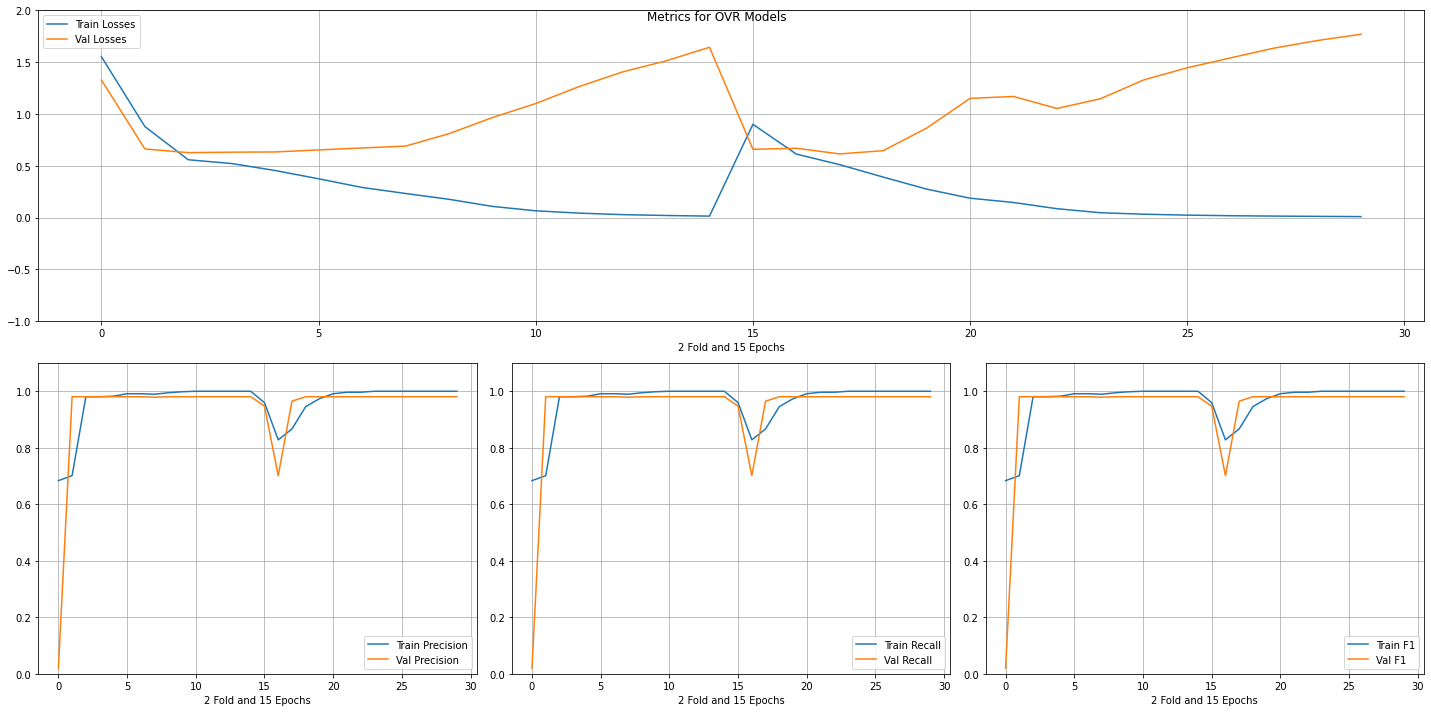

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.980702  ...      0.020422           1.512992
8   0.994728       0.980702  ...      0.176869           0.809732
1   0.701230       0.980702  ...      0.878920           0.662358
14  1.000000       0.980702  ...      0.014238           1.644285
12  1.000000       0.980702  ...      0.028540           1.406115
11  1.000000       0.980702  ...      0.043023           1.264841
10  1.000000       0.980702  ...      0.065546           1.101150
9   0.998243       0.980702  ...      0.108231           0.965607
6   0.991213       0.980702  ...      0.291182           0.672376
5   0.991213       0.980702  ...      0.374602           0.653339
4   0.982425       0.980702  ...      0.454486           0.633723
3   0.980668       0.980702  ...      0.521845           0.631571
2   0.980668       0.980702  ...      0.558396           0.627198
10  1.000000       0.980668  ...      0.023823           1.445838
5   0.9912

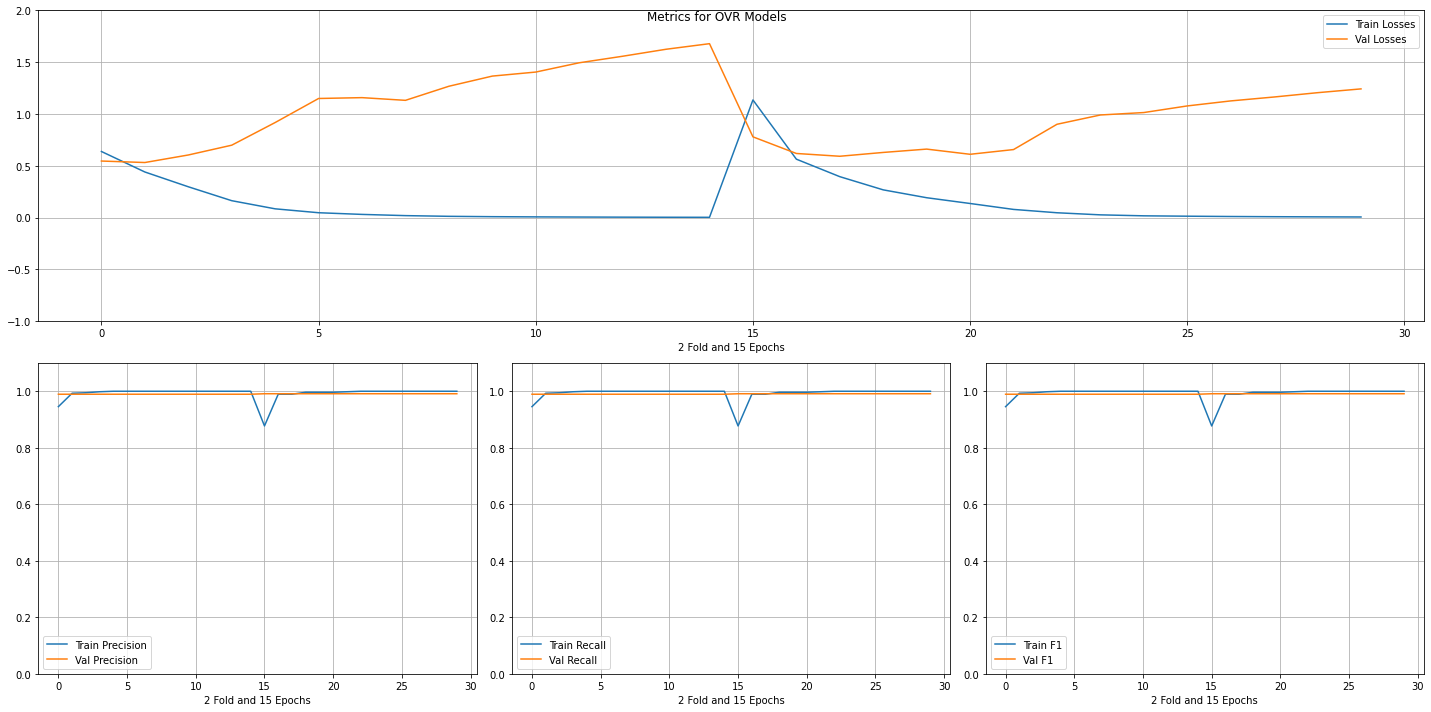

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.877193       0.991213  ...      1.135744           0.779564
1   0.989474       0.991213  ...      0.564010           0.619020
13  1.000000       0.991213  ...      0.007242           1.205760
12  1.000000       0.991213  ...      0.008568           1.164142
11  1.000000       0.991213  ...      0.010575           1.126322
10  1.000000       0.991213  ...      0.013568           1.077894
9   1.000000       0.991213  ...      0.017152           1.014046
8   1.000000       0.991213  ...      0.026529           0.990532
7   1.000000       0.991213  ...      0.046743           0.900768
6   0.998246       0.991213  ...      0.078980           0.656726
5   0.996491       0.991213  ...      0.136183           0.611113
4   0.996491       0.991213  ...      0.191845           0.661166
3   0.996491       0.991213  ...      0.267756           0.628986
2   0.989474       0.991213  ...      0.395145           0.592107
14  1.0000

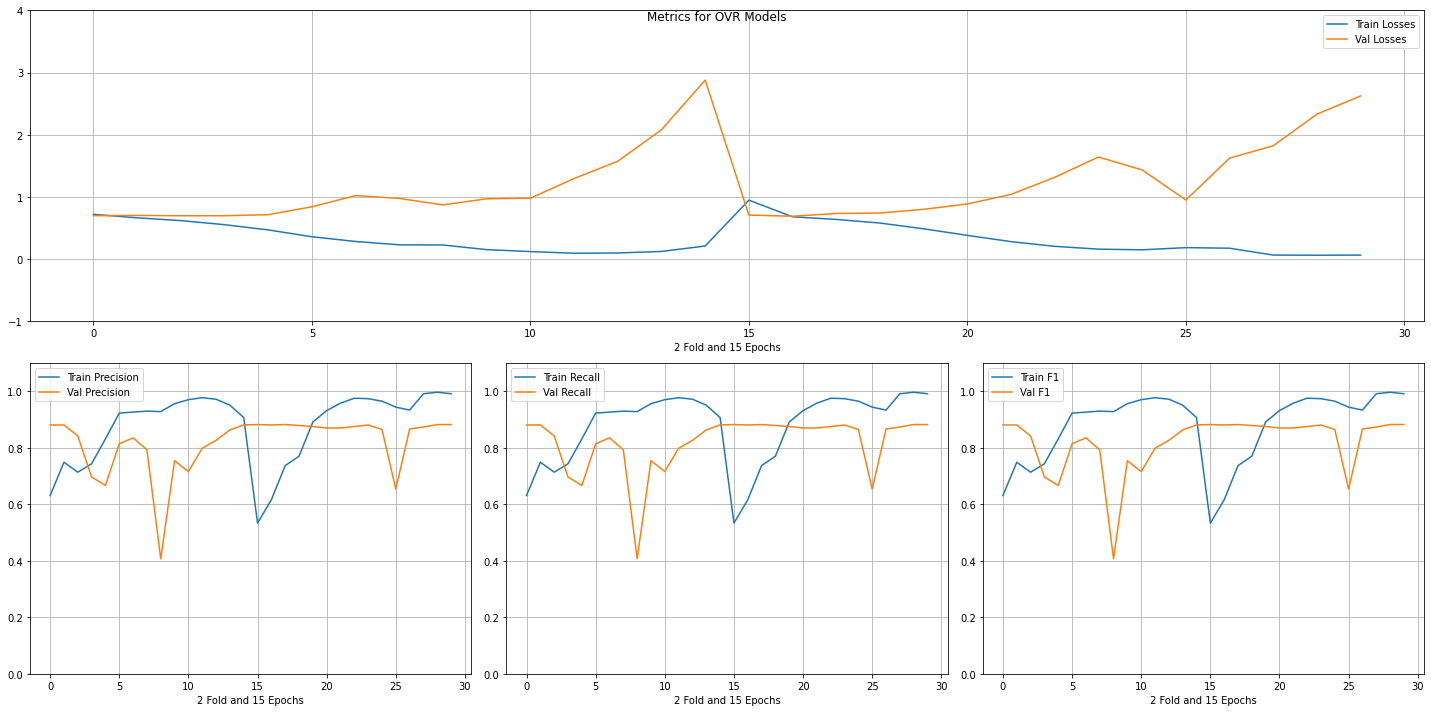

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.533333       0.882250  ...      0.947452           0.707182
2   0.736842       0.882250  ...      0.637343           0.733444
13  0.996491       0.882250  ...      0.061269           2.330216
14  0.991228       0.882250  ...      0.063643           2.623832
0   0.630931       0.880702  ...      0.719290           0.697599
14  0.906854       0.880702  ...      0.209820           2.878879
1   0.748682       0.880702  ...      0.663241           0.701453
1   0.615789       0.880492  ...      0.679459           0.688522
8   0.973684       0.880492  ...      0.159012           1.640965
3   0.770175       0.878735  ...      0.579009           0.740125
7   0.975439       0.875220  ...      0.204313           1.315006
4   0.891228       0.875220  ...      0.486273           0.800338
12  0.991228       0.873462  ...      0.063852           1.822656
5   0.931579       0.869947  ...      0.380648           0.885853
6   0.9578

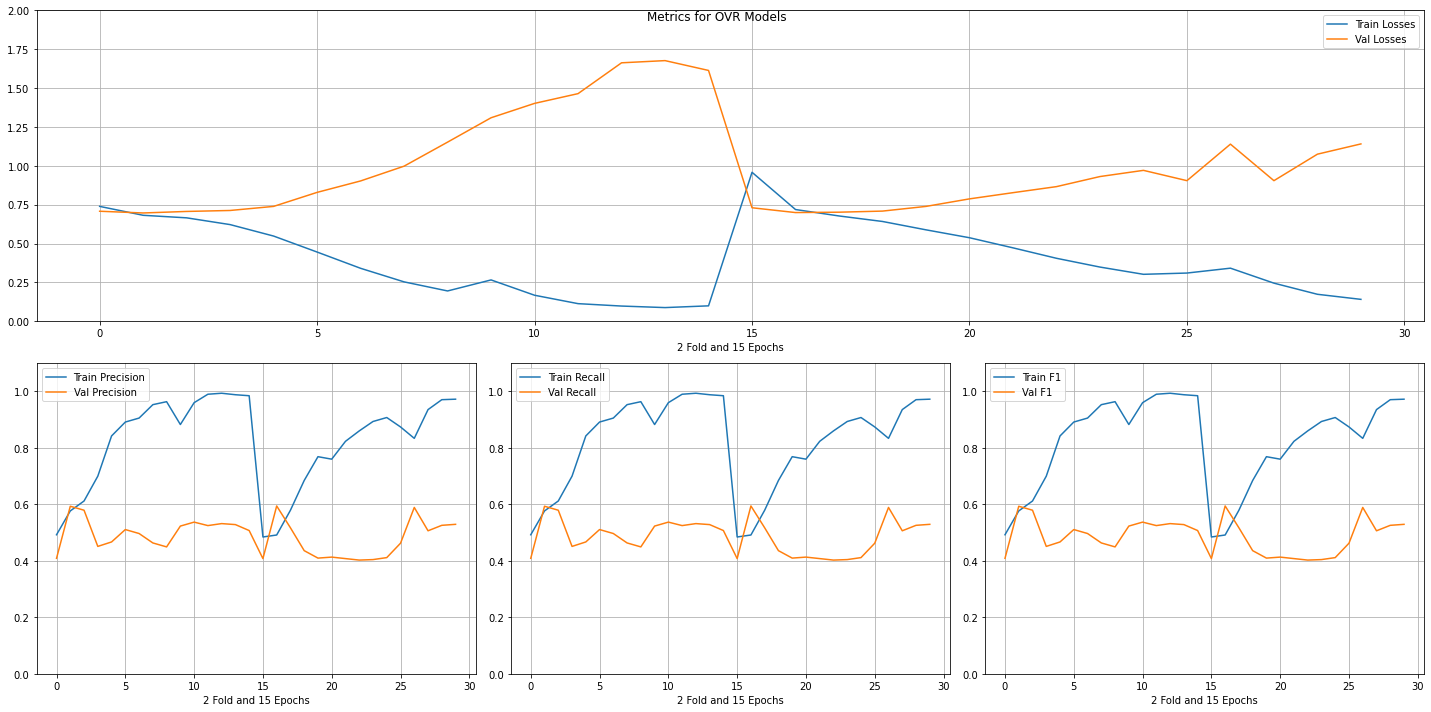

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.491228       0.594025  ...      0.718527           0.699057
1   0.576450       0.592982  ...      0.681538           0.696436
11  0.833333       0.588752  ...      0.341249           1.139403
2   0.611599       0.578947  ...      0.665107           0.706296
10  0.959578       0.536842  ...      0.167017           1.401644
12  0.992970       0.531579  ...      0.097463           1.662766
14  0.971930       0.528998  ...      0.140547           1.140839
13  0.987698       0.528070  ...      0.087575           1.676858
13  0.970175       0.525483  ...      0.173157           1.074813
11  0.989455       0.524561  ...      0.112940           1.464373
9   0.882250       0.522807  ...      0.265580           1.309149
2   0.578947       0.516696  ...      0.677240           0.701475
5   0.891037       0.510526  ...      0.444992           0.828977
14  0.984183       0.507018  ...      0.098811           1.613654
12  0.9350

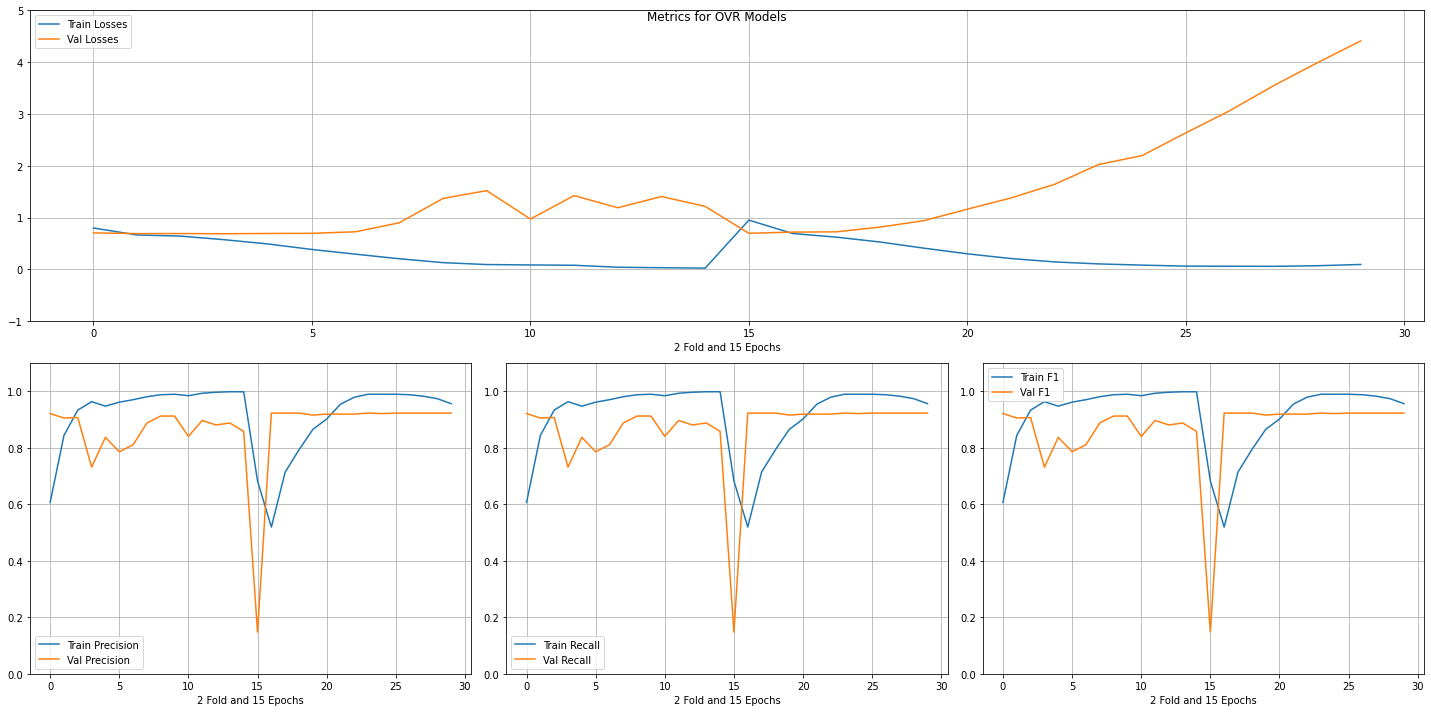

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.956140       0.922671  ...      0.095236           4.409875
1   0.519298       0.922671  ...      0.693008           0.719956
13  0.973684       0.922671  ...      0.070456           3.985393
12  0.982456       0.922671  ...      0.059324           3.542750
11  0.987719       0.922671  ...      0.061250           3.062091
10  0.989474       0.922671  ...      0.063345           2.635696
8   0.989474       0.922671  ...      0.106091           2.023668
3   0.792982       0.922671  ...      0.528926           0.817121
2   0.714035       0.922671  ...      0.622810           0.724825
0   0.606327       0.921053  ...      0.799148           0.705074
9   0.989474       0.920914  ...      0.082503           2.197303
5   0.901754       0.919156  ...      0.300531           1.162785
6   0.954386       0.919156  ...      0.209515           1.379796
7   0.978947       0.919156  ...      0.144280           1.643703
4   0.8649

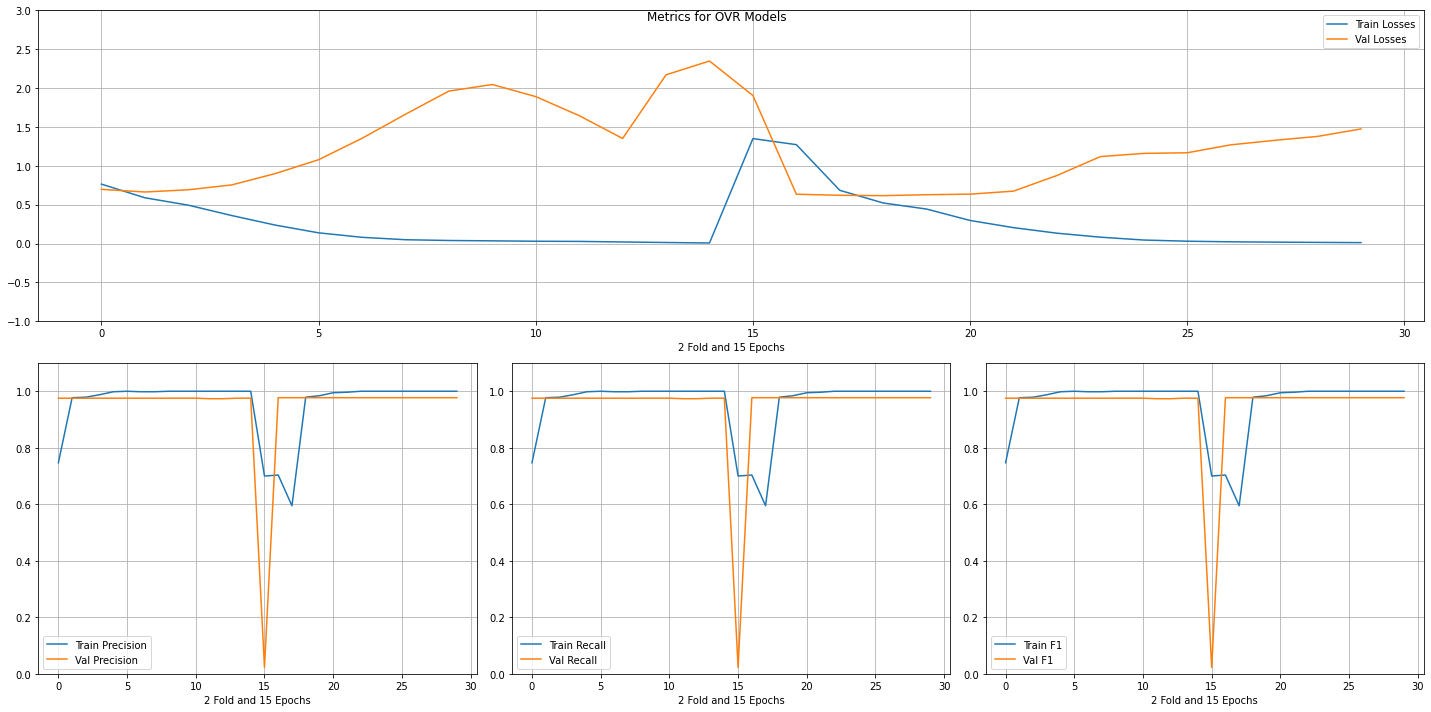

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977153  ...      0.011389           1.474472
13  1.000000       0.977153  ...      0.014209           1.378275
12  1.000000       0.977153  ...      0.017567           1.327046
11  1.000000       0.977153  ...      0.021795           1.269736
10  1.000000       0.977153  ...      0.029454           1.167604
9   1.000000       0.977153  ...      0.044568           1.159878
8   1.000000       0.977153  ...      0.081296           1.118556
7   1.000000       0.977153  ...      0.132608           0.875346
6   0.996491       0.977153  ...      0.204049           0.673977
5   0.994737       0.977153  ...      0.296314           0.635185
4   0.984211       0.977153  ...      0.442973           0.627787
3   0.978947       0.977153  ...      0.521488           0.615765
2   0.594737       0.977153  ...      0.684165           0.620314
1   0.703509       0.977153  ...      1.272090           0.634240
1   0.9771

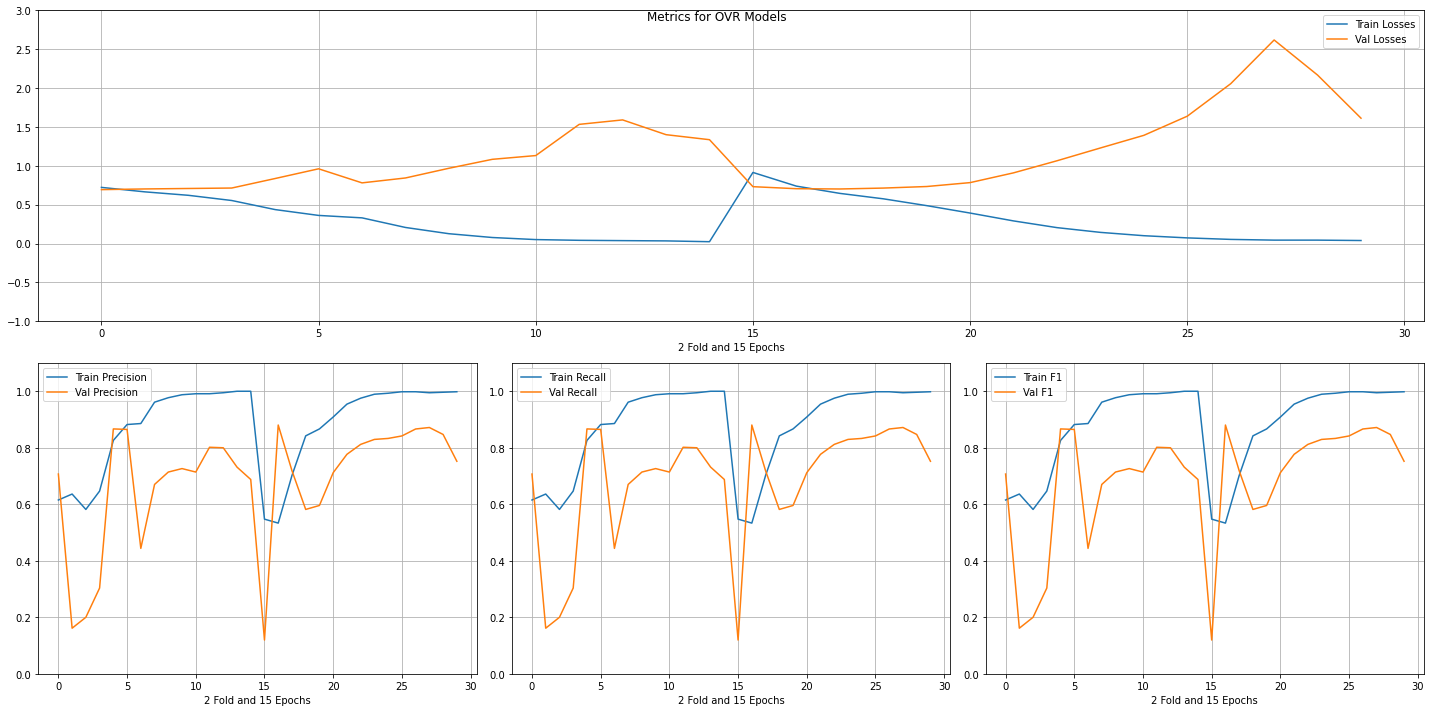

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.533333       0.880492  ...      0.738487           0.705186
12  0.994737       0.871705  ...      0.043410           2.619158
4   0.826011       0.866667  ...      0.436409           0.836444
11  0.998246       0.866432  ...      0.052710           2.056500
5   0.882250       0.864912  ...      0.361400           0.961300
13  0.996491       0.847100  ...      0.043326           2.167683
10  0.998246       0.841828  ...      0.072208           1.638439
9   0.992982       0.833040  ...      0.100310           1.391973
8   0.989474       0.829525  ...      0.143123           1.229426
7   0.975439       0.811951  ...      0.204268           1.064651
11  0.991213       0.801754  ...      0.041042           1.533293
12  0.994728       0.800000  ...      0.036988           1.590676
6   0.954386       0.776801  ...      0.290641           0.909205
14  0.998246       0.752197  ...      0.038398           1.612772
13  1.0000

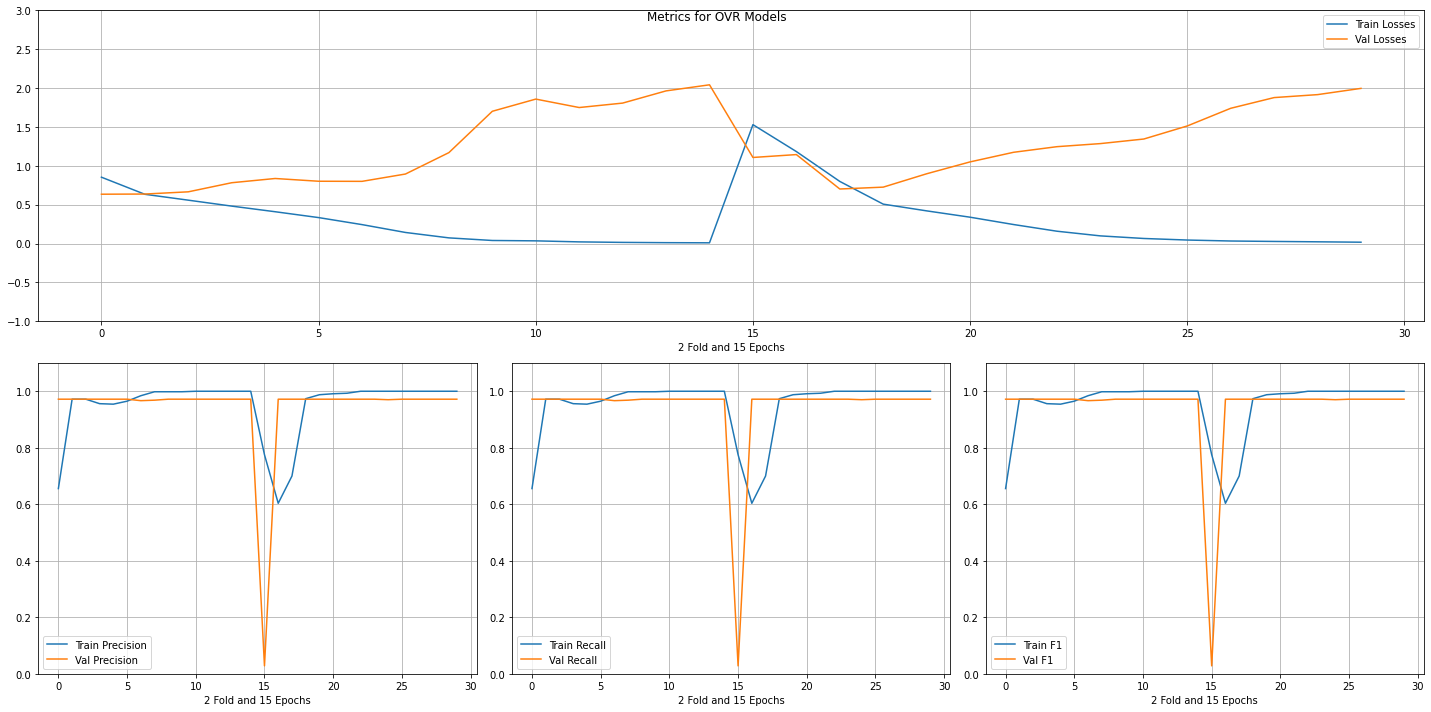

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.655536       0.971930  ...      0.853336           0.634316
8   0.998243       0.971930  ...      0.072410           1.169650
1   0.971880       0.971930  ...      0.633277           0.636521
14  1.000000       0.971930  ...      0.008848           2.042373
13  1.000000       0.971930  ...      0.010694           1.964071
12  1.000000       0.971930  ...      0.014289           1.806992
11  1.000000       0.971930  ...      0.020793           1.749925
9   0.998243       0.971930  ...      0.038796           1.701710
10  1.000000       0.971930  ...      0.034084           1.858515
5   0.964851       0.971930  ...      0.333535           0.801275
4   0.954306       0.971930  ...      0.408817           0.836609
3   0.956063       0.971930  ...      0.481178           0.782132
2   0.971880       0.971930  ...      0.557682           0.665059
12  1.000000       0.971880  ...      0.026476           1.877931
6   0.9929

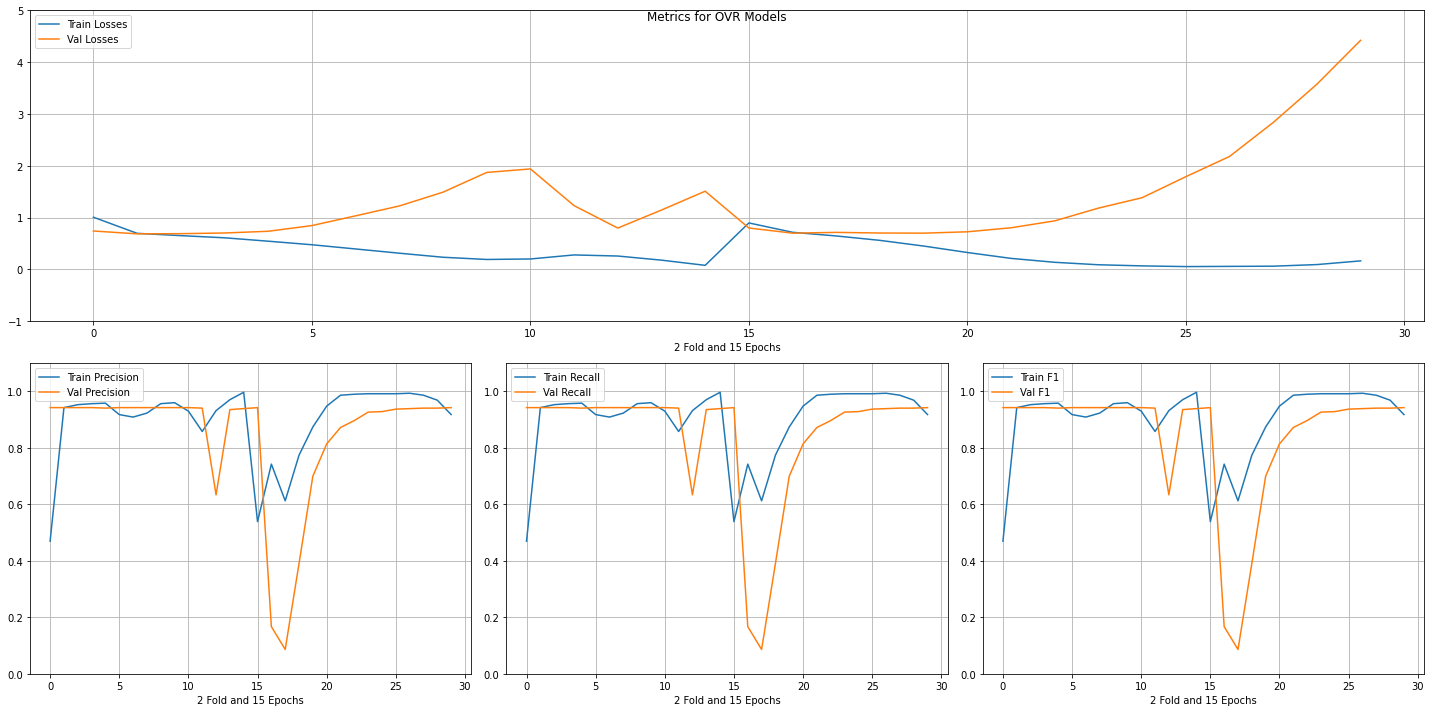

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.469244       0.942105  ...      1.007147           0.741338
10  0.929701       0.942105  ...      0.201376           1.939726
2   0.952548       0.942105  ...      0.651729           0.689830
3   0.956063       0.942105  ...      0.610051           0.702832
1   0.942004       0.942105  ...      0.696318           0.686244
5   0.917399       0.942105  ...      0.475877           0.845857
6   0.908612       0.942105  ...      0.394579           1.033954
7   0.922671       0.942105  ...      0.312810           1.224480
8   0.956063       0.942105  ...      0.234535           1.490844
9   0.959578       0.942105  ...      0.191727           1.871438
0   0.538596       0.942004  ...      0.897260           0.798835
14  0.917544       0.942004  ...      0.164450           4.422548
4   0.957821       0.940351  ...      0.544497           0.735965
11  0.857645       0.940351  ...      0.279282           1.230393
12  0.9859

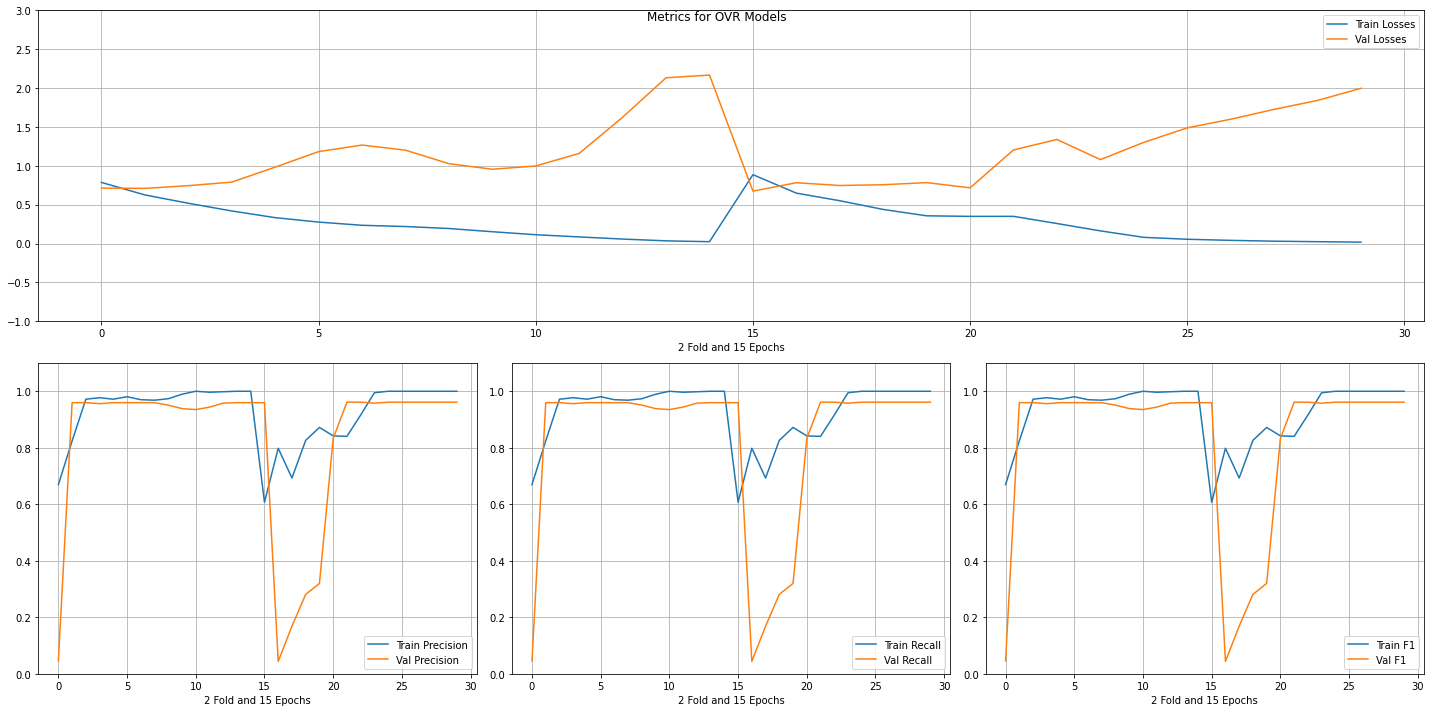

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.961336  ...      0.017488           1.997645
6   0.840351       0.961336  ...      0.349336           1.204275
13  1.000000       0.961336  ...      0.023251           1.841325
12  1.000000       0.961336  ...      0.029845           1.726449
11  1.000000       0.961336  ...      0.040422           1.599171
10  1.000000       0.961336  ...      0.054534           1.488418
9   1.000000       0.961336  ...      0.079210           1.301820
7   0.915789       0.961336  ...      0.257111           1.338641
2   0.971880       0.959649  ...      0.517936           0.744241
4   0.971880       0.959649  ...      0.332669           0.982742
5   0.980668       0.959649  ...      0.275551           1.182785
6   0.970123       0.959649  ...      0.234261           1.266868
7   0.968366       0.959649  ...      0.218390           1.201069
13  1.000000       0.959649  ...      0.034221           2.133138
14  1.0000

In [44]:
jovr_res_reduced = ovr_train_model(data, ChromaJanakaRagaDataset, ChromaRaga, "OVR Models", jlabels, jle.classes_, lbl_encoder=jle, target='JanakaRagamCode', lr=1e-3, epochs=15, n_folds=2, feature='chroma')

In [45]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.666667       0.978910  ...      1.305013           0.746656
1   0.771930       0.978910  ...      0.622104           0.635137
14  1.000000       0.978910  ...      0.013232           1.717547
3   0.978910       0.977193  ...      0.501093           0.678193
10  1.000000       0.977193  ...      0.051092           1.799489

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
11  1.000000       0.982456  ...      0.019937           1.184325
9   1.000000       0.982456  ...      0.042017           1.065398
1   0.771529       0.982456  ...      0.853619           0.554910
14  1.000000       0.982456  ...      0.009063           1.403168
13  1.000000       0.982456  ...      0.011435           1.339907

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.395431       0.942105  ...      0.812007      

# OVR Experiment 2 - LSTM Model

In [53]:
class ChromaLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=1):
        super().__init__()
        self.input_dim = 12
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 1876
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,40),
                                nn.GELU(),
                                nn.Linear(40,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

In [51]:
def ovr_train_model_lstm(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, 
                         target='RagamCode', feature='mfcc', epochs=20, lr=1e-3):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: print(f'Training for {lbl_encoder.inverse_transform([i])} with {nsamples} positive samples')
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : True,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : 2,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.52144082 12.16      ]
Epoch 1/100 : Training Loss: 0.709 / Validation Loss : 0.708 [Time Taken : 1.38051 seconds]
Epoch 2/100 : Training Loss: 0.698 / Validation Loss : 0.698 [Time Taken : 1.393225 seconds]
Epoch 3/100 : Training Loss: 0.691 / Validation Loss : 0.690 [Time Taken : 1.367541 seconds]
Epoch 4/100 : Training Loss: 0.684 / Validation Loss : 0.683 [Time Taken : 1.402381 seconds]
Epoch 5/100 : Training Loss: 0.678 / Validation Loss : 0.678 [Time Taken : 1.388164 seconds]
Epoch 6/100 : Training Loss: 0.673 / Validation Loss : 0.674 [Time Taken : 1.49222 seconds]
Epoch 7/100 : Training Loss: 0.668 / Validation Loss : 0.673 [Time Taken : 1.390861 seconds]
Epoch 8/100 : Training Loss: 0.663 / Validation Loss : 0.672 [Time Taken : 1.374096 seconds]
Epoch 9/100 : Training Loss: 0.658 / Validation Loss : 0.673 [Time Taken : 1.502073 seconds]
Epoch 10/100 : Training Loss

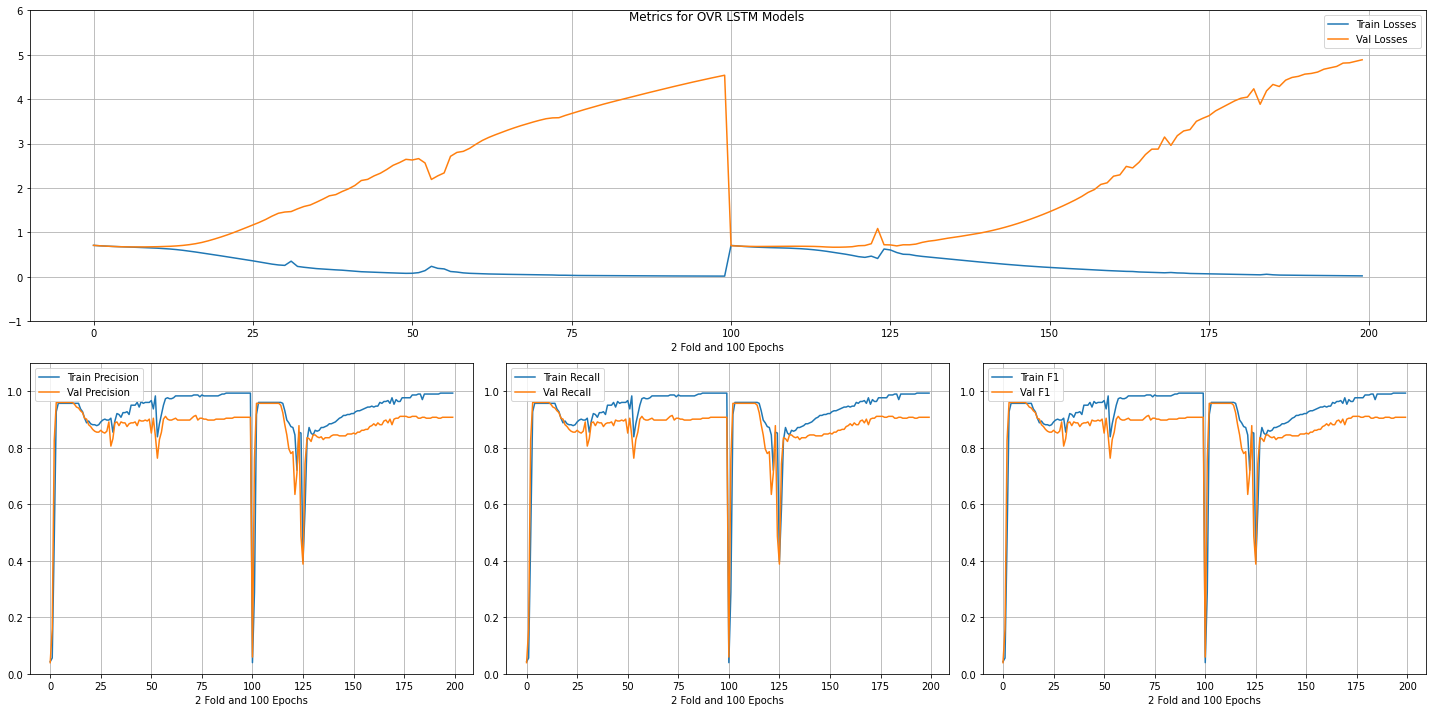

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.957237       0.960526  ...      0.636399           0.681664
3   0.927632       0.960526  ...      0.684115           0.683205
4   0.957237       0.960526  ...      0.678181           0.677983
5   0.957237       0.960526  ...      0.672744           0.674440
6   0.957237       0.960526  ...      0.667655           0.672613
..       ...            ...  ...           ...                ...
24  0.851974       0.486842  ...      0.625680           0.721927
25  0.398026       0.388158  ...      0.604354           0.718315
1   0.055921       0.157895  ...      0.698368           0.698138
0   0.039474       0.059211  ...      0.706812           0.700095
0   0.042763       0.039474  ...      0.708543           0.707907

[200 rows x 8 columns]
Training for ['Hanumatodi'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.5170068 15.2      ]
Epoch 1/100 : Training Loss: 0.713 / Validation 

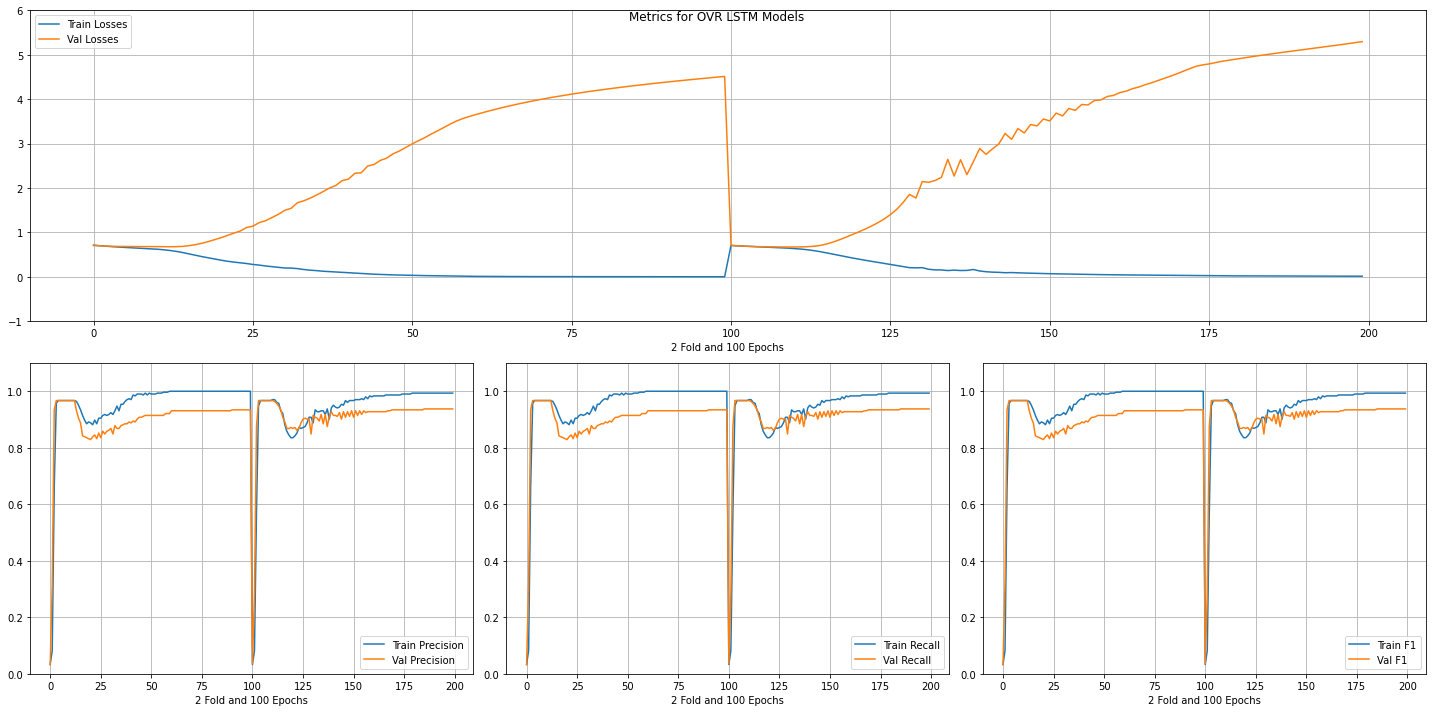

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.947368       0.967105  ...      0.683549           0.684682
10  0.967105       0.967105  ...      0.621219           0.679703
10  0.970395       0.967105  ...      0.635720           0.671518
9   0.967105       0.967105  ...      0.645121           0.670784
8   0.967105       0.967105  ...      0.652825           0.670899
..       ...            ...  ...           ...                ...
20  0.888158       0.828947  ...      0.374443           0.880228
1   0.082237       0.319079  ...      0.699283           0.697205
1   0.082237       0.282895  ...      0.697638           0.697388
0   0.032895       0.036184  ...      0.707706           0.705630
0   0.032895       0.032895  ...      0.713131           0.704609

[200 rows x 8 columns]
Training for ['Harikambhoji'] with 66 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [0.56088561 4.60606061]
Epoch 1/100 : Training Loss: 0.697 / Validatio

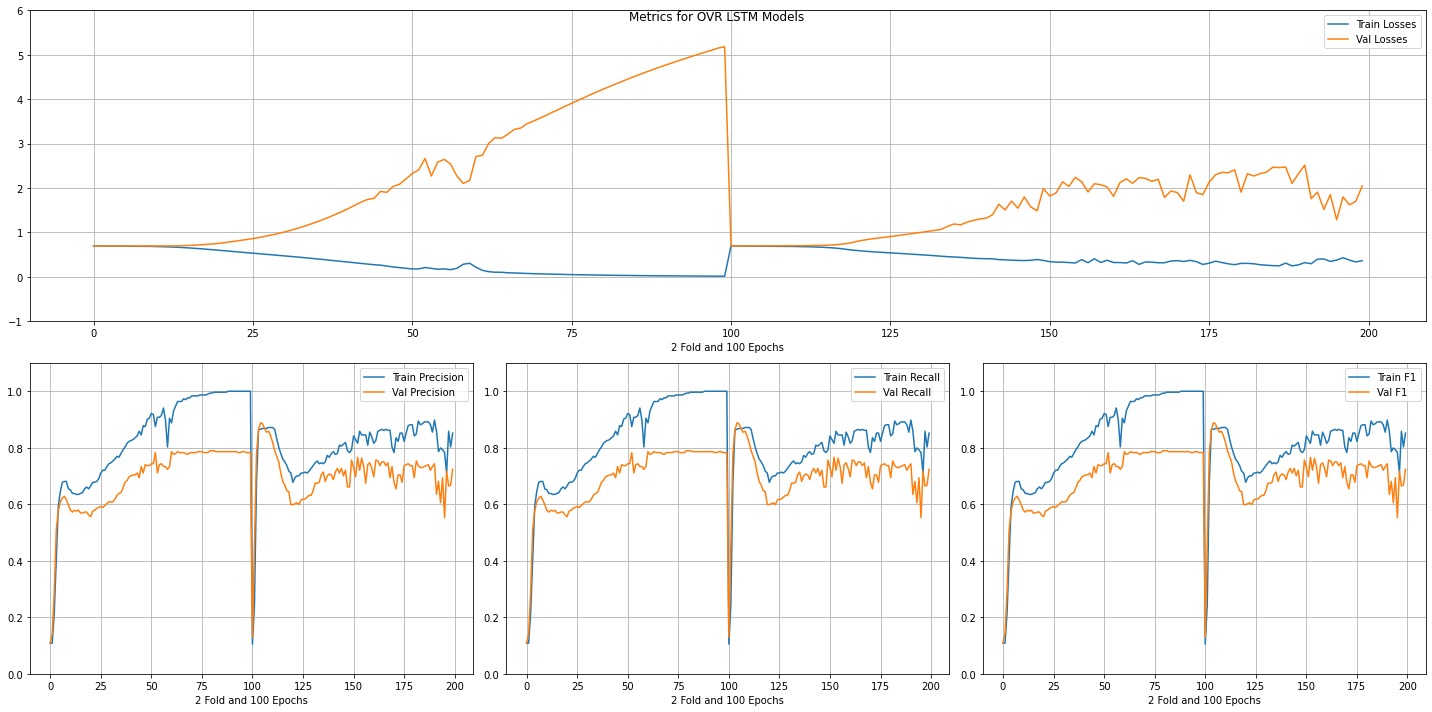

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.865132       0.888158  ...      0.690111           0.695171
5   0.868421       0.884868  ...      0.689271           0.695570
6   0.868421       0.868421  ...      0.688334           0.695972
3   0.865132       0.861842  ...      0.690928           0.694716
8   0.871711       0.858553  ...      0.685985           0.697041
..       ...            ...  ...           ...                ...
1   0.246711       0.463816  ...      0.693535           0.694002
2   0.213816       0.289474  ...      0.692266           0.693022
1   0.108553       0.141447  ...      0.693597           0.693873
0   0.105263       0.128289  ...      0.696663           0.694519
0   0.108553       0.108553  ...      0.697026           0.695637

[200 rows x 8 columns]
Training for ['Jhalavarali'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.51877133 13.81818182]
Epoch 1/100 : Training Loss: 0.720 / Validati

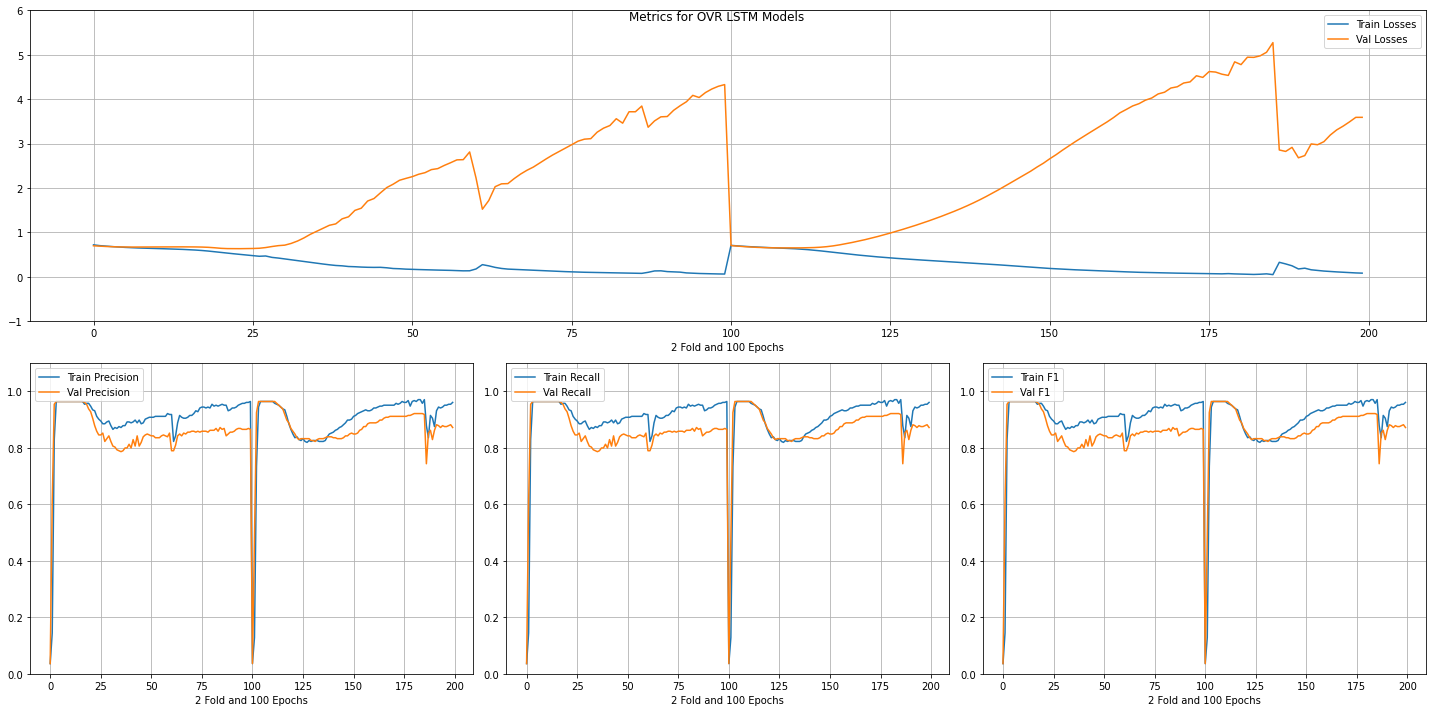

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.963816       0.963816  ...      0.627472           0.674983
4   0.963816       0.963816  ...      0.670090           0.663680
5   0.963816       0.963816  ...      0.663235           0.657809
6   0.963816       0.963816  ...      0.657151           0.653851
7   0.963816       0.963816  ...      0.651522           0.651576
..       ...            ...  ...           ...                ...
86  0.878289       0.743421  ...      0.326588           2.856497
1   0.144737       0.608553  ...      0.701657           0.689554
1   0.128289       0.483553  ...      0.696075           0.691280
0   0.036184       0.036184  ...      0.719745           0.698148
0   0.036184       0.036184  ...      0.708446           0.703264

[200 rows x 8 columns]
Training for ['Kalyani'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.50921273 27.63636364]
Epoch 1/100 : Training Loss: 0.719 / Validation L

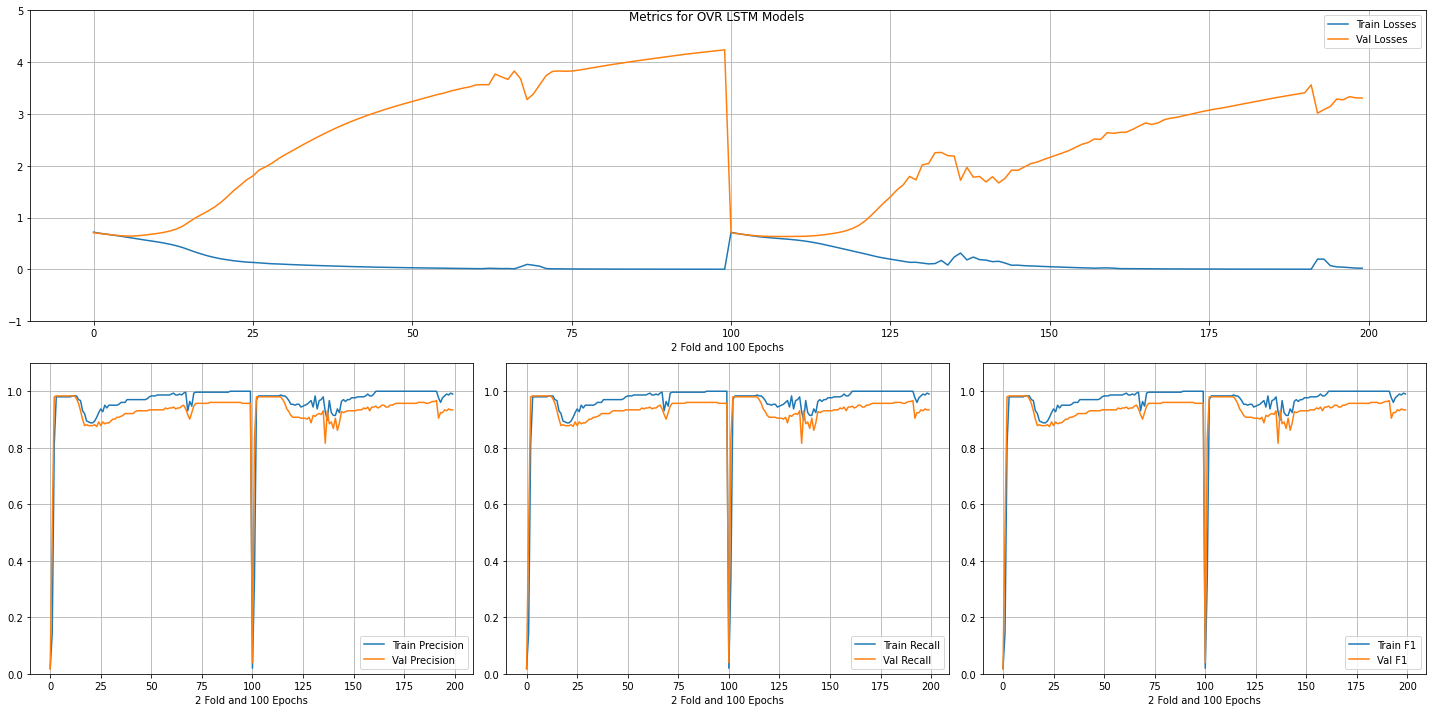

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.980263       0.983553  ...      0.531327           0.693774
3   0.980263       0.983553  ...      0.664131           0.664387
4   0.980263       0.983553  ...      0.645802           0.652599
5   0.980263       0.983553  ...      0.626109           0.644691
6   0.980263       0.983553  ...      0.605794           0.643365
..       ...            ...  ...           ...                ...
1   0.335526       0.835526  ...      0.693274           0.688740
36  0.927632       0.815789  ...      0.316048           1.720679
1   0.144737       0.513158  ...      0.697908           0.692431
0   0.019737       0.039474  ...      0.715853           0.705696
0   0.019737       0.016447  ...      0.718668           0.708158

[200 rows x 8 columns]
Training for ['Kharaharapriya'] with 135 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [0.64270613 2.25185185]
Epoch 1/100 : Training Loss: 0.701 / Valida

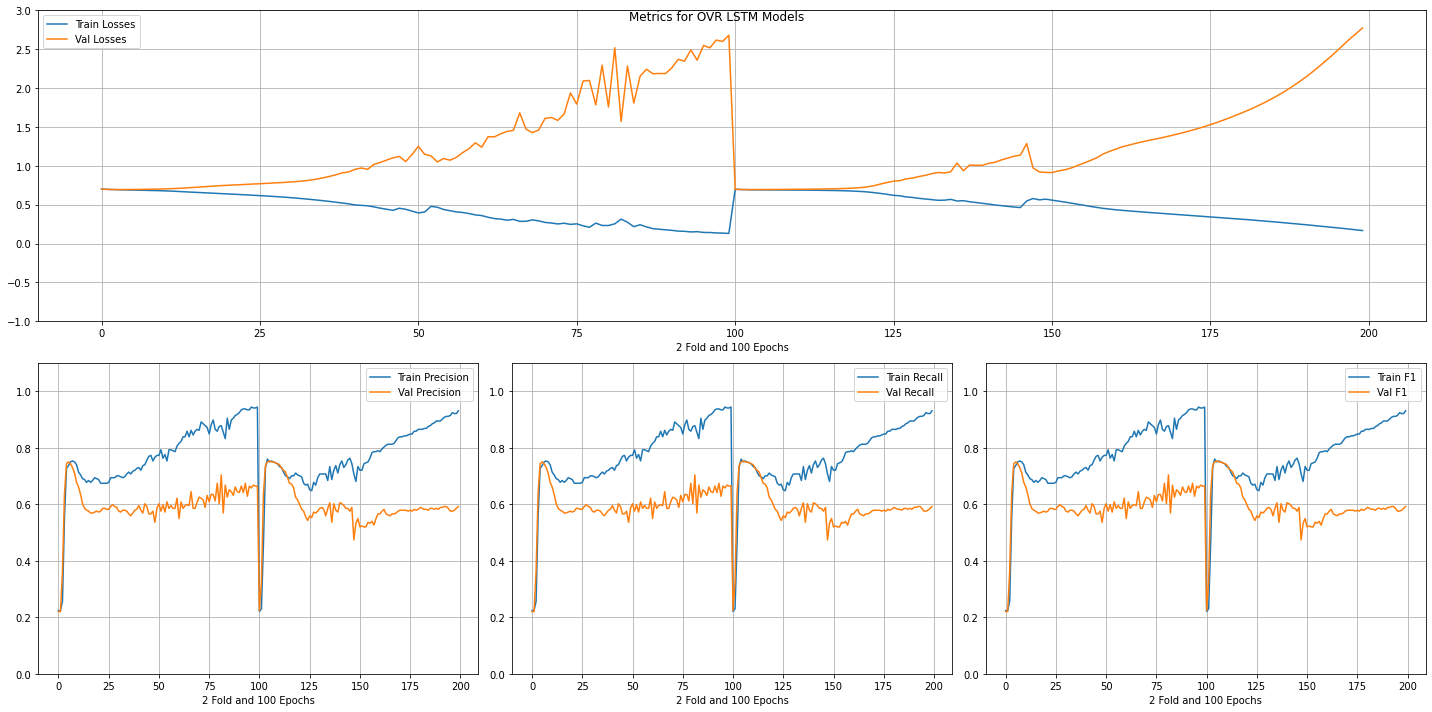

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.750000       0.753289  ...      0.690117           0.694878
5   0.736842       0.750000  ...      0.687963           0.695146
7   0.750000       0.750000  ...      0.689400           0.695744
6   0.753289       0.750000  ...      0.689802           0.695305
4   0.759868       0.750000  ...      0.690360           0.694440
..       ...            ...  ...           ...                ...
2   0.256579       0.361842  ...      0.692954           0.694566
1   0.230263       0.325658  ...      0.693784           0.694754
0   0.220395       0.223684  ...      0.697897           0.696948
1   0.223684       0.220395  ...      0.696008           0.696067
0   0.223684       0.220395  ...      0.701242           0.699089

[200 rows x 8 columns]
Training for ['Naganandini'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [0.58574181 3.41573034]
Epoch 1/100 : Training Loss: 0.699 / Validation

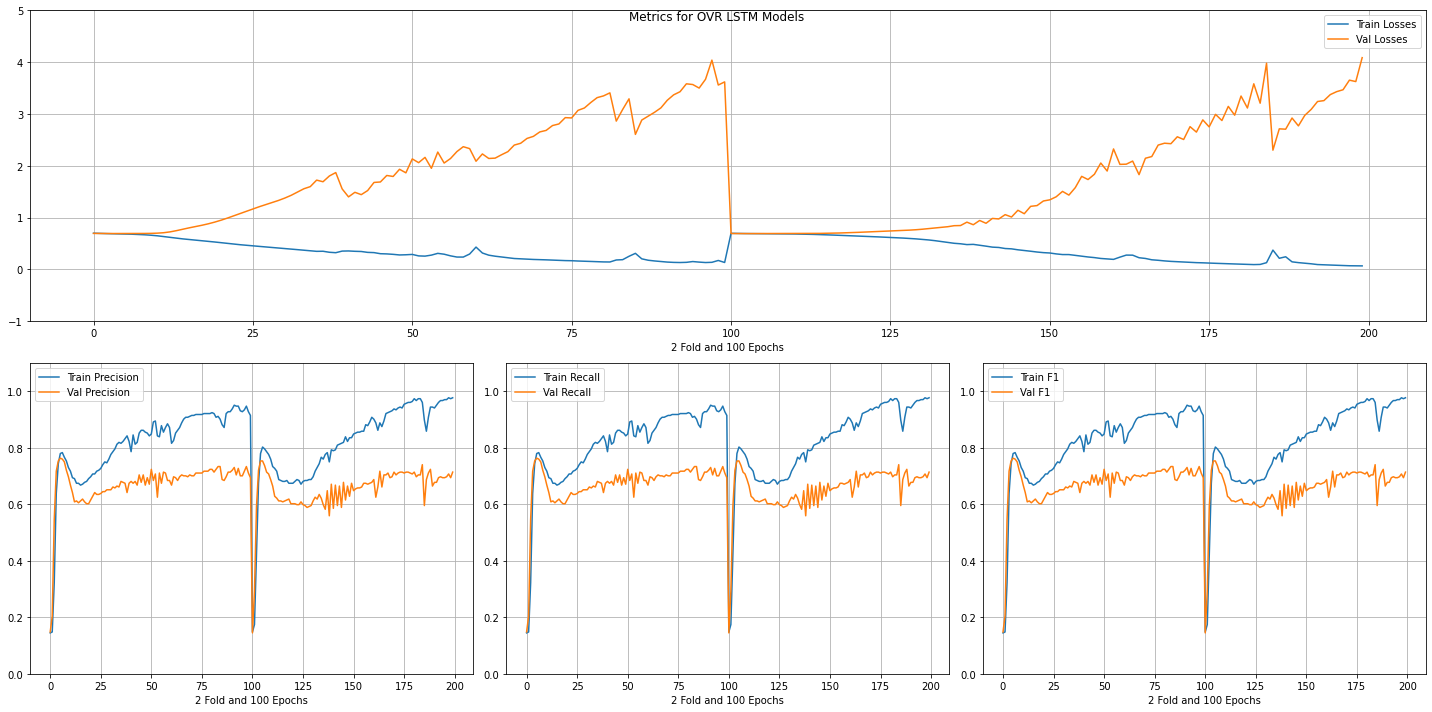

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.779605       0.763158  ...      0.683176           0.692653
6   0.782895       0.759868  ...      0.679478           0.692875
5   0.802632       0.753289  ...      0.689787           0.691919
4   0.779605       0.753289  ...      0.690540           0.691755
4   0.743421       0.753289  ...      0.686140           0.692520
..       ...            ...  ...           ...                ...
2   0.322368       0.546053  ...      0.691079           0.692727
1   0.174342       0.292763  ...      0.693728           0.691621
1   0.148026       0.203947  ...      0.693800           0.693376
0   0.144737       0.148026  ...      0.698654           0.694865
0   0.148026       0.144737  ...      0.696700           0.692566

[200 rows x 8 columns]
Training for ['Natabhairavi'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [ 0.5232358  11.25925926]
Epoch 1/100 : Training Loss: 0.704 / Validat

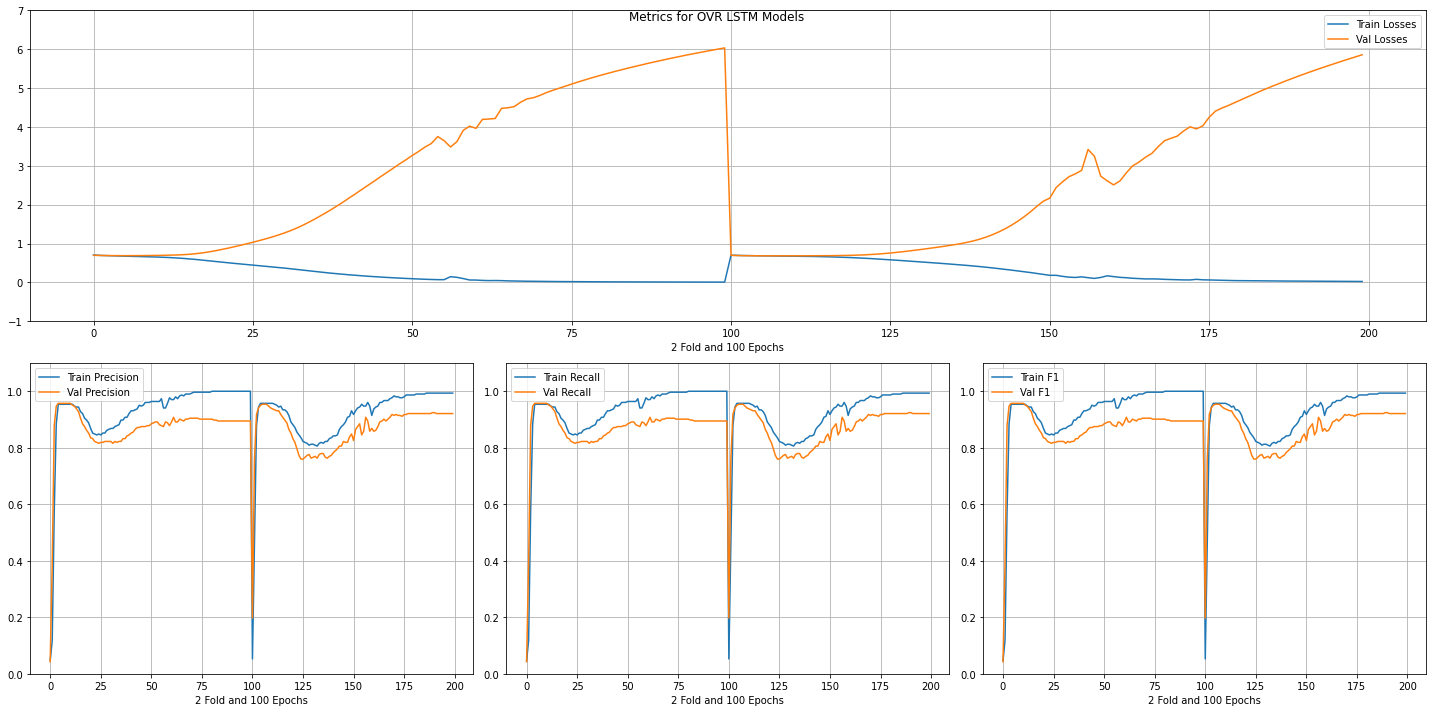

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.953947       0.957237  ...      0.678262           0.686757
5   0.953947       0.957237  ...      0.674059           0.686451
6   0.953947       0.957237  ...      0.670001           0.686811
7   0.953947       0.957237  ...      0.665934           0.687737
8   0.953947       0.957237  ...      0.661671           0.689126
..       ...            ...  ...           ...                ...
1   0.476974       0.759868  ...      0.693138           0.690065
24  0.835526       0.759868  ...      0.590976           0.739983
1   0.118421       0.391447  ...      0.693658           0.692362
0   0.052632       0.197368  ...      0.699825           0.694556
0   0.046053       0.042763  ...      0.703960           0.696292

[200 rows x 8 columns]
Training for ['Shankarabharanam'] with 136 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [0.6440678  2.23529412]
Epoch 1/100 : Training Loss: 0.696 / Vali

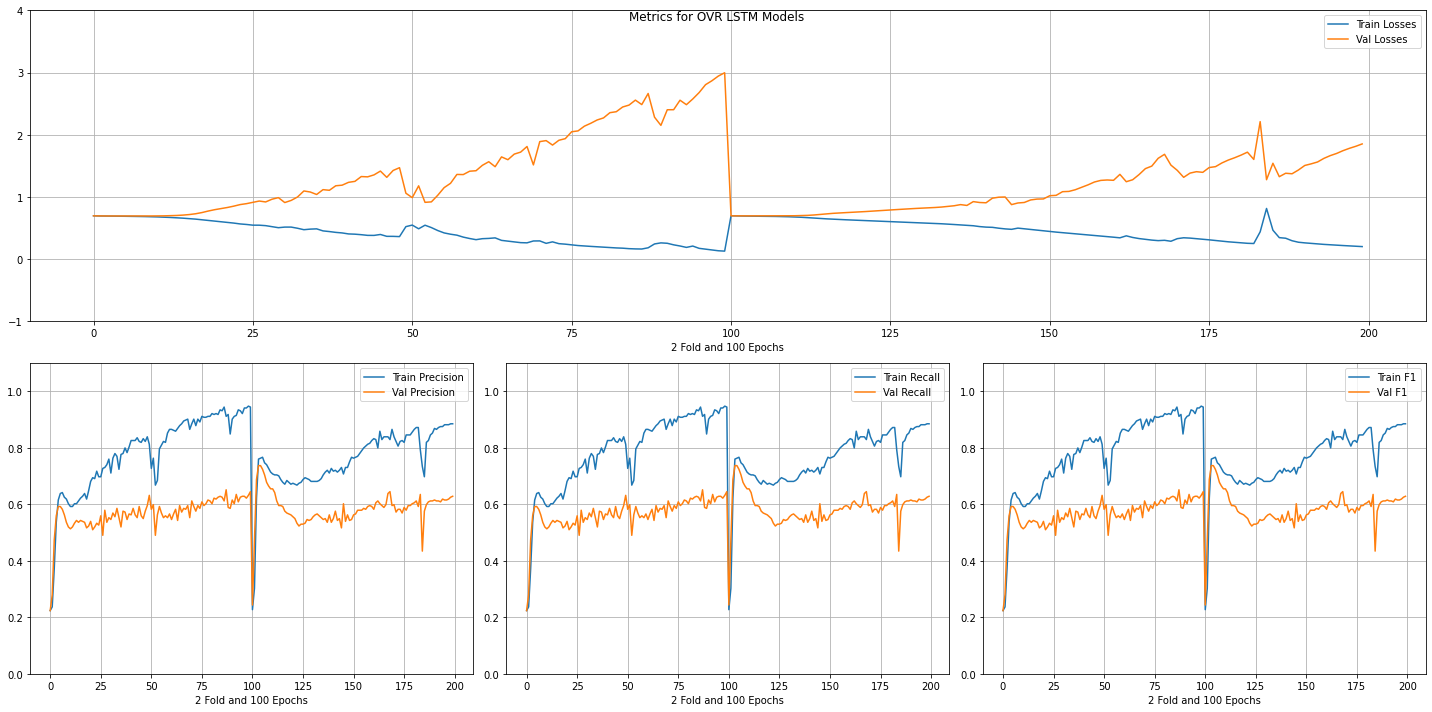

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.759868       0.736842  ...      0.690341           0.694284
4   0.763158       0.736842  ...      0.689360           0.694365
5   0.766447       0.723684  ...      0.688222           0.694404
6   0.746711       0.703947  ...      0.686852           0.694467
2   0.621711       0.687500  ...      0.691324           0.694137
..       ...            ...  ...           ...                ...
1   0.302632       0.473684  ...      0.692744           0.694105
84  0.733553       0.434211  ...      0.813781           1.276333
1   0.236842       0.279605  ...      0.692537           0.693332
0   0.226974       0.243421  ...      0.695742           0.694738
0   0.223684       0.223684  ...      0.696015           0.694904

[200 rows x 8 columns]
Training for ['Shubhapantuvarali'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [0.52777778 9.5       ]
Epoch 1/100 : Training Loss: 0.717 / Vali

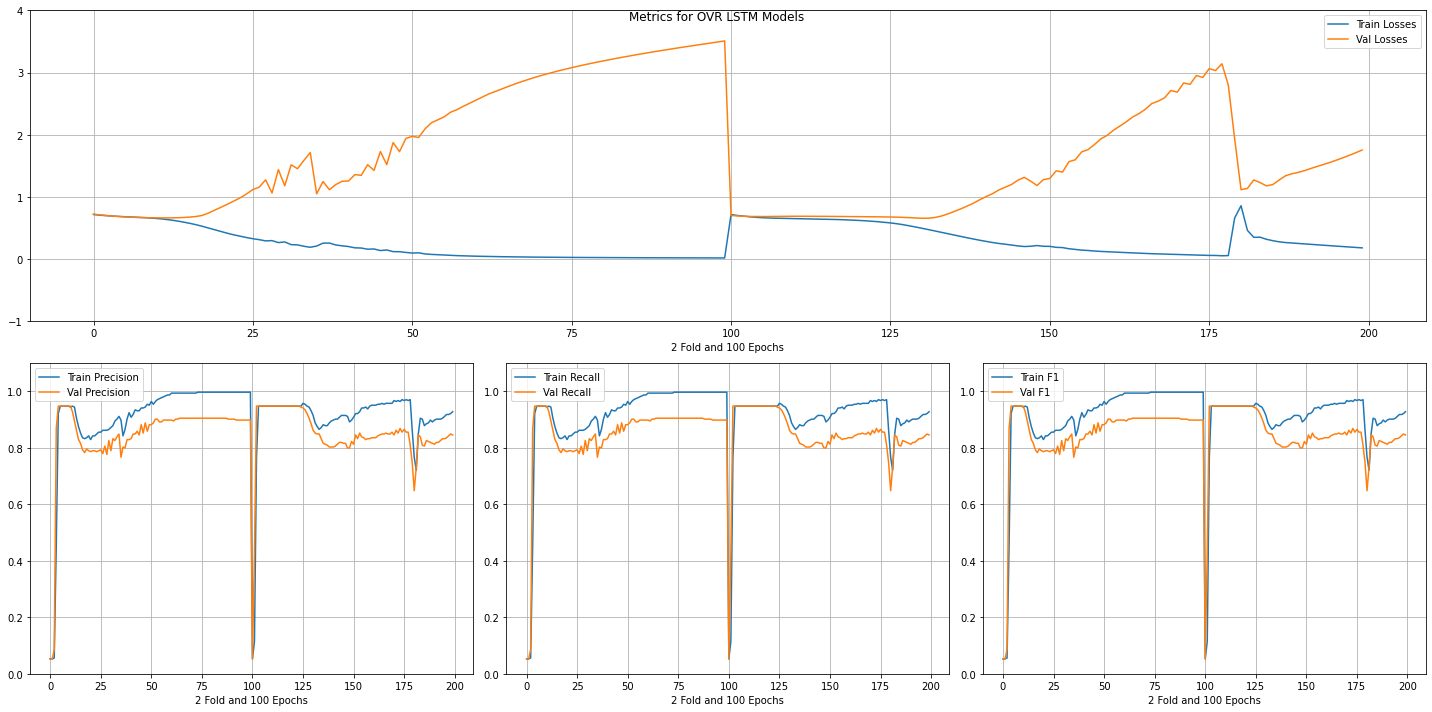

    train_f1  validation_f1  ...  train_losses  validation_losses
20  0.947368       0.947368  ...      0.621519           0.682152
13  0.947368       0.947368  ...      0.645746           0.687628
21  0.947368       0.947368  ...      0.615702           0.681136
23  0.947368       0.947368  ...      0.601123           0.679046
22  0.947368       0.947368  ...      0.608959           0.680102
..       ...            ...  ...           ...                ...
1   0.115132       0.430921  ...      0.701057           0.693534
2   0.055921       0.085526  ...      0.697460           0.699680
0   0.052632       0.052632  ...      0.716650           0.722616
1   0.052632       0.052632  ...      0.705539           0.710247
0   0.052632       0.052632  ...      0.715514           0.700514

[200 rows x 8 columns]
Training for ['Vakulabharanam'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 304/304
Class Weights : [0.53996448 6.75555556]
Epoch 1/100 : Training Loss: 0.713 / Validat

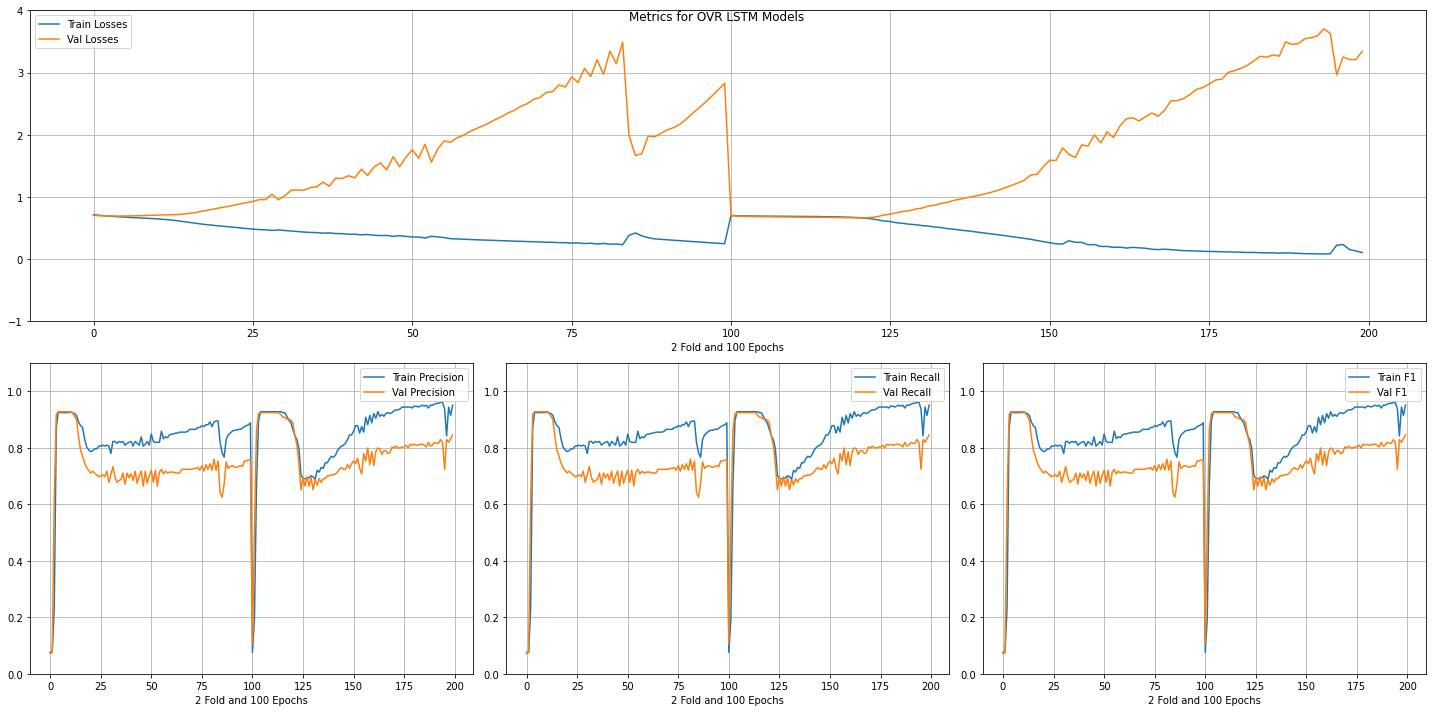

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.927632       0.927632  ...      0.679826           0.691306
5   0.924342       0.927632  ...      0.673540           0.692140
6   0.924342       0.927632  ...      0.667900           0.694283
7   0.924342       0.927632  ...      0.662835           0.697286
8   0.924342       0.927632  ...      0.657979           0.700457
..       ...            ...  ...           ...                ...
2   0.230263       0.615132  ...      0.694170           0.693673
1   0.197368       0.519737  ...      0.696287           0.691793
0   0.075658       0.105263  ...      0.701877           0.697903
1   0.075658       0.075658  ...      0.702490           0.696629
0   0.075658       0.072368  ...      0.712536           0.700730

[200 rows x 8 columns]


In [55]:
jovr_res_reduced = ovr_train_model_lstm(rdata, ChromaJanakaRagaDataset, ChromaLstmModel, "OVR LSTM Models", jlabels1, cl, lbl_encoder=jle, 
                                        target='JanakaRagamCode', feature='chroma', epochs=100, lr=1e-3)

In [56]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.957237       0.960526  ...      0.636399           0.681664
3   0.927632       0.960526  ...      0.684115           0.683205
4   0.957237       0.960526  ...      0.678181           0.677983
5   0.957237       0.960526  ...      0.672744           0.674440
6   0.957237       0.960526  ...      0.667655           0.672613

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.947368       0.967105  ...      0.683549           0.684682
10  0.967105       0.967105  ...      0.621219           0.679703
10  0.970395       0.967105  ...      0.635720           0.671518
9   0.967105       0.967105  ...      0.645121           0.670784
8   0.967105       0.967105  ...      0.652825           0.670899

[5 rows x 8 columns]
['Harikambhoji']
   train_f1  validation_f1  ...  train_losses  validation_losses
4  0.865132       0.888158  ...      0.690111        